In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

ModuleNotFoundError: No module named 'encoding_information'

In [2]:
# channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
# edge_crop = 32
# num_images = 5000
# num_patches = 5000
# photons_per_pixel = 50
# num_bootstrap_samples = 1
# confidence_interval = 99
# patch_size = 30

# mi_means = []
# mi_confidences = []
# h_y_given_x_means = []
# h_y_given_x_confidences = []
# for channel_name in tqdm(channel_names):
#     images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
#     patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
#     # patches = patches * photons_per_pixel / np.mean(images)
#     # noisy_patches = add_noise(patches)

#     rescale_fraction = photons_per_pixel / np.mean(images)
#     noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=rescale_fraction)

#     mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
#                 estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False), verbose=True)
    
#     h_y_given_x_mean, h_y_given_x_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
#                 estimation_fn=lambda noisy_images: estimate_conditional_entropy(noisy_images), verbose=True)

#     mi_means.append(mi_mean)
#     mi_confidences.append(mi_confidence)
#     h_y_given_x_means.append(h_y_given_x_mean)
#     h_y_given_x_confidences.append(h_y_given_x_confidence)

    
# mi_means = np.array(mi_means)
# mi_confidences = np.array(mi_confidences)
# h_y_given_x_means = np.array(h_y_given_x_means)
# h_y_given_x_confidences = np.array(h_y_given_x_confidences)

In [3]:
# # set the width of the bars
# bar_width = 0.35
# error_kw = {'capsize': 12, 'capthick': 2}

# # create a paired bar plot of results
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))


# # create the bar plots
# bar_width = 0.5
# lower_errors = mi_means - mi_confidences[:, 0]
# upper_errors = mi_confidences[:, 1] - mi_means

# # Calculate the positions where the bars should be placed to be centered on the ticks
# positions = np.arange(len(channel_names)) + 0.5 * bar_width

# ax.bar(
#     positions,
#     mi_means,
#     yerr=np.array([lower_errors, upper_errors]),
#     width=bar_width,
#     color=colors[0],
#     edgecolor='k',
#     linewidth=1,
#     error_kw=error_kw
# )

# # add labels, title, and legend
# ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
# ax.set_ylabel('Estimated mutual information per pixel (bits)')
# fig.suptitle(f'{confidence_interval}% confidence interval')
# clear_spines(ax)

# # make another plot for conditional entropy
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# lower_errors = h_y_given_x_means - h_y_given_x_confidences[:, 0]
# upper_errors = h_y_given_x_confidences[:, 1] - h_y_given_x_means

# ax.bar(
#     positions,
#     h_y_given_x_means,
#     yerr=np.array([lower_errors, upper_errors]),
#     width=bar_width,
#     color=colors[0],
#     edgecolor='k',
#     linewidth=1,
#     error_kw=error_kw
# )

# # add labels, title, and legend
# ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
# ax.set_ylabel('Estimated conditional entropy per pixel (bits)')
# fig.suptitle(f'{confidence_interval}% confidence interval')
# clear_spines(ax)

## MI vs num photons

In [4]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = [30, 60, 120, 240, 480]
num_bootstrap_samples = 11
confidence_interval = 90
patch_size = 10



mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False)
    for num_photons in photons_per_pixel:
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
        noisy_patches = add_shot_noise_to_experimenal_data(patches, num_photons / np.mean(images))
        # noisy_patches = add_noise(patches * num_photons / np.mean(images))

        mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                                               upper_bound_confidence_interval=True,
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=True, ),
                                                                                  #  entropy_model='pixelcnn'),
                      verbose=True)
        mi_means_by_channel_photons[channel_name].append(mi_mean)
        mi_confidences_by_channel_photons[channel_name].append(mi_confidence)
    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}

Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]2024-01-09 10:03:24.557065: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.04it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.35it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.98it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.53it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.29it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.11it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.52it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.14it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 21: validation NLL: 3.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 22: validation NLL: 3.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 23: validation NLL: 3.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.11it/s]


Epoch 24: validation NLL: 3.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 25: validation NLL: 3.13




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.06it/s]


Epoch 26: validation NLL: 3.13




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 27: validation NLL: 3.13




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 28: validation NLL: 3.13




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.02it/s]


Epoch 29: validation NLL: 3.13




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.37it/s]


Epoch 30: validation NLL: 3.13




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.19it/s]


Epoch 31: validation NLL: 3.13




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 32: validation NLL: 3.13




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 33: validation NLL: 3.13




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch 34: validation NLL: 3.13




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 35: validation NLL: 3.13




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 36: validation NLL: 3.13




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 37: validation NLL: 3.13




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 38: validation NLL: 3.13




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.73it/s]


Epoch 39: validation NLL: 3.13




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 40: validation NLL: 3.13




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch 41: validation NLL: 3.13




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 42: validation NLL: 3.13




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 43: validation NLL: 3.13




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.27it/s]


Epoch 44: validation NLL: 3.13




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.80it/s]


Epoch 45: validation NLL: 3.13




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.72it/s]


Epoch 46: validation NLL: 3.13




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 47: validation NLL: 3.13




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.72it/s]


Epoch 48: validation NLL: 3.13




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 49: validation NLL: 3.13




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.09it/s]


Epoch 50: validation NLL: 3.13




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 51: validation NLL: 3.13




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.70it/s]


Epoch 52: validation NLL: 3.13




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 53: validation NLL: 3.13




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 54: validation NLL: 3.13




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 55: validation NLL: 3.13




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 56: validation NLL: 3.13




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 57: validation NLL: 3.13




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 58: validation NLL: 3.13




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.53it/s]


Epoch 59: validation NLL: 3.13




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.92it/s]


Epoch 60: validation NLL: 3.13




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 55.79it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 174.20it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:29<04:54, 29.40s/it]

Estimated H(Y|X) = 3.104 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.136 differential entropy/pixel
Estimated I(Y;X) = 0.046 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.46it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.14it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.21it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.71it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.05it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.80it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.76it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.61it/s]


Epoch 21: validation NLL: 3.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s]


Epoch 22: validation NLL: 3.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 23: validation NLL: 3.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 24: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 167.29it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 180.19it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:40<02:47, 18.56s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.130 differential entropy/pixel
Estimated I(Y;X) = 0.037 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.47it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.04it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.30it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.68it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.05it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.82it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.23it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 21: validation NLL: 3.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.45it/s]


Epoch 22: validation NLL: 3.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 23: validation NLL: 3.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 24: validation NLL: 3.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 25: validation NLL: 3.13




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 26: validation NLL: 3.13




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.15it/s]


Epoch 27: validation NLL: 3.13




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 28: validation NLL: 3.13




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.80it/s]


Epoch 29: validation NLL: 3.13




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 30: validation NLL: 3.13




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 31: validation NLL: 3.13




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.00it/s]


Epoch 32: validation NLL: 3.13




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 33: validation NLL: 3.13




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 34: validation NLL: 3.13




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 35: validation NLL: 3.13




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 36: validation NLL: 3.13




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 37: validation NLL: 3.13




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch 38: validation NLL: 3.13




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 39: validation NLL: 3.13




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.69it/s]


Epoch 40: validation NLL: 3.13




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 46.17it/s]


Epoch 41: validation NLL: 3.13




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 42: validation NLL: 3.13




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 43: validation NLL: 3.13




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 44: validation NLL: 3.13




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 45: validation NLL: 3.13




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 46: validation NLL: 3.13




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 47: validation NLL: 3.13




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.02it/s]


Epoch 48: validation NLL: 3.13




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 49: validation NLL: 3.13




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 50: validation NLL: 3.13




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.16it/s]


Epoch 51: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 160.75it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 179.89it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:56<02:18, 17.33s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.134 differential entropy/pixel
Estimated I(Y;X) = 0.042 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.32it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.66it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.19it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.11it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.86it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.32it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 21: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 187.49it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 166.40it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:06<01:41, 14.56s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.134 differential entropy/pixel
Estimated I(Y;X) = 0.043 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.11it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.40it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.06it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.69it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.00it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.66it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.72it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.48it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.18it/s]


Epoch 21: validation NLL: 3.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.97it/s]


Epoch 22: validation NLL: 3.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 23: validation NLL: 3.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.80it/s]


Epoch 24: validation NLL: 3.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.90it/s]


Epoch 25: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 188.38it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 149.21it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:17<01:20, 13.37s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.134 differential entropy/pixel
Estimated I(Y;X) = 0.042 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.77it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.54it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.15it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.62it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.40it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.27it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 21: validation NLL: 3.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 22: validation NLL: 3.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 23: validation NLL: 3.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.08it/s]


Epoch 24: validation NLL: 3.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 25: validation NLL: 3.13




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.06it/s]


Epoch 26: validation NLL: 3.13




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 27: validation NLL: 3.13




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 28: validation NLL: 3.13




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 29: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 188.35it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 172.24it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:29<01:04, 12.83s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.130 differential entropy/pixel
Estimated I(Y;X) = 0.036 bits/pixel
Initial validation NLL: 3.14




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 1: validation NLL: 3.14




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch 2: validation NLL: 3.14




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 3: validation NLL: 3.14




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.78it/s]


Epoch 4: validation NLL: 3.14




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 5: validation NLL: 3.14




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.16it/s]


Epoch 6: validation NLL: 3.14




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.95it/s]


Epoch 7: validation NLL: 3.14




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 8: validation NLL: 3.14




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.52it/s]


Epoch 9: validation NLL: 3.14




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.68it/s]


Epoch 10: validation NLL: 3.14




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.98it/s]


Epoch 11: validation NLL: 3.14




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 12: validation NLL: 3.14




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 13: validation NLL: 3.14




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.87it/s]


Epoch 14: validation NLL: 3.14




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.40it/s]


Epoch 15: validation NLL: 3.14




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.72it/s]


Epoch 16: validation NLL: 3.14




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 17: validation NLL: 3.14




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 18: validation NLL: 3.14




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.80it/s]


Epoch 19: validation NLL: 3.14




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 20: validation NLL: 3.14




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 21: validation NLL: 3.14




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 22: validation NLL: 3.14




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 23: validation NLL: 3.14




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.07it/s]


Epoch 24: validation NLL: 3.14




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.19it/s]


Epoch 25: validation NLL: 3.14




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.72it/s]


Epoch 26: validation NLL: 3.14




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 27: validation NLL: 3.14




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 28: validation NLL: 3.14




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 29: validation NLL: 3.14




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 189.38it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 186.51it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:41<00:50, 12.51s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.133 differential entropy/pixel
Estimated I(Y;X) = 0.041 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.35it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.86it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.66it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.44it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.98it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.09it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.06it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.65it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.93it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 16: validation NLL: 3.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]


Epoch 17: validation NLL: 3.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.68it/s]


Epoch 18: validation NLL: 3.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 19: validation NLL: 3.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.81it/s]


Epoch 20: validation NLL: 3.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 21: validation NLL: 3.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 22: validation NLL: 3.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 23: validation NLL: 3.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.85it/s]


Epoch 24: validation NLL: 3.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.07it/s]


Epoch 25: validation NLL: 3.13




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 26: validation NLL: 3.13




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 27: validation NLL: 3.13




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.41it/s]


Epoch 28: validation NLL: 3.13




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 29: validation NLL: 3.13




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.66it/s]


Epoch 30: validation NLL: 3.13




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.44it/s]


Epoch 31: validation NLL: 3.13




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.88it/s]


Epoch 32: validation NLL: 3.13




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.34it/s]


Epoch 33: validation NLL: 3.13




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 34: validation NLL: 3.13




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 35: validation NLL: 3.13




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 36: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 185.07it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 159.58it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:54<00:37, 12.65s/it]

Estimated H(Y|X) = 3.104 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.135 differential entropy/pixel
Estimated I(Y;X) = 0.045 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.71it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.84it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.13it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.94it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.19it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.41it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 16: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 180.58it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 158.52it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [02:03<00:23, 11.68s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.128 differential entropy/pixel
Estimated I(Y;X) = 0.033 bits/pixel
Initial validation NLL: 3.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 1: validation NLL: 3.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 2: validation NLL: 3.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.37it/s]


Epoch 3: validation NLL: 3.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.14it/s]


Epoch 4: validation NLL: 3.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 5: validation NLL: 3.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 6: validation NLL: 3.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.80it/s]


Epoch 7: validation NLL: 3.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.83it/s]


Epoch 8: validation NLL: 3.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.33it/s]


Epoch 9: validation NLL: 3.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 10: validation NLL: 3.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 11: validation NLL: 3.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch 12: validation NLL: 3.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.58it/s]


Epoch 13: validation NLL: 3.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 14: validation NLL: 3.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.19it/s]


Epoch 15: validation NLL: 3.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.32it/s]


Epoch 16: validation NLL: 3.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 177.03it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 165.64it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [02:13<00:10, 10.98s/it]

Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.133 differential entropy/pixel
Estimated I(Y;X) = 0.041 bits/pixel
Initial validation NLL: 3.12




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 1: validation NLL: 3.12




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 43.05it/s]


Epoch 2: validation NLL: 3.12




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch 3: validation NLL: 3.12




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 4: validation NLL: 3.12




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.07it/s]


Epoch 5: validation NLL: 3.12




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 6: validation NLL: 3.12




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.81it/s]


Epoch 7: validation NLL: 3.12




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.30it/s]


Epoch 8: validation NLL: 3.12




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.15it/s]


Epoch 9: validation NLL: 3.12




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 10: validation NLL: 3.12




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 11: validation NLL: 3.12




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 12: validation NLL: 3.12




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 13: validation NLL: 3.12




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 14: validation NLL: 3.12




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 46.90it/s]


Epoch 15: validation NLL: 3.12




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.27it/s]


Epoch 16: validation NLL: 3.12




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 17: validation NLL: 3.12




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.32it/s]


Epoch 18: validation NLL: 3.12




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.74it/s]


Epoch 19: validation NLL: 3.12




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch 20: validation NLL: 3.12




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 21: validation NLL: 3.12




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.19it/s]


Epoch 22: validation NLL: 3.12




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.85it/s]


Epoch 23: validation NLL: 3.12




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.43it/s]


Epoch 24: validation NLL: 3.12




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 25: validation NLL: 3.12




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 26: validation NLL: 3.12




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.00it/s]


Epoch 27: validation NLL: 3.12




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 28: validation NLL: 3.12




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 29: validation NLL: 3.12




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.92it/s]


Epoch 30: validation NLL: 3.12




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 31: validation NLL: 3.12




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.80it/s]


Epoch 32: validation NLL: 3.12




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.87it/s]


Epoch 33: validation NLL: 3.12




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.04it/s]


Epoch 34: validation NLL: 3.12




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 35: validation NLL: 3.12




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 36: validation NLL: 3.12




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.80it/s]


Epoch 37: validation NLL: 3.12




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 38: validation NLL: 3.12




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 39: validation NLL: 3.12




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 40: validation NLL: 3.12




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.01it/s]


Epoch 41: validation NLL: 3.12




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


Epoch 42: validation NLL: 3.12




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.79it/s]


Epoch 43: validation NLL: 3.12




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 44: validation NLL: 3.12




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 45: validation NLL: 3.12




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.36it/s]


Epoch 46: validation NLL: 3.12




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.42it/s]


Epoch 47: validation NLL: 3.12




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 48: validation NLL: 3.12




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 49: validation NLL: 3.12




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.86it/s]


Epoch 50: validation NLL: 3.12




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch 51: validation NLL: 3.12




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 52: validation NLL: 3.12




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.71it/s]


Epoch 53: validation NLL: 3.12




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.08it/s]


Epoch 54: validation NLL: 3.12




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.48it/s]


Epoch 55: validation NLL: 3.12




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 56: validation NLL: 3.12




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.87it/s]


Epoch 57: validation NLL: 3.12




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 58: validation NLL: 3.12




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.64it/s]


Epoch 59: validation NLL: 3.12




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.74it/s]


Epoch 60: validation NLL: 3.12




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 179.05it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 186.96it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:30<00:00, 13.70s/it]


Estimated H(Y|X) = 3.105 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.138 differential entropy/pixel
Estimated I(Y;X) = 0.047 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.44it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.18it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.72it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.43it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.98it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.94it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.04it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.50it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.44it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 20: validation NLL: 3.49




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.85it/s]


Epoch 21: validation NLL: 3.49




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 22: validation NLL: 3.49




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.53it/s]


Epoch 23: validation NLL: 3.49




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.57it/s]


Epoch 24: validation NLL: 3.49




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 25: validation NLL: 3.49




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 26: validation NLL: 3.49




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.71it/s]


Epoch 27: validation NLL: 3.49




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 28: validation NLL: 3.49




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 29: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 175.08it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 162.08it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:11<01:57, 11.79s/it]

Estimated H(Y|X) = 3.457 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.480 differential entropy/pixel
Estimated I(Y;X) = 0.033 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.71it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.38it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.92it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.15it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.53it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.35it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.29it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.04it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.33it/s]


Epoch 20: validation NLL: 3.49




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 21: validation NLL: 3.49




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 22: validation NLL: 3.49




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.86it/s]


Epoch 23: validation NLL: 3.49




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 24: validation NLL: 3.49




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.70it/s]


Epoch 25: validation NLL: 3.49




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 26: validation NLL: 3.49




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.23it/s]


Epoch 27: validation NLL: 3.49




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.15it/s]


Epoch 28: validation NLL: 3.49




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 29: validation NLL: 3.49




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 30: validation NLL: 3.49




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 31: validation NLL: 3.49




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 32: validation NLL: 3.49




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch 33: validation NLL: 3.49




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.78it/s]


Epoch 34: validation NLL: 3.49




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.79it/s]


Epoch 35: validation NLL: 3.49




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.72it/s]


Epoch 36: validation NLL: 3.49




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 37: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 167.52it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 154.16it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:25<01:54, 12.76s/it]

Estimated H(Y|X) = 3.457 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.485 differential entropy/pixel
Estimated I(Y;X) = 0.041 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.93it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.02it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.98it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.40it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.09it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.44it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 20: validation NLL: 3.49




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 21: validation NLL: 3.49




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.88it/s]


Epoch 22: validation NLL: 3.49




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.57it/s]


Epoch 23: validation NLL: 3.49




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 24: validation NLL: 3.49




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 25: validation NLL: 3.49




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 26: validation NLL: 3.49




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.23it/s]


Epoch 27: validation NLL: 3.49




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch 28: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 179.38it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 145.99it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:37<01:39, 12.49s/it]

Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.480 differential entropy/pixel
Estimated I(Y;X) = 0.034 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.30it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.39it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.51it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.48it/s]


Epoch 20: validation NLL: 3.49




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 21: validation NLL: 3.49




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 22: validation NLL: 3.49




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 23: validation NLL: 3.49




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 24: validation NLL: 3.49




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.18it/s]


Epoch 25: validation NLL: 3.49




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.53it/s]


Epoch 26: validation NLL: 3.49




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch 27: validation NLL: 3.49




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 28: validation NLL: 3.49




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 29: validation NLL: 3.49




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.18it/s]


Epoch 30: validation NLL: 3.49




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 31: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 204.75it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 176.45it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:49<01:26, 12.37s/it]

Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.488 differential entropy/pixel
Estimated I(Y;X) = 0.046 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.60it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.55it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.08it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.08it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.81it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 16: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 159.50it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 177.63it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [00:58<01:07, 11.30s/it]

Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.484 differential entropy/pixel
Estimated I(Y;X) = 0.040 bits/pixel
Initial validation NLL: 3.48




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 3.48




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch 2: validation NLL: 3.48




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 3: validation NLL: 3.48




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.62it/s]


Epoch 4: validation NLL: 3.48




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 5: validation NLL: 3.48




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 6: validation NLL: 3.48




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.29it/s]


Epoch 7: validation NLL: 3.48




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 8: validation NLL: 3.48




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.00it/s]


Epoch 9: validation NLL: 3.48




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 10: validation NLL: 3.48




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 11: validation NLL: 3.48




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 12: validation NLL: 3.48




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.18it/s]


Epoch 13: validation NLL: 3.48




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.66it/s]


Epoch 14: validation NLL: 3.48




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 15: validation NLL: 3.48




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 16: validation NLL: 3.48




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.63it/s]


Epoch 17: validation NLL: 3.48




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 172.97it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 171.98it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:08<00:53, 10.79s/it]

Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.483 differential entropy/pixel
Estimated I(Y;X) = 0.038 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.07it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.77it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.37it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.48it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.91it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.65it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch 17: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 193.70it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 170.54it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:18<00:41, 10.40s/it]

Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.481 differential entropy/pixel
Estimated I(Y;X) = 0.036 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.92it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.24it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.94it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.51it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.99it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.37it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.36it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.86it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.27it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.04it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.51it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 20: validation NLL: 3.49




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.91it/s]


Epoch 21: validation NLL: 3.49




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 22: validation NLL: 3.49




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.14it/s]


Epoch 23: validation NLL: 3.49




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.56it/s]


Epoch 24: validation NLL: 3.49




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.87it/s]


Epoch 25: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 196.97it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 155.71it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:29<00:31, 10.60s/it]

Estimated H(Y|X) = 3.457 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.487 differential entropy/pixel
Estimated I(Y;X) = 0.044 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.59it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.24it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.34it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.40it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.94it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.40it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.30it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.81it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.18it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 20: validation NLL: 3.49




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 21: validation NLL: 3.49




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 22: validation NLL: 3.49




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 23: validation NLL: 3.49




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.35it/s]


Epoch 24: validation NLL: 3.49




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.85it/s]


Epoch 25: validation NLL: 3.49




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.29it/s]


Epoch 26: validation NLL: 3.49




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 44.81it/s]


Epoch 27: validation NLL: 3.49




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 28: validation NLL: 3.49




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.02it/s]


Epoch 29: validation NLL: 3.49




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 30: validation NLL: 3.49




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 31: validation NLL: 3.49




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 32: validation NLL: 3.49




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.13it/s]


Epoch 33: validation NLL: 3.49




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 34: validation NLL: 3.49




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 35: validation NLL: 3.49




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.80it/s]


Epoch 36: validation NLL: 3.49




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.23it/s]


Epoch 37: validation NLL: 3.49




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.48it/s]


Epoch 38: validation NLL: 3.49




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 39: validation NLL: 3.49




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 40: validation NLL: 3.49




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 41: validation NLL: 3.49




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 42: validation NLL: 3.49




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 43: validation NLL: 3.49




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 44: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 176.78it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 182.99it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [01:43<00:23, 11.84s/it]

Estimated H(Y|X) = 3.457 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.482 differential entropy/pixel
Estimated I(Y;X) = 0.037 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.09it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 5: validation NLL: 3.49




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.12it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.45it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.07it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.61it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.99it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.22it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 18: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 172.87it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 191.77it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [01:53<00:11, 11.26s/it]

Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.487 differential entropy/pixel
Estimated I(Y;X) = 0.045 bits/pixel
Initial validation NLL: 3.49




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 1: validation NLL: 3.49




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.10it/s]


Epoch 2: validation NLL: 3.49




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.05it/s]


Epoch 3: validation NLL: 3.49




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 4: validation NLL: 3.49




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 5: validation NLL: 3.48




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 6: validation NLL: 3.49




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.11it/s]


Epoch 7: validation NLL: 3.49




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.03it/s]


Epoch 8: validation NLL: 3.49




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 9: validation NLL: 3.49




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 10: validation NLL: 3.49




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 11: validation NLL: 3.49




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.35it/s]


Epoch 12: validation NLL: 3.49




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 13: validation NLL: 3.49




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 14: validation NLL: 3.49




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 15: validation NLL: 3.49




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 16: validation NLL: 3.49




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.86it/s]


Epoch 17: validation NLL: 3.49




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 18: validation NLL: 3.49




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 19: validation NLL: 3.49




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 20: validation NLL: 3.49




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 179.55it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 181.53it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:04<00:00, 11.30s/it]


Estimated H(Y|X) = 3.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.483 differential entropy/pixel
Estimated I(Y;X) = 0.039 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.40it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.43it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.73it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.93it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.12it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.34it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.66it/s]


Epoch 18: validation NLL: 3.84




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 19: validation NLL: 3.84




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.86it/s]


Epoch 20: validation NLL: 3.84




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 21: validation NLL: 3.84




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 22: validation NLL: 3.84




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 23: validation NLL: 3.84




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.81it/s]


Epoch 24: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 191.14it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 186.93it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:11<01:53, 11.33s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.842 differential entropy/pixel
Estimated I(Y;X) = 0.053 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.97it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.78it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.62it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 18: validation NLL: 3.84




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 19: validation NLL: 3.84




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 20: validation NLL: 3.84




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.60it/s]


Epoch 21: validation NLL: 3.84




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 22: validation NLL: 3.84




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 23: validation NLL: 3.84




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.46it/s]


Epoch 24: validation NLL: 3.84




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 25: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 161.88it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 153.59it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:22<01:40, 11.19s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.841 differential entropy/pixel
Estimated I(Y;X) = 0.052 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.87it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.68it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.96it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.77it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.81it/s]


Epoch 18: validation NLL: 3.84




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.33it/s]


Epoch 19: validation NLL: 3.84




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 20: validation NLL: 3.84




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 21: validation NLL: 3.84




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.71it/s]


Epoch 22: validation NLL: 3.84




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 23: validation NLL: 3.84




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch 24: validation NLL: 3.84




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.21it/s]


Epoch 25: validation NLL: 3.84




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.42it/s]


Epoch 26: validation NLL: 3.84




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 27: validation NLL: 3.84




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 28: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 181.67it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 148.55it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:34<01:31, 11.48s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.840 differential entropy/pixel
Estimated I(Y;X) = 0.050 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.44it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.33it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.93it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.00it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.15it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.30it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.28it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 18: validation NLL: 3.84




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 19: validation NLL: 3.84




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 20: validation NLL: 3.84




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 21: validation NLL: 3.84




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch 22: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 158.49it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 172.64it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:44<01:17, 11.13s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.836 differential entropy/pixel
Estimated I(Y;X) = 0.044 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.54it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.05it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.02it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.71it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.57it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.37it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.75it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.17it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.18it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 18: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 190.30it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 172.48it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [00:54<01:03, 10.66s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.838 differential entropy/pixel
Estimated I(Y;X) = 0.048 bits/pixel
Initial validation NLL: 3.85




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 3.85




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.93it/s]


Epoch 2: validation NLL: 3.85




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.03it/s]


Epoch 3: validation NLL: 3.85




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.13it/s]


Epoch 4: validation NLL: 3.85




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 5: validation NLL: 3.85




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.07it/s]


Epoch 6: validation NLL: 3.85




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.98it/s]


Epoch 7: validation NLL: 3.85




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 8: validation NLL: 3.85




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch 9: validation NLL: 3.85




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.84it/s]


Epoch 10: validation NLL: 3.85




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 11: validation NLL: 3.85




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 12: validation NLL: 3.85




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 13: validation NLL: 3.85




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 14: validation NLL: 3.85




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.72it/s]


Epoch 15: validation NLL: 3.85




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.59it/s]


Epoch 16: validation NLL: 3.85




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 17: validation NLL: 3.85




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.17it/s]


Epoch 18: validation NLL: 3.85




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 19: validation NLL: 3.85




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 20: validation NLL: 3.85




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 200.20it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 171.19it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:04<00:52, 10.55s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.842 differential entropy/pixel
Estimated I(Y;X) = 0.053 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 41.49it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.06it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.80it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.70it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.95it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 18: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 160.67it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 146.58it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:15<00:41, 10.39s/it]

Estimated H(Y|X) = 3.806 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.839 differential entropy/pixel
Estimated I(Y;X) = 0.048 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.58it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.35it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.63it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.59it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.02it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 18: validation NLL: 3.84




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 19: validation NLL: 3.84




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 20: validation NLL: 3.84




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 21: validation NLL: 3.84




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 22: validation NLL: 3.84




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.09it/s]


Epoch 23: validation NLL: 3.84




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.31it/s]


Epoch 24: validation NLL: 3.84




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 25: validation NLL: 3.84




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.14it/s]


Epoch 26: validation NLL: 3.84




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.18it/s]


Epoch 27: validation NLL: 3.84




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 28: validation NLL: 3.84




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.03it/s]


Epoch 29: validation NLL: 3.84




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 30: validation NLL: 3.84




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.95it/s]


Epoch 31: validation NLL: 3.84




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.71it/s]


Epoch 32: validation NLL: 3.84




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.25it/s]


Epoch 33: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 189.09it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 171.45it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:27<00:33, 11.08s/it]

Estimated H(Y|X) = 3.806 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.844 differential entropy/pixel
Estimated I(Y;X) = 0.055 bits/pixel
Initial validation NLL: 3.85




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 1: validation NLL: 3.85




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.40it/s]


Epoch 2: validation NLL: 3.85




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 3: validation NLL: 3.85




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 4: validation NLL: 3.85




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 5: validation NLL: 3.85




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.71it/s]


Epoch 6: validation NLL: 3.85




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.50it/s]


Epoch 7: validation NLL: 3.85




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.97it/s]


Epoch 8: validation NLL: 3.85




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.41it/s]


Epoch 9: validation NLL: 3.85




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 10: validation NLL: 3.85




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 11: validation NLL: 3.85




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 12: validation NLL: 3.85




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.89it/s]


Epoch 13: validation NLL: 3.85




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 14: validation NLL: 3.85




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.91it/s]


Epoch 15: validation NLL: 3.85




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.30it/s]


Epoch 16: validation NLL: 3.85




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch 17: validation NLL: 3.85




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.96it/s]


Epoch 18: validation NLL: 3.85




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.13it/s]


Epoch 19: validation NLL: 3.85




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch 20: validation NLL: 3.85




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.40it/s]


Epoch 21: validation NLL: 3.85




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch 22: validation NLL: 3.85




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.71it/s]


Epoch 23: validation NLL: 3.85




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 24: validation NLL: 3.85




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.17it/s]


Epoch 25: validation NLL: 3.85




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.67it/s]


Epoch 26: validation NLL: 3.85




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch 27: validation NLL: 3.85




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 28: validation NLL: 3.85




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 182.72it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 159.78it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [01:39<00:22, 11.47s/it]

Estimated H(Y|X) = 3.806 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.846 differential entropy/pixel
Estimated I(Y;X) = 0.058 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.29it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.33it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.91it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.45it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.91it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.70it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 18: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 143.92it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 182.29it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [01:50<00:11, 11.05s/it]

Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.844 differential entropy/pixel
Estimated I(Y;X) = 0.056 bits/pixel
Initial validation NLL: 3.84




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


Epoch 1: validation NLL: 3.84




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.74it/s]


Epoch 2: validation NLL: 3.84




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 3: validation NLL: 3.84




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.68it/s]


Epoch 4: validation NLL: 3.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 5: validation NLL: 3.84




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 6: validation NLL: 3.84




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 7: validation NLL: 3.84




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 8: validation NLL: 3.84




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 9: validation NLL: 3.84




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.59it/s]


Epoch 10: validation NLL: 3.84




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.60it/s]


Epoch 11: validation NLL: 3.84




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.87it/s]


Epoch 12: validation NLL: 3.84




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.52it/s]


Epoch 13: validation NLL: 3.84




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.92it/s]


Epoch 14: validation NLL: 3.84




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


Epoch 15: validation NLL: 3.84




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.82it/s]


Epoch 16: validation NLL: 3.84




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 17: validation NLL: 3.84




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.93it/s]


Epoch 18: validation NLL: 3.84




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.20it/s]


Epoch 19: validation NLL: 3.84




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.03it/s]


Epoch 20: validation NLL: 3.84




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 21: validation NLL: 3.84




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 22: validation NLL: 3.84




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 23: validation NLL: 3.84




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.24it/s]


Epoch 24: validation NLL: 3.84




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 25: validation NLL: 3.84




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.64it/s]


Epoch 26: validation NLL: 3.84




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 27: validation NLL: 3.84




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 28: validation NLL: 3.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 164.02it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 181.42it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:02<00:00, 11.10s/it]


Estimated H(Y|X) = 3.805 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.849 differential entropy/pixel
Estimated I(Y;X) = 0.063 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.21




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 1: validation NLL: 4.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.35it/s]


Epoch 2: validation NLL: 4.21




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 3: validation NLL: 4.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch 4: validation NLL: 4.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 5: validation NLL: 4.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 6: validation NLL: 4.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.70it/s]


Epoch 7: validation NLL: 4.21




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 8: validation NLL: 4.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 9: validation NLL: 4.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.27it/s]


Epoch 10: validation NLL: 4.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.39it/s]


Epoch 11: validation NLL: 4.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 12: validation NLL: 4.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 13: validation NLL: 4.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 14: validation NLL: 4.21




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 15: validation NLL: 4.21




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 17: validation NLL: 4.21




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.02it/s]


Epoch 18: validation NLL: 4.21




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 19: validation NLL: 4.21




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 20: validation NLL: 4.21




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 21: validation NLL: 4.21




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 22: validation NLL: 4.21




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 23: validation NLL: 4.21




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 24: validation NLL: 4.21




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.22it/s]


Epoch 25: validation NLL: 4.21




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.03it/s]


Epoch 26: validation NLL: 4.21




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 27: validation NLL: 4.21




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 28: validation NLL: 4.21




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.41it/s]


Epoch 29: validation NLL: 4.21




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 30: validation NLL: 4.21




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 31: validation NLL: 4.21




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 198.24it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 185.99it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:12<02:01, 12.20s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.199 differential entropy/pixel
Estimated I(Y;X) = 0.066 bits/pixel
Initial validation NLL: 4.21




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 1: validation NLL: 4.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.83it/s]


Epoch 2: validation NLL: 4.21




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.95it/s]


Epoch 3: validation NLL: 4.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.92it/s]


Epoch 4: validation NLL: 4.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 5: validation NLL: 4.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.73it/s]


Epoch 6: validation NLL: 4.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 7: validation NLL: 4.21




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 8: validation NLL: 4.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 9: validation NLL: 4.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.47it/s]


Epoch 10: validation NLL: 4.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.13it/s]


Epoch 11: validation NLL: 4.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 12: validation NLL: 4.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 13: validation NLL: 4.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 14: validation NLL: 4.21




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.04it/s]


Epoch 15: validation NLL: 4.21




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 16: validation NLL: 4.21




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.21it/s]


Epoch 17: validation NLL: 4.21




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 18: validation NLL: 4.21




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.00it/s]


Epoch 19: validation NLL: 4.21




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.49it/s]


Epoch 20: validation NLL: 4.21




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 21: validation NLL: 4.21




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.57it/s]


Epoch 22: validation NLL: 4.21




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 23: validation NLL: 4.21




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.07it/s]


Epoch 24: validation NLL: 4.21




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 25: validation NLL: 4.21




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 26: validation NLL: 4.21




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch 27: validation NLL: 4.21




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 186.86it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 194.59it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:23<01:46, 11.80s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.193 differential entropy/pixel
Estimated I(Y;X) = 0.059 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.62it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.62it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.42it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.10it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.46it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.64it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.93it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.80it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.08it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.40it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.35it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch 21: validation NLL: 4.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 22: validation NLL: 4.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 23: validation NLL: 4.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.76it/s]


Epoch 24: validation NLL: 4.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 25: validation NLL: 4.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.32it/s]


Epoch 26: validation NLL: 4.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 27: validation NLL: 4.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.12it/s]


Epoch 28: validation NLL: 4.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 29: validation NLL: 4.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.19it/s]


Epoch 30: validation NLL: 4.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 31: validation NLL: 4.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 32: validation NLL: 4.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.45it/s]


Epoch 33: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 169.76it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 171.21it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:36<01:37, 12.16s/it]

Estimated H(Y|X) = 4.152 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.203 differential entropy/pixel
Estimated I(Y;X) = 0.073 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.95it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.58it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.37it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.95it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.43it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.65it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.29it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.92it/s]


Epoch 21: validation NLL: 4.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 22: validation NLL: 4.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 23: validation NLL: 4.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.71it/s]


Epoch 24: validation NLL: 4.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


Epoch 25: validation NLL: 4.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 26: validation NLL: 4.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.65it/s]


Epoch 27: validation NLL: 4.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.70it/s]


Epoch 28: validation NLL: 4.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.48it/s]


Epoch 29: validation NLL: 4.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 30: validation NLL: 4.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.01it/s]


Epoch 31: validation NLL: 4.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 32: validation NLL: 4.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 33: validation NLL: 4.20




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.64it/s]


Epoch 34: validation NLL: 4.20




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 35: validation NLL: 4.20




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.12it/s]


Epoch 36: validation NLL: 4.20




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 37: validation NLL: 4.20




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.12it/s]


Epoch 38: validation NLL: 4.20




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 39: validation NLL: 4.20




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.36it/s]


Epoch 40: validation NLL: 4.20




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 41: validation NLL: 4.20




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.49it/s]


Epoch 42: validation NLL: 4.20




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 43: validation NLL: 4.20




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 44: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 197.34it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 160.82it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:50<01:32, 13.16s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.203 differential entropy/pixel
Estimated I(Y;X) = 0.073 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.25it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.68it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.32it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.24it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.41it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.37it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.95it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 20: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 184.58it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 185.15it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:01<01:12, 12.13s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.200 differential entropy/pixel
Estimated I(Y;X) = 0.068 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.66it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.39it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.03it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.40it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.45it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.55it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.10it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.93it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.65it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.49it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.01it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.11it/s]


Epoch 21: validation NLL: 4.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 22: validation NLL: 4.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 23: validation NLL: 4.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 24: validation NLL: 4.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch 25: validation NLL: 4.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 26: validation NLL: 4.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 27: validation NLL: 4.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 28: validation NLL: 4.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.82it/s]


Epoch 29: validation NLL: 4.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 30: validation NLL: 4.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.32it/s]


Epoch 31: validation NLL: 4.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.75it/s]


Epoch 32: validation NLL: 4.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.75it/s]


Epoch 33: validation NLL: 4.20




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.68it/s]


Epoch 34: validation NLL: 4.20




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 35: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 195.58it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 174.24it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:14<01:02, 12.53s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.206 differential entropy/pixel
Estimated I(Y;X) = 0.077 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.95it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.09it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.48it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.48it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.36it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.39it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.67it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.70it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.85it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.60it/s]


Epoch 21: validation NLL: 4.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 22: validation NLL: 4.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 23: validation NLL: 4.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.69it/s]


Epoch 24: validation NLL: 4.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.88it/s]


Epoch 25: validation NLL: 4.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.62it/s]


Epoch 26: validation NLL: 4.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 27: validation NLL: 4.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 28: validation NLL: 4.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.44it/s]


Epoch 29: validation NLL: 4.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 30: validation NLL: 4.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 31: validation NLL: 4.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 32: validation NLL: 4.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 33: validation NLL: 4.20




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 34: validation NLL: 4.20




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


Epoch 35: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 191.64it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 190.52it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:27<00:50, 12.65s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.198 differential entropy/pixel
Estimated I(Y;X) = 0.065 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.95it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.12it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.33it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.18it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.28it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.18it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.40it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.96it/s]


Epoch 21: validation NLL: 4.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 22: validation NLL: 4.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 23: validation NLL: 4.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.52it/s]


Epoch 24: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 179.58it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 164.88it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:38<00:36, 12.19s/it]

Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.200 differential entropy/pixel
Estimated I(Y;X) = 0.068 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.62it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.87it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.76it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 45.22it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.54it/s]


Epoch 20: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 181.10it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 172.69it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [01:50<00:23, 11.91s/it]

Estimated H(Y|X) = 4.152 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.199 differential entropy/pixel
Estimated I(Y;X) = 0.068 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch 2: validation NLL: 4.19




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.86it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 6: validation NLL: 4.19




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 7: validation NLL: 4.19




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 9: validation NLL: 4.19




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 45.76it/s]

Epoch 10: validation NLL: 4.20





Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.67it/s]


Epoch 14: validation NLL: 4.19




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.24it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.18it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.45it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 21: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 171.53it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 168.26it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [02:00<00:11, 11.55s/it]

Estimated H(Y|X) = 4.152 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.198 differential entropy/pixel
Estimated I(Y;X) = 0.066 bits/pixel
Initial validation NLL: 4.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 1: validation NLL: 4.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.25it/s]


Epoch 2: validation NLL: 4.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 3: validation NLL: 4.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 4: validation NLL: 4.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 5: validation NLL: 4.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 6: validation NLL: 4.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.82it/s]


Epoch 7: validation NLL: 4.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 8: validation NLL: 4.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 9: validation NLL: 4.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.78it/s]


Epoch 10: validation NLL: 4.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 11: validation NLL: 4.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.59it/s]


Epoch 12: validation NLL: 4.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 13: validation NLL: 4.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 14: validation NLL: 4.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.63it/s]


Epoch 15: validation NLL: 4.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.77it/s]


Epoch 16: validation NLL: 4.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 17: validation NLL: 4.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 18: validation NLL: 4.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.30it/s]


Epoch 19: validation NLL: 4.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.74it/s]


Epoch 20: validation NLL: 4.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 21: validation NLL: 4.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 22: validation NLL: 4.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 23: validation NLL: 4.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.34it/s]


Epoch 24: validation NLL: 4.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 25: validation NLL: 4.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 26: validation NLL: 4.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 27: validation NLL: 4.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 28: validation NLL: 4.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 29: validation NLL: 4.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 30: validation NLL: 4.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 31: validation NLL: 4.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.15it/s]


Epoch 32: validation NLL: 4.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.98it/s]


Epoch 33: validation NLL: 4.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 185.91it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 159.50it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:13<00:00, 12.13s/it]


Estimated H(Y|X) = 4.153 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.198 differential entropy/pixel
Estimated I(Y;X) = 0.065 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.01it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.68it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.91it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.88it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.13it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.54it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.06it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.86it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.43it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 20: validation NLL: 4.57




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 21: validation NLL: 4.57




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.19it/s]


Epoch 23: validation NLL: 4.57




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.72it/s]


Epoch 24: validation NLL: 4.57




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.54it/s]


Epoch 25: validation NLL: 4.56




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 26: validation NLL: 4.57




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 27: validation NLL: 4.56




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 28: validation NLL: 4.57




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.78it/s]


Epoch 29: validation NLL: 4.56




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.54it/s]


Epoch 30: validation NLL: 4.57




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.35it/s]


Epoch 31: validation NLL: 4.57




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 32: validation NLL: 4.57




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.36it/s]


Epoch 33: validation NLL: 4.57




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


Epoch 34: validation NLL: 4.57




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.04it/s]


Epoch 35: validation NLL: 4.57




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.27it/s]


Epoch 36: validation NLL: 4.57




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.80it/s]


Epoch 37: validation NLL: 4.57




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 38: validation NLL: 4.57




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.71it/s]


Epoch 39: validation NLL: 4.57




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.44it/s]


Epoch 40: validation NLL: 4.56




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 41: validation NLL: 4.57




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 42: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 183.50it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 169.79it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:14<02:25, 14.51s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.576 differential entropy/pixel
Estimated I(Y;X) = 0.109 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.53it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.20it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.13it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.74it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.24it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 20: validation NLL: 4.57




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 21: validation NLL: 4.57




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 22: validation NLL: 4.57




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 23: validation NLL: 4.57




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 24: validation NLL: 4.57




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 25: validation NLL: 4.57




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 26: validation NLL: 4.57




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 27: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 180.79it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 151.29it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:26<01:54, 12.74s/it]

Estimated H(Y|X) = 4.501 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.559 differential entropy/pixel
Estimated I(Y;X) = 0.084 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.88it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.83it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.30it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.95it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.61it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 15: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 178.13it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 191.91it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:35<01:29, 11.22s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.564 differential entropy/pixel
Estimated I(Y;X) = 0.093 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.19it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.37it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.07it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.33it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.52it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.65it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.05it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]

Epoch 19: validation NLL: 4.56





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 194.64it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 159.07it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:45<01:16, 10.91s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.565 differential entropy/pixel
Estimated I(Y;X) = 0.093 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.60it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.65it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.71it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.69it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.59it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 20: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 169.49it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 168.87it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [00:56<01:03, 10.66s/it]

Estimated H(Y|X) = 4.501 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.569 differential entropy/pixel
Estimated I(Y;X) = 0.098 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.78it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.08it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.87it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.48it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.92it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.03it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.67it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.28it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 20: validation NLL: 4.57




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 21: validation NLL: 4.57




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.69it/s]


Epoch 22: validation NLL: 4.57




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 23: validation NLL: 4.57




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.08it/s]


Epoch 24: validation NLL: 4.57




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 25: validation NLL: 4.57




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch 26: validation NLL: 4.57




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 27: validation NLL: 4.57




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.82it/s]


Epoch 28: validation NLL: 4.57




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.05it/s]


Epoch 29: validation NLL: 4.57




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 30: validation NLL: 4.57




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.34it/s]


Epoch 31: validation NLL: 4.57




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.61it/s]


Epoch 32: validation NLL: 4.57




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.59it/s]


Epoch 33: validation NLL: 4.57




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.82it/s]


Epoch 34: validation NLL: 4.57




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 35: validation NLL: 4.57




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 36: validation NLL: 4.57




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.35it/s]


Epoch 37: validation NLL: 4.57




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.59it/s]


Epoch 38: validation NLL: 4.57




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 39: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 194.23it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 175.67it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:09<00:58, 11.77s/it]

Estimated H(Y|X) = 4.501 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.567 differential entropy/pixel
Estimated I(Y;X) = 0.095 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.45it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.21it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.58it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.97it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.31it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.32it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.72it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 21: validation NLL: 4.56




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.43it/s]


Epoch 23: validation NLL: 4.56




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.89it/s]


Epoch 24: validation NLL: 4.56




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 25: validation NLL: 4.56




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 26: validation NLL: 4.56




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 27: validation NLL: 4.56




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 28: validation NLL: 4.56




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.09it/s]


Epoch 29: validation NLL: 4.56




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 30: validation NLL: 4.56




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.20it/s]


Epoch 31: validation NLL: 4.56




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 32: validation NLL: 4.56




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.85it/s]


Epoch 33: validation NLL: 4.56




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 34: validation NLL: 4.56




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.75it/s]


Epoch 35: validation NLL: 4.56




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 36: validation NLL: 4.56




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.34it/s]


Epoch 37: validation NLL: 4.56




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 38: validation NLL: 4.56




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s]


Epoch 39: validation NLL: 4.56




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 40: validation NLL: 4.56




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 41: validation NLL: 4.56




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.79it/s]


Epoch 42: validation NLL: 4.56




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 43: validation NLL: 4.56




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 44: validation NLL: 4.56




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.33it/s]


Epoch 45: validation NLL: 4.56




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.46it/s]


Epoch 46: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 162.87it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 179.86it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:25<00:51, 12.84s/it]

Estimated H(Y|X) = 4.501 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.568 differential entropy/pixel
Estimated I(Y;X) = 0.098 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.26it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.69it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.51it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.54it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.64it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.04it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.90it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.72it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.90it/s]


Epoch 21: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 178.92it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 163.47it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:35<00:36, 12.12s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.559 differential entropy/pixel
Estimated I(Y;X) = 0.086 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.00it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.38it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.08it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.72it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.05it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.35it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.04it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 20: validation NLL: 4.57




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.75it/s]


Epoch 21: validation NLL: 4.57




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.07it/s]


Epoch 22: validation NLL: 4.57




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 23: validation NLL: 4.57




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 24: validation NLL: 4.57




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 25: validation NLL: 4.57




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 26: validation NLL: 4.57




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 27: validation NLL: 4.57




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.69it/s]


Epoch 28: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 170.27it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 155.62it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [01:47<00:24, 12.07s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.563 differential entropy/pixel
Estimated I(Y;X) = 0.091 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.35it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.57it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.34it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.69it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.28it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.32it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.41it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 20: validation NLL: 4.57




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.60it/s]


Epoch 21: validation NLL: 4.57




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.87it/s]


Epoch 22: validation NLL: 4.57




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 23: validation NLL: 4.57




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 24: validation NLL: 4.57




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 25: validation NLL: 4.57




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 26: validation NLL: 4.57




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 27: validation NLL: 4.57




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.62it/s]


Epoch 28: validation NLL: 4.57




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.30it/s]


Epoch 29: validation NLL: 4.57




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.07it/s]


Epoch 30: validation NLL: 4.57




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 31: validation NLL: 4.57




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 32: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 143.86it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 165.09it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [02:00<00:12, 12.29s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.563 differential entropy/pixel
Estimated I(Y;X) = 0.091 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.63it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.04it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.52it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.68it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.45it/s]


Epoch 21: validation NLL: 4.56




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.06it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.98it/s]


Epoch 23: validation NLL: 4.56




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 24: validation NLL: 4.56




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 25: validation NLL: 4.56




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.24it/s]


Epoch 26: validation NLL: 4.56




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.87it/s]


Epoch 27: validation NLL: 4.56




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 28: validation NLL: 4.56




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 29: validation NLL: 4.56




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 30: validation NLL: 4.56




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 31: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 167.97it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 177.36it/s]

 33%|██████████████▋                             | 1/3 [15:07<30:14, 907.02s/it]

Estimated H(Y|X) = 4.500 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.562 differential entropy/pixel
Estimated I(Y;X) = 0.090 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.21




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Epoch 1: validation NLL: 3.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.20it/s]


Epoch 2: validation NLL: 3.21




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.76it/s]


Epoch 3: validation NLL: 3.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 4: validation NLL: 3.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 5: validation NLL: 3.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.06it/s]


Epoch 6: validation NLL: 3.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.72it/s]


Epoch 7: validation NLL: 3.21




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.33it/s]


Epoch 8: validation NLL: 3.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 9: validation NLL: 3.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.92it/s]


Epoch 10: validation NLL: 3.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 11: validation NLL: 3.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.37it/s]


Epoch 12: validation NLL: 3.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 13: validation NLL: 3.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.58it/s]


Epoch 14: validation NLL: 3.21




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 15: validation NLL: 3.21




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.14it/s]


Epoch 16: validation NLL: 3.21




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 17: validation NLL: 3.21




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.93it/s]


Epoch 18: validation NLL: 3.21




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.31it/s]


Epoch 19: validation NLL: 3.21




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 20: validation NLL: 3.21




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 21: validation NLL: 3.21




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.98it/s]


Epoch 22: validation NLL: 3.21




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 23: validation NLL: 3.21




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.38it/s]


Epoch 24: validation NLL: 3.21




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.17it/s]


Epoch 25: validation NLL: 3.21




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.95it/s]


Epoch 26: validation NLL: 3.21




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 27: validation NLL: 3.21




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 28: validation NLL: 3.21




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 29: validation NLL: 3.21




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 30: validation NLL: 3.21




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 31: validation NLL: 3.21




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 32: validation NLL: 3.21




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 33: validation NLL: 3.21




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 34: validation NLL: 3.21




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.32it/s]


Epoch 35: validation NLL: 3.21




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 36: validation NLL: 3.21




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.06it/s]


Epoch 37: validation NLL: 3.21




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.79it/s]


Epoch 38: validation NLL: 3.21




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 39: validation NLL: 3.21




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 40: validation NLL: 3.21




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 41: validation NLL: 3.21




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 42: validation NLL: 3.21




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 188.57it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 156.19it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:14<02:22, 14.24s/it]

Estimated H(Y|X) = 3.096 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.211 differential entropy/pixel
Estimated I(Y;X) = 0.165 bits/pixel
Initial validation NLL: 3.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 3.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.14it/s]


Epoch 2: validation NLL: 3.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.96it/s]


Epoch 3: validation NLL: 3.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.10it/s]


Epoch 4: validation NLL: 3.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 5: validation NLL: 3.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch 6: validation NLL: 3.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.61it/s]


Epoch 7: validation NLL: 3.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.11it/s]


Epoch 8: validation NLL: 3.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.84it/s]


Epoch 9: validation NLL: 3.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.99it/s]


Epoch 10: validation NLL: 3.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.85it/s]


Epoch 11: validation NLL: 3.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 12: validation NLL: 3.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 13: validation NLL: 3.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 14: validation NLL: 3.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.79it/s]


Epoch 15: validation NLL: 3.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.80it/s]


Epoch 16: validation NLL: 3.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 17: validation NLL: 3.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch 18: validation NLL: 3.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.69it/s]


Epoch 19: validation NLL: 3.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.68it/s]


Epoch 20: validation NLL: 3.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 21: validation NLL: 3.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.09it/s]


Epoch 22: validation NLL: 3.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 23: validation NLL: 3.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 24: validation NLL: 3.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch 25: validation NLL: 3.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.41it/s]


Epoch 26: validation NLL: 3.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.55it/s]


Epoch 27: validation NLL: 3.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 28: validation NLL: 3.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 29: validation NLL: 3.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 30: validation NLL: 3.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.50it/s]


Epoch 31: validation NLL: 3.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.30it/s]


Epoch 32: validation NLL: 3.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.31it/s]


Epoch 33: validation NLL: 3.20




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 34: validation NLL: 3.20




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 35: validation NLL: 3.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 181.81it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 191.73it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:27<02:02, 13.62s/it]

Estimated H(Y|X) = 3.096 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.205 differential entropy/pixel
Estimated I(Y;X) = 0.158 bits/pixel
Initial validation NLL: 3.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 3.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch 2: validation NLL: 3.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 3: validation NLL: 3.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.17it/s]


Epoch 4: validation NLL: 3.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 5: validation NLL: 3.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.06it/s]


Epoch 6: validation NLL: 3.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.88it/s]


Epoch 7: validation NLL: 3.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.08it/s]


Epoch 8: validation NLL: 3.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 9: validation NLL: 3.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 10: validation NLL: 3.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.96it/s]


Epoch 11: validation NLL: 3.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.02it/s]


Epoch 12: validation NLL: 3.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 13: validation NLL: 3.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.34it/s]


Epoch 14: validation NLL: 3.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 15: validation NLL: 3.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 16: validation NLL: 3.21




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.69it/s]


Epoch 17: validation NLL: 3.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 171.78it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 190.72it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:37<01:35, 11.88s/it]

Estimated H(Y|X) = 3.093 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.209 differential entropy/pixel
Estimated I(Y;X) = 0.168 bits/pixel
Initial validation NLL: 3.21




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 3.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 2: validation NLL: 3.21




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.86it/s]


Epoch 3: validation NLL: 3.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 4: validation NLL: 3.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.90it/s]


Epoch 5: validation NLL: 3.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 6: validation NLL: 3.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 7: validation NLL: 3.21




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 8: validation NLL: 3.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 9: validation NLL: 3.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 10: validation NLL: 3.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 11: validation NLL: 3.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.05it/s]


Epoch 12: validation NLL: 3.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 13: validation NLL: 3.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.50it/s]


Epoch 14: validation NLL: 3.21




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 15: validation NLL: 3.21




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 16: validation NLL: 3.21




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.33it/s]


Epoch 17: validation NLL: 3.21




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 18: validation NLL: 3.21




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 19: validation NLL: 3.21




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 20: validation NLL: 3.21




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.24it/s]


Epoch 21: validation NLL: 3.21




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.06it/s]


Epoch 22: validation NLL: 3.21




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.06it/s]


Epoch 23: validation NLL: 3.21




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 24: validation NLL: 3.21




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 25: validation NLL: 3.21




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.25it/s]


Epoch 26: validation NLL: 3.21




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 27: validation NLL: 3.21




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 28: validation NLL: 3.21




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.00it/s]


Epoch 29: validation NLL: 3.21




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 30: validation NLL: 3.21




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.19it/s]


Epoch 31: validation NLL: 3.21




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 32: validation NLL: 3.21




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 33: validation NLL: 3.21




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.60it/s]


Epoch 34: validation NLL: 3.21




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 35: validation NLL: 3.21




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.03it/s]


Epoch 36: validation NLL: 3.21




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 203.72it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 160.83it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:50<01:27, 12.45s/it]

Estimated H(Y|X) = 3.096 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.202 differential entropy/pixel
Estimated I(Y;X) = 0.153 bits/pixel
Initial validation NLL: 3.22




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 3.22




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 43.58it/s]


Epoch 2: validation NLL: 3.22




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.33it/s]


Epoch 3: validation NLL: 3.22




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.91it/s]


Epoch 4: validation NLL: 3.22




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 5: validation NLL: 3.22




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 6: validation NLL: 3.22




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 7: validation NLL: 3.22




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.15it/s]


Epoch 8: validation NLL: 3.22




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 9: validation NLL: 3.22




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.32it/s]


Epoch 10: validation NLL: 3.22




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.55it/s]


Epoch 11: validation NLL: 3.22




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 12: validation NLL: 3.22




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 13: validation NLL: 3.22




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.69it/s]


Epoch 14: validation NLL: 3.22




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.58it/s]


Epoch 15: validation NLL: 3.22




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 16: validation NLL: 3.22




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.07it/s]


Epoch 17: validation NLL: 3.22




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 18: validation NLL: 3.22




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.92it/s]


Epoch 19: validation NLL: 3.22




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 20: validation NLL: 3.22




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 21: validation NLL: 3.22




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 22: validation NLL: 3.22




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 23: validation NLL: 3.22




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.23it/s]


Epoch 24: validation NLL: 3.22




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 25: validation NLL: 3.22




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 26: validation NLL: 3.22




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 27: validation NLL: 3.22




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.04it/s]


Epoch 28: validation NLL: 3.22




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.44it/s]


Epoch 29: validation NLL: 3.22




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 30: validation NLL: 3.22




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 31: validation NLL: 3.22




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 32: validation NLL: 3.22




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 33: validation NLL: 3.22




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.11it/s]


Epoch 34: validation NLL: 3.22




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch 35: validation NLL: 3.22




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 36: validation NLL: 3.22




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 37: validation NLL: 3.22




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.39it/s]


Epoch 38: validation NLL: 3.22




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.40it/s]


Epoch 39: validation NLL: 3.22




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 40: validation NLL: 3.22




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.76it/s]


Epoch 41: validation NLL: 3.22




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 42: validation NLL: 3.22




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 177.17it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 123.77it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:05<01:19, 13.26s/it]

Estimated H(Y|X) = 3.095 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.206 differential entropy/pixel
Estimated I(Y;X) = 0.160 bits/pixel
Initial validation NLL: 3.22




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


Epoch 1: validation NLL: 3.22




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.76it/s]


Epoch 2: validation NLL: 3.22




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 3: validation NLL: 3.22




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.50it/s]


Epoch 4: validation NLL: 3.22




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.33it/s]


Epoch 5: validation NLL: 3.22




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 6: validation NLL: 3.22




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 7: validation NLL: 3.22




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 8: validation NLL: 3.22




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.94it/s]


Epoch 9: validation NLL: 3.22




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.62it/s]


Epoch 10: validation NLL: 3.22




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 11: validation NLL: 3.22




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch 12: validation NLL: 3.22




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.30it/s]


Epoch 13: validation NLL: 3.22




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.05it/s]


Epoch 14: validation NLL: 3.22




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch 15: validation NLL: 3.22




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 16: validation NLL: 3.22




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 17: validation NLL: 3.22




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.15it/s]


Epoch 18: validation NLL: 3.22




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.03it/s]


Epoch 19: validation NLL: 3.22




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.07it/s]


Epoch 20: validation NLL: 3.22




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.41it/s]


Epoch 21: validation NLL: 3.22




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.16it/s]


Epoch 22: validation NLL: 3.22




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 23: validation NLL: 3.22




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.74it/s]


Epoch 24: validation NLL: 3.22




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 25: validation NLL: 3.22




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 26: validation NLL: 3.22




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 27: validation NLL: 3.22




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 28: validation NLL: 3.22




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 29: validation NLL: 3.22




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.51it/s]


Epoch 30: validation NLL: 3.22




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 31: validation NLL: 3.22




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 32: validation NLL: 3.22




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch 33: validation NLL: 3.22




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.33it/s]


Epoch 34: validation NLL: 3.22




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.65it/s]


Epoch 35: validation NLL: 3.22




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 36: validation NLL: 3.22




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.53it/s]


Epoch 37: validation NLL: 3.22




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.19it/s]


Epoch 38: validation NLL: 3.22




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 39: validation NLL: 3.22




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 132.43it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 129.64it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:19<01:07, 13.56s/it]

Estimated H(Y|X) = 3.097 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.200 differential entropy/pixel
Estimated I(Y;X) = 0.149 bits/pixel
Initial validation NLL: 3.22




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 3.22




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.74it/s]


Epoch 2: validation NLL: 3.22




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.16it/s]


Epoch 3: validation NLL: 3.22




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 4: validation NLL: 3.22




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 5: validation NLL: 3.22




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.14it/s]


Epoch 6: validation NLL: 3.22




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 7: validation NLL: 3.22




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 8: validation NLL: 3.22




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 9: validation NLL: 3.22




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch 10: validation NLL: 3.22




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 11: validation NLL: 3.22




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 12: validation NLL: 3.22




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 13: validation NLL: 3.22




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.18it/s]


Epoch 14: validation NLL: 3.22




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 15: validation NLL: 3.22




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 16: validation NLL: 3.22




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 17: validation NLL: 3.22




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 18: validation NLL: 3.22




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.68it/s]


Epoch 19: validation NLL: 3.22




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 20: validation NLL: 3.22




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 21: validation NLL: 3.22




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.95it/s]


Epoch 22: validation NLL: 3.22




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 23: validation NLL: 3.22




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch 24: validation NLL: 3.22




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 25: validation NLL: 3.22




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 26: validation NLL: 3.22




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.87it/s]


Epoch 27: validation NLL: 3.22




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 28: validation NLL: 3.22




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 140.38it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 137.53it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:31<00:52, 13.24s/it]

Estimated H(Y|X) = 3.096 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.199 differential entropy/pixel
Estimated I(Y;X) = 0.149 bits/pixel
Initial validation NLL: 3.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 3.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch 2: validation NLL: 3.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.96it/s]


Epoch 3: validation NLL: 3.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.29it/s]


Epoch 4: validation NLL: 3.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 5: validation NLL: 3.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.63it/s]


Epoch 6: validation NLL: 3.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 7: validation NLL: 3.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 8: validation NLL: 3.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.36it/s]


Epoch 9: validation NLL: 3.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 10: validation NLL: 3.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 11: validation NLL: 3.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 12: validation NLL: 3.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 13: validation NLL: 3.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 14: validation NLL: 3.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 15: validation NLL: 3.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 16: validation NLL: 3.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.48it/s]


Epoch 17: validation NLL: 3.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 18: validation NLL: 3.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 19: validation NLL: 3.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 20: validation NLL: 3.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 21: validation NLL: 3.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 22: validation NLL: 3.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 23: validation NLL: 3.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 152.75it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 151.25it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:43<00:38, 12.73s/it]

Estimated H(Y|X) = 3.096 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.210 differential entropy/pixel
Estimated I(Y;X) = 0.165 bits/pixel
Initial validation NLL: 3.21




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 1: validation NLL: 3.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 40.17it/s]


Epoch 2: validation NLL: 3.21




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 3: validation NLL: 3.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 4: validation NLL: 3.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.48it/s]


Epoch 5: validation NLL: 3.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 6: validation NLL: 3.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 7: validation NLL: 3.21




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 8: validation NLL: 3.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 9: validation NLL: 3.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 10: validation NLL: 3.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.19it/s]


Epoch 11: validation NLL: 3.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 12: validation NLL: 3.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.39it/s]


Epoch 13: validation NLL: 3.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 14: validation NLL: 3.21




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 15: validation NLL: 3.21




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.35it/s]


Epoch 16: validation NLL: 3.21




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 17: validation NLL: 3.21




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 18: validation NLL: 3.21




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 19: validation NLL: 3.21




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 20: validation NLL: 3.21




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.33it/s]


Epoch 21: validation NLL: 3.21




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 22: validation NLL: 3.21




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 23: validation NLL: 3.21




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 24: validation NLL: 3.21




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.52it/s]


Epoch 25: validation NLL: 3.21




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 26: validation NLL: 3.21




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 146.00it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 144.16it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [01:55<00:25, 12.61s/it]

Estimated H(Y|X) = 3.097 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.208 differential entropy/pixel
Estimated I(Y;X) = 0.160 bits/pixel
Initial validation NLL: 3.21




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 3.21




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.10it/s]


Epoch 2: validation NLL: 3.21




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.43it/s]


Epoch 3: validation NLL: 3.21




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch 4: validation NLL: 3.21




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 5: validation NLL: 3.21




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 6: validation NLL: 3.21




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 7: validation NLL: 3.21




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.15it/s]


Epoch 8: validation NLL: 3.21




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 9: validation NLL: 3.21




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 10: validation NLL: 3.21




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.44it/s]


Epoch 11: validation NLL: 3.21




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 12: validation NLL: 3.21




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 13: validation NLL: 3.21




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 14: validation NLL: 3.21




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.11it/s]


Epoch 15: validation NLL: 3.21




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.46it/s]


Epoch 16: validation NLL: 3.21




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.01it/s]


Epoch 17: validation NLL: 3.21




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 140.75it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 139.93it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [02:06<00:12, 12.11s/it]

Estimated H(Y|X) = 3.096 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.209 differential entropy/pixel
Estimated I(Y;X) = 0.162 bits/pixel
Initial validation NLL: 3.20




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 3.20




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.00it/s]


Epoch 2: validation NLL: 3.20




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 3: validation NLL: 3.20




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 4: validation NLL: 3.20




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 5: validation NLL: 3.20




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.72it/s]


Epoch 6: validation NLL: 3.20




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 7: validation NLL: 3.20




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.32it/s]


Epoch 8: validation NLL: 3.20




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 9: validation NLL: 3.20




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.05it/s]


Epoch 10: validation NLL: 3.20




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 11: validation NLL: 3.20




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.02it/s]


Epoch 12: validation NLL: 3.20




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.16it/s]


Epoch 13: validation NLL: 3.20




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 14: validation NLL: 3.20




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.36it/s]


Epoch 15: validation NLL: 3.20




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 16: validation NLL: 3.20




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.29it/s]


Epoch 17: validation NLL: 3.20




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 18: validation NLL: 3.20




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.33it/s]


Epoch 19: validation NLL: 3.20




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 20: validation NLL: 3.20




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 21: validation NLL: 3.20




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 22: validation NLL: 3.20




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.05it/s]


Epoch 23: validation NLL: 3.20




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 24: validation NLL: 3.20




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.36it/s]


Epoch 25: validation NLL: 3.20




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.02it/s]


Epoch 26: validation NLL: 3.20




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 27: validation NLL: 3.20




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 28: validation NLL: 3.20




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.86it/s]


Epoch 29: validation NLL: 3.20




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 30: validation NLL: 3.20




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.15it/s]


Epoch 31: validation NLL: 3.20




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.05it/s]


Epoch 32: validation NLL: 3.20




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 33: validation NLL: 3.20




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch 34: validation NLL: 3.20




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 35: validation NLL: 3.20




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch 36: validation NLL: 3.20




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 37: validation NLL: 3.20




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.44it/s]


Epoch 38: validation NLL: 3.20




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 39: validation NLL: 3.20




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.80it/s]


Epoch 40: validation NLL: 3.20




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 41: validation NLL: 3.20




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch 42: validation NLL: 3.20




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 43: validation NLL: 3.20




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.56it/s]


Epoch 44: validation NLL: 3.20




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.07it/s]


Epoch 45: validation NLL: 3.20




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 46: validation NLL: 3.20




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.66it/s]


Epoch 47: validation NLL: 3.20




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.70it/s]


Epoch 48: validation NLL: 3.20




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 49: validation NLL: 3.20




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch 50: validation NLL: 3.20




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.63it/s]


Epoch 51: validation NLL: 3.20




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 133.34it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 140.16it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:24<00:00, 13.11s/it]


Estimated H(Y|X) = 3.095 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.214 differential entropy/pixel
Estimated I(Y;X) = 0.172 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.60




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 3.60




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.63it/s]


Epoch 2: validation NLL: 3.60




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch 3: validation NLL: 3.60




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.16it/s]


Epoch 4: validation NLL: 3.60




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 5: validation NLL: 3.60




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.59it/s]


Epoch 6: validation NLL: 3.60




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.04it/s]


Epoch 7: validation NLL: 3.60




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 8: validation NLL: 3.60




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 9: validation NLL: 3.60




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.62it/s]


Epoch 10: validation NLL: 3.60




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.82it/s]


Epoch 11: validation NLL: 3.60




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 12: validation NLL: 3.60




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.51it/s]


Epoch 13: validation NLL: 3.60




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 14: validation NLL: 3.60




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.86it/s]


Epoch 15: validation NLL: 3.60




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 16: validation NLL: 3.60




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 17: validation NLL: 3.60




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.97it/s]


Epoch 18: validation NLL: 3.60




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 19: validation NLL: 3.60




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 20: validation NLL: 3.60




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 21: validation NLL: 3.60




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 156.92it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 125.08it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:10<01:48, 10.80s/it]

Estimated H(Y|X) = 3.448 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.603 differential entropy/pixel
Estimated I(Y;X) = 0.224 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.78it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.16it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 8: validation NLL: 3.60




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.00it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.81it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.91it/s]


Epoch 15: validation NLL: 3.59




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 16: validation NLL: 3.59




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 17: validation NLL: 3.59




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 18: validation NLL: 3.59




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 19: validation NLL: 3.59




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 20: validation NLL: 3.59




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.46it/s]


Epoch 21: validation NLL: 3.59




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 22: validation NLL: 3.59




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 23: validation NLL: 3.59




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.78it/s]


Epoch 24: validation NLL: 3.59




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.49it/s]


Epoch 25: validation NLL: 3.60




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 172.55it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 152.31it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:22<01:40, 11.11s/it]

Estimated H(Y|X) = 3.448 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.593 differential entropy/pixel
Estimated I(Y;X) = 0.210 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.59it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.38it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.68it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 8: validation NLL: 3.59




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.03it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.37it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 45.70it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch 15: validation NLL: 3.59




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.12it/s]


Epoch 16: validation NLL: 3.59




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 17: validation NLL: 3.59




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 18: validation NLL: 3.59




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.77it/s]


Epoch 19: validation NLL: 3.59




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 20: validation NLL: 3.59




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.29it/s]


Epoch 21: validation NLL: 3.59




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 22: validation NLL: 3.59




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 23: validation NLL: 3.59




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 24: validation NLL: 3.59




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 25: validation NLL: 3.59




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 26: validation NLL: 3.59




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.92it/s]


Epoch 27: validation NLL: 3.59




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch 28: validation NLL: 3.59




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 29: validation NLL: 3.59




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 134.26it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 147.29it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:35<01:36, 12.01s/it]

Estimated H(Y|X) = 3.447 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.592 differential entropy/pixel
Estimated I(Y;X) = 0.210 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.06it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.26it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.90it/s]


Epoch 8: validation NLL: 3.59




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.32it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.83it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.55it/s]


Epoch 15: validation NLL: 3.59




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.12it/s]


Epoch 16: validation NLL: 3.59




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.78it/s]


Epoch 17: validation NLL: 3.59




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 18: validation NLL: 3.59




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.00it/s]


Epoch 19: validation NLL: 3.59




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 143.56it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 143.20it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:46<01:21, 11.63s/it]

Estimated H(Y|X) = 3.445 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.594 differential entropy/pixel
Estimated I(Y;X) = 0.215 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.16it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.61it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Epoch 8: validation NLL: 3.59




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.65it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.06it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.66it/s]


Epoch 15: validation NLL: 3.59




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 137.80it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 137.79it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [00:56<01:06, 11.14s/it]

Estimated H(Y|X) = 3.447 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.592 differential entropy/pixel
Estimated I(Y;X) = 0.209 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.77it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.07it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.65it/s]


Epoch 8: validation NLL: 3.59




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.94it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.53it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.03it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.53it/s]


Epoch 15: validation NLL: 3.59




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 16: validation NLL: 3.59




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 17: validation NLL: 3.59




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 18: validation NLL: 3.59




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 142.59it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 134.33it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:07<00:55, 11.01s/it]

Estimated H(Y|X) = 3.448 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.583 differential entropy/pixel
Estimated I(Y;X) = 0.194 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.50it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.37it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.61it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 8: validation NLL: 3.59




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.06it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.91it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.19it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 15: validation NLL: 3.59




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 16: validation NLL: 3.59




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 17: validation NLL: 3.59




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 18: validation NLL: 3.59




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 19: validation NLL: 3.59




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.11it/s]


Epoch 20: validation NLL: 3.59




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.51it/s]


Epoch 21: validation NLL: 3.59




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 22: validation NLL: 3.59




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 23: validation NLL: 3.59




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.58it/s]


Epoch 24: validation NLL: 3.59




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.15it/s]


Epoch 25: validation NLL: 3.59




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.12it/s]


Epoch 26: validation NLL: 3.59




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.11it/s]


Epoch 27: validation NLL: 3.59




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 28: validation NLL: 3.59




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.75it/s]


Epoch 29: validation NLL: 3.59




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 30: validation NLL: 3.59




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.12it/s]


Epoch 31: validation NLL: 3.59




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch 32: validation NLL: 3.59




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 152.28it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 126.37it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:20<00:47, 11.88s/it]

Estimated H(Y|X) = 3.449 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.592 differential entropy/pixel
Estimated I(Y;X) = 0.207 bits/pixel
Initial validation NLL: 3.60




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 1: validation NLL: 3.60




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch 2: validation NLL: 3.60




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.95it/s]


Epoch 3: validation NLL: 3.60




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.64it/s]


Epoch 4: validation NLL: 3.60




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]

Epoch 5: validation NLL: 3.60





Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.71it/s]


Epoch 6: validation NLL: 3.60




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch 7: validation NLL: 3.60




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 8: validation NLL: 3.60




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.05it/s]


Epoch 9: validation NLL: 3.60




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.12it/s]


Epoch 10: validation NLL: 3.60




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 11: validation NLL: 3.60




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 12: validation NLL: 3.60




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 13: validation NLL: 3.60




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 14: validation NLL: 3.60




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.36it/s]


Epoch 15: validation NLL: 3.60




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 16: validation NLL: 3.60




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 17: validation NLL: 3.60




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 138.65it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 148.18it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:32<00:35, 11.69s/it]

Estimated H(Y|X) = 3.447 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.587 differential entropy/pixel
Estimated I(Y;X) = 0.202 bits/pixel
Initial validation NLL: 3.60




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 3.60




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.27it/s]


Epoch 2: validation NLL: 3.60




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 3: validation NLL: 3.60




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 4: validation NLL: 3.60




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.55it/s]


Epoch 5: validation NLL: 3.60




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.28it/s]


Epoch 6: validation NLL: 3.60




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.12it/s]


Epoch 7: validation NLL: 3.60




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 8: validation NLL: 3.60




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 9: validation NLL: 3.60




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 10: validation NLL: 3.60




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.28it/s]


Epoch 11: validation NLL: 3.60




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 12: validation NLL: 3.60




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 13: validation NLL: 3.60




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 14: validation NLL: 3.60




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 15: validation NLL: 3.60




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.03it/s]


Epoch 16: validation NLL: 3.60




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 17: validation NLL: 3.60




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 18: validation NLL: 3.60




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.91it/s]


Epoch 19: validation NLL: 3.60




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 20: validation NLL: 3.60




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 21: validation NLL: 3.60




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.35it/s]


Epoch 22: validation NLL: 3.60




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 23: validation NLL: 3.60




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 24: validation NLL: 3.60




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 25: validation NLL: 3.60




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 26: validation NLL: 3.60




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.06it/s]


Epoch 27: validation NLL: 3.60




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 28: validation NLL: 3.60




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.12it/s]


Epoch 29: validation NLL: 3.60




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 30: validation NLL: 3.60




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 31: validation NLL: 3.60




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 149.73it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 134.23it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [01:45<00:24, 12.16s/it]

Estimated H(Y|X) = 3.448 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.596 differential entropy/pixel
Estimated I(Y;X) = 0.213 bits/pixel
Initial validation NLL: 3.59




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch 1: validation NLL: 3.59




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch 2: validation NLL: 3.59




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 3: validation NLL: 3.59




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 4: validation NLL: 3.59




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 5: validation NLL: 3.59




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 6: validation NLL: 3.59




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 7: validation NLL: 3.59




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 8: validation NLL: 3.59




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.62it/s]


Epoch 9: validation NLL: 3.59




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.89it/s]


Epoch 10: validation NLL: 3.59




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.77it/s]


Epoch 11: validation NLL: 3.59




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 12: validation NLL: 3.59




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 13: validation NLL: 3.59




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 14: validation NLL: 3.59




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 15: validation NLL: 3.59




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 16: validation NLL: 3.59




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 17: validation NLL: 3.59




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.40it/s]


Epoch 18: validation NLL: 3.59




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 19: validation NLL: 3.59




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 20: validation NLL: 3.59




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.98it/s]


Epoch 21: validation NLL: 3.59




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch 22: validation NLL: 3.59




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.37it/s]


Epoch 23: validation NLL: 3.59




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.70it/s]


Epoch 24: validation NLL: 3.59




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.27it/s]


Epoch 25: validation NLL: 3.59




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 26: validation NLL: 3.59




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 27: validation NLL: 3.59




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 28: validation NLL: 3.59




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch 29: validation NLL: 3.59




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.95it/s]


Epoch 30: validation NLL: 3.59




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 31: validation NLL: 3.59




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 32: validation NLL: 3.59




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.43it/s]


Epoch 33: validation NLL: 3.59




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.43it/s]


Epoch 34: validation NLL: 3.59




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.92it/s]


Epoch 35: validation NLL: 3.59




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.75it/s]


Epoch 36: validation NLL: 3.59




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 139.53it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 136.46it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [01:59<00:12, 12.77s/it]

Estimated H(Y|X) = 3.447 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.589 differential entropy/pixel
Estimated I(Y;X) = 0.205 bits/pixel
Initial validation NLL: 3.60




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


Epoch 1: validation NLL: 3.60




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch 2: validation NLL: 3.60




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 3: validation NLL: 3.60




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.74it/s]


Epoch 4: validation NLL: 3.60




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 5: validation NLL: 3.60




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch 6: validation NLL: 3.60




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 7: validation NLL: 3.60




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 8: validation NLL: 3.60




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.02it/s]


Epoch 9: validation NLL: 3.60




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.54it/s]


Epoch 10: validation NLL: 3.60




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.81it/s]


Epoch 11: validation NLL: 3.60




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.34it/s]


Epoch 12: validation NLL: 3.60




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 13: validation NLL: 3.60




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 14: validation NLL: 3.60




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.68it/s]


Epoch 15: validation NLL: 3.60




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.12it/s]


Epoch 16: validation NLL: 3.60




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 17: validation NLL: 3.60




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.36it/s]


Epoch 18: validation NLL: 3.60




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 19: validation NLL: 3.60




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 20: validation NLL: 3.60




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 21: validation NLL: 3.60




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 134.07it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 145.54it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:11<00:00, 11.92s/it]


Estimated H(Y|X) = 3.446 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.591 differential entropy/pixel
Estimated I(Y;X) = 0.209 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.02it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.25it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.08it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.66it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.62it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 19: validation NLL: 3.98




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.01it/s]


Epoch 20: validation NLL: 3.98




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 21: validation NLL: 3.98




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 22: validation NLL: 3.98




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 23: validation NLL: 3.98




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 24: validation NLL: 3.98




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 25: validation NLL: 3.98




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Epoch 26: validation NLL: 3.98




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 27: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 125.99it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 131.42it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:12<02:06, 12.62s/it]

Estimated H(Y|X) = 3.796 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.977 differential entropy/pixel
Estimated I(Y;X) = 0.262 bits/pixel
Initial validation NLL: 3.99




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 3.99




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch 2: validation NLL: 3.99




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 3: validation NLL: 3.99




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.82it/s]


Epoch 4: validation NLL: 3.99




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.55it/s]


Epoch 5: validation NLL: 3.99




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 6: validation NLL: 3.99




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.95it/s]


Epoch 7: validation NLL: 3.99




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.86it/s]


Epoch 8: validation NLL: 3.99




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 9: validation NLL: 3.99




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch 10: validation NLL: 3.99




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 11: validation NLL: 3.99




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 12: validation NLL: 3.99




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 13: validation NLL: 3.99




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 14: validation NLL: 3.99




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 15: validation NLL: 3.99




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 16: validation NLL: 3.99




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 17: validation NLL: 3.99




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 18: validation NLL: 3.99




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 19: validation NLL: 3.99




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.09it/s]


Epoch 20: validation NLL: 3.99




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 21: validation NLL: 3.99




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 22: validation NLL: 3.99




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


Epoch 23: validation NLL: 3.99




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.01it/s]


Epoch 24: validation NLL: 3.99




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.88it/s]


Epoch 25: validation NLL: 3.99




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 26: validation NLL: 3.99




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 27: validation NLL: 3.99




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.00it/s]


Epoch 28: validation NLL: 3.99




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 138.93it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 139.71it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:25<01:55, 12.79s/it]

Estimated H(Y|X) = 3.796 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.992 differential entropy/pixel
Estimated I(Y;X) = 0.283 bits/pixel
Initial validation NLL: 3.99




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Epoch 1: validation NLL: 3.99




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.48it/s]


Epoch 2: validation NLL: 3.99




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 3: validation NLL: 3.99




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]


Epoch 4: validation NLL: 3.99




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.29it/s]


Epoch 5: validation NLL: 3.99




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch 6: validation NLL: 3.99




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 7: validation NLL: 3.99




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 8: validation NLL: 3.99




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 9: validation NLL: 3.99




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 10: validation NLL: 3.99




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 11: validation NLL: 3.99




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch 12: validation NLL: 3.99




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 13: validation NLL: 3.99




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 14: validation NLL: 3.99




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.34it/s]


Epoch 15: validation NLL: 3.99




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.15it/s]


Epoch 16: validation NLL: 3.99




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.41it/s]


Epoch 17: validation NLL: 3.99




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 18: validation NLL: 3.99




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.09it/s]


Epoch 19: validation NLL: 3.99




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 20: validation NLL: 3.99




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 21: validation NLL: 3.99




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.32it/s]


Epoch 22: validation NLL: 3.99




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 23: validation NLL: 3.99




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 24: validation NLL: 3.99




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.15it/s]


Epoch 25: validation NLL: 3.99




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch 26: validation NLL: 3.99




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.15it/s]


Epoch 27: validation NLL: 3.99




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 28: validation NLL: 3.99




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 29: validation NLL: 3.99




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 30: validation NLL: 3.99




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch 31: validation NLL: 3.99




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.53it/s]


Epoch 32: validation NLL: 3.99




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 33: validation NLL: 3.99




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch 34: validation NLL: 3.99




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 138.40it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 145.02it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:39<01:47, 13.44s/it]

Estimated H(Y|X) = 3.793 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.985 differential entropy/pixel
Estimated I(Y;X) = 0.277 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.53it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.23it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.68it/s]


Epoch 19: validation NLL: 3.98




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.98it/s]


Epoch 20: validation NLL: 3.98




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 21: validation NLL: 3.98




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]


Epoch 22: validation NLL: 3.98




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch 23: validation NLL: 3.98




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 24: validation NLL: 3.98




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.28it/s]


Epoch 25: validation NLL: 3.98




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.79it/s]


Epoch 26: validation NLL: 3.98




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 27: validation NLL: 3.98




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.09it/s]


Epoch 28: validation NLL: 3.98




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 29: validation NLL: 3.98




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 30: validation NLL: 3.98




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.88it/s]


Epoch 31: validation NLL: 3.98




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.64it/s]


Epoch 32: validation NLL: 3.98




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.67it/s]


Epoch 33: validation NLL: 3.98




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.06it/s]


Epoch 34: validation NLL: 3.98




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.37it/s]


Epoch 35: validation NLL: 3.98




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 36: validation NLL: 3.98




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 37: validation NLL: 3.98




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.86it/s]


Epoch 38: validation NLL: 3.98




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.38it/s]


Epoch 39: validation NLL: 3.98




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 40: validation NLL: 3.98




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.41it/s]


Epoch 41: validation NLL: 3.98




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 42: validation NLL: 3.98




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 43: validation NLL: 3.98




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 44: validation NLL: 3.98




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.41it/s]


Epoch 45: validation NLL: 3.98




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.15it/s]


Epoch 46: validation NLL: 3.98




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 47: validation NLL: 3.98




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 48: validation NLL: 3.98




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.01it/s]


Epoch 49: validation NLL: 3.98




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.37it/s]


Epoch 50: validation NLL: 3.98




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 51: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 139.98it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 140.35it/s]

Running bootstraps:  36%|████████▋               | 4/11 [00:57<01:45, 15.03s/it]

Estimated H(Y|X) = 3.794 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.972 differential entropy/pixel
Estimated I(Y;X) = 0.258 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.71it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.19it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.60it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.95it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.22it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.37it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.65it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 19: validation NLL: 3.98




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 20: validation NLL: 3.98




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch 21: validation NLL: 3.98




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 22: validation NLL: 3.98




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch 23: validation NLL: 3.98




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 24: validation NLL: 3.98




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 25: validation NLL: 3.98




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.52it/s]


Epoch 26: validation NLL: 3.98




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.48it/s]


Epoch 27: validation NLL: 3.98




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 28: validation NLL: 3.98




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch 29: validation NLL: 3.98




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 30: validation NLL: 3.98




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch 31: validation NLL: 3.98




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 32: validation NLL: 3.98




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 33: validation NLL: 3.98




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 34: validation NLL: 3.98




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 35: validation NLL: 3.98




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 36: validation NLL: 3.98




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.62it/s]


Epoch 37: validation NLL: 3.98




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.13it/s]


Epoch 38: validation NLL: 3.98




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 39: validation NLL: 3.98




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 40: validation NLL: 3.98




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 41: validation NLL: 3.98




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.00it/s]


Epoch 42: validation NLL: 3.98




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 43: validation NLL: 3.98




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.39it/s]


Epoch 44: validation NLL: 3.98




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 45: validation NLL: 3.98




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.67it/s]


Epoch 46: validation NLL: 3.98




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch 47: validation NLL: 3.98




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.37it/s]


Epoch 48: validation NLL: 3.98




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 49: validation NLL: 3.98




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 50: validation NLL: 3.98




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 51: validation NLL: 3.98




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 52: validation NLL: 3.98




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 53: validation NLL: 3.98




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.28it/s]


Epoch 54: validation NLL: 3.98




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 55: validation NLL: 3.98




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.57it/s]


Epoch 56: validation NLL: 3.98




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 57: validation NLL: 3.98




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 58: validation NLL: 3.98




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 59: validation NLL: 3.98




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.00it/s]

Epoch 60: validation NLL: 3.98





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 120.17it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 121.78it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:17<01:40, 16.79s/it]

Estimated H(Y|X) = 3.794 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.981 differential entropy/pixel
Estimated I(Y;X) = 0.270 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.72it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.60it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.32it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.68it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.45it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.56it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.75it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.35it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.51it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.85it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 19: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 142.95it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 132.20it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:28<01:14, 14.91s/it]

Estimated H(Y|X) = 3.796 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.985 differential entropy/pixel
Estimated I(Y;X) = 0.272 bits/pixel
Initial validation NLL: 3.99




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Epoch 1: validation NLL: 3.99




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.80it/s]


Epoch 2: validation NLL: 3.99




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 3: validation NLL: 3.99




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch 4: validation NLL: 3.99




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 5: validation NLL: 3.99




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 6: validation NLL: 3.99




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.33it/s]


Epoch 7: validation NLL: 3.99




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 8: validation NLL: 3.99




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 9: validation NLL: 3.99




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 10: validation NLL: 3.99




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 11: validation NLL: 3.99




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 12: validation NLL: 3.99




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 13: validation NLL: 3.99




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 14: validation NLL: 3.99




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 15: validation NLL: 3.99




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 16: validation NLL: 3.99




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.33it/s]


Epoch 17: validation NLL: 3.99




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 122.68it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 148.41it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [01:39<00:54, 13.63s/it]

Estimated H(Y|X) = 3.796 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.979 differential entropy/pixel
Estimated I(Y;X) = 0.264 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.09it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.73it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.87it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.25it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.05it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.54it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.86it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.48it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.88it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.24it/s]


Epoch 19: validation NLL: 3.98




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 20: validation NLL: 3.98




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 21: validation NLL: 3.98




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch 22: validation NLL: 3.98




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.53it/s]


Epoch 23: validation NLL: 3.98




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 24: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 137.18it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 108.27it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [01:51<00:39, 13.15s/it]

Estimated H(Y|X) = 3.796 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.982 differential entropy/pixel
Estimated I(Y;X) = 0.269 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.70it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.75it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.22it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.29it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.08it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.78it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.06it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 19: validation NLL: 3.98




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 20: validation NLL: 3.98




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 21: validation NLL: 3.98




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.21it/s]


Epoch 22: validation NLL: 3.98




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.64it/s]


Epoch 23: validation NLL: 3.98




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 24: validation NLL: 3.98




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 25: validation NLL: 3.98




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.34it/s]


Epoch 26: validation NLL: 3.98




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 27: validation NLL: 3.98




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.23it/s]


Epoch 28: validation NLL: 3.98




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.85it/s]


Epoch 29: validation NLL: 3.98




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 30: validation NLL: 3.98




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


Epoch 31: validation NLL: 3.98




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.04it/s]


Epoch 32: validation NLL: 3.98




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 33: validation NLL: 3.98




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.51it/s]


Epoch 34: validation NLL: 3.98




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch 35: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 138.33it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 135.76it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [02:06<00:27, 13.60s/it]

Estimated H(Y|X) = 3.796 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.981 differential entropy/pixel
Estimated I(Y;X) = 0.267 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.82it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.58it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.84it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.19it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.18it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.29it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 15: validation NLL: 3.98




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.48it/s]


Epoch 16: validation NLL: 3.98




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 17: validation NLL: 3.98




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 18: validation NLL: 3.98




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 19: validation NLL: 3.98




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 20: validation NLL: 3.98




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch 21: validation NLL: 3.98




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.01it/s]


Epoch 22: validation NLL: 3.98




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.29it/s]


Epoch 23: validation NLL: 3.98




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 24: validation NLL: 3.98




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.77it/s]


Epoch 25: validation NLL: 3.98




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.87it/s]


Epoch 26: validation NLL: 3.98




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 27: validation NLL: 3.98




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 28: validation NLL: 3.98




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 29: validation NLL: 3.98




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.14it/s]


Epoch 30: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 170.69it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 141.89it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [02:18<00:13, 13.31s/it]

Estimated H(Y|X) = 3.798 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.974 differential entropy/pixel
Estimated I(Y;X) = 0.255 bits/pixel
Initial validation NLL: 3.98




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


Epoch 1: validation NLL: 3.98




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 43.97it/s]


Epoch 2: validation NLL: 3.98




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.44it/s]


Epoch 3: validation NLL: 3.98




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.40it/s]


Epoch 4: validation NLL: 3.98




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.98it/s]


Epoch 5: validation NLL: 3.98




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch 6: validation NLL: 3.98




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 7: validation NLL: 3.98




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.34it/s]


Epoch 8: validation NLL: 3.98




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 9: validation NLL: 3.98




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch 10: validation NLL: 3.98




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.18it/s]


Epoch 11: validation NLL: 3.98




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 12: validation NLL: 3.98




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.26it/s]


Epoch 13: validation NLL: 3.98




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.05it/s]


Epoch 14: validation NLL: 3.98




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 15: validation NLL: 3.98




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 148.39it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 162.99it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [02:29<00:00, 13.60s/it]


Estimated H(Y|X) = 3.794 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.978 differential entropy/pixel
Estimated I(Y;X) = 0.265 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.27it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.80it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.80it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.93it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.27it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.41it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.68it/s]


Epoch 17: validation NLL: 4.39




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 109.47it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 118.64it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:12<02:03, 12.31s/it]

Estimated H(Y|X) = 4.142 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.397 differential entropy/pixel
Estimated I(Y;X) = 0.369 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.44it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.53it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.16it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.57it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.27it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.19it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.62it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.07it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.28it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 19: validation NLL: 4.39




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 20: validation NLL: 4.39




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 21: validation NLL: 4.39




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.04it/s]


Epoch 22: validation NLL: 4.39




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 23: validation NLL: 4.39




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.27it/s]


Epoch 24: validation NLL: 4.39




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 25: validation NLL: 4.39




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 26: validation NLL: 4.39




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 27: validation NLL: 4.39




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 28: validation NLL: 4.39




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.01it/s]


Epoch 29: validation NLL: 4.39




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.86it/s]


Epoch 30: validation NLL: 4.39




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.77it/s]


Epoch 31: validation NLL: 4.39




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.57it/s]


Epoch 32: validation NLL: 4.39




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.98it/s]


Epoch 33: validation NLL: 4.39




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.28it/s]


Epoch 34: validation NLL: 4.39




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.28it/s]


Epoch 35: validation NLL: 4.39




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 142.25it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 143.45it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:26<02:03, 13.70s/it]

Estimated H(Y|X) = 4.147 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.394 differential entropy/pixel
Estimated I(Y;X) = 0.357 bits/pixel
Initial validation NLL: 4.40




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 4.40




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Epoch 2: validation NLL: 4.40




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.53it/s]


Epoch 3: validation NLL: 4.40




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s]


Epoch 4: validation NLL: 4.40




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.50it/s]


Epoch 5: validation NLL: 4.40




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.82it/s]


Epoch 6: validation NLL: 4.40




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.15it/s]


Epoch 7: validation NLL: 4.40




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.87it/s]


Epoch 8: validation NLL: 4.40




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.83it/s]


Epoch 9: validation NLL: 4.40




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.19it/s]


Epoch 10: validation NLL: 4.40




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.68it/s]


Epoch 11: validation NLL: 4.40




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Epoch 12: validation NLL: 4.40




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Epoch 13: validation NLL: 4.40




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.66it/s]


Epoch 14: validation NLL: 4.40




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.28it/s]


Epoch 15: validation NLL: 4.40




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.17it/s]


Epoch 16: validation NLL: 4.40




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Epoch 17: validation NLL: 4.40




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.89it/s]


Epoch 18: validation NLL: 4.40




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.52it/s]


Epoch 19: validation NLL: 4.40




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Epoch 20: validation NLL: 4.40




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.98it/s]


Epoch 21: validation NLL: 4.40




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.79it/s]


Epoch 22: validation NLL: 4.39




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.02it/s]


Epoch 23: validation NLL: 4.39




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.27it/s]


Epoch 24: validation NLL: 4.40




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.82it/s]


Epoch 25: validation NLL: 4.40




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Epoch 26: validation NLL: 4.40




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.26it/s]


Epoch 27: validation NLL: 4.40




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Epoch 28: validation NLL: 4.39




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.14it/s]


Epoch 29: validation NLL: 4.40




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.70it/s]


Epoch 30: validation NLL: 4.40




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.59it/s]


Epoch 31: validation NLL: 4.40




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]


Epoch 32: validation NLL: 4.40




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.34it/s]


Epoch 33: validation NLL: 4.40




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]


Epoch 34: validation NLL: 4.40




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Epoch 35: validation NLL: 4.39




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.83it/s]


Epoch 36: validation NLL: 4.40




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.14it/s]


Epoch 37: validation NLL: 4.40




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.58it/s]


Epoch 38: validation NLL: 4.40




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 30.42it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.12it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 29.45it/s]

computing log likelihoods:  70%|███████████▉     | 7/10 [00:00<00:00, 29.19it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 28.93it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [01:03<03:14, 24.29s/it]

Estimated H(Y|X) = 4.142 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.396 differential entropy/pixel
Estimated I(Y;X) = 0.366 bits/pixel
Initial validation NLL: 4.41




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 1: validation NLL: 4.41




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.32it/s]

Epoch 2: validation NLL: 4.41





Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.60it/s]


Epoch 3: validation NLL: 4.41




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 4: validation NLL: 4.41




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch 5: validation NLL: 4.41




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 6: validation NLL: 4.41




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.58it/s]


Epoch 7: validation NLL: 4.41




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.65it/s]


Epoch 8: validation NLL: 4.41




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 9: validation NLL: 4.41




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 10: validation NLL: 4.41




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.49it/s]


Epoch 11: validation NLL: 4.41




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]


Epoch 12: validation NLL: 4.41




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 13: validation NLL: 4.41




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.34it/s]


Epoch 14: validation NLL: 4.41




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.07it/s]


Epoch 15: validation NLL: 4.41




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch 16: validation NLL: 4.41




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.33it/s]


Epoch 17: validation NLL: 4.41




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.69it/s]


Epoch 18: validation NLL: 4.41




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 19: validation NLL: 4.41




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch 20: validation NLL: 4.41




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 21: validation NLL: 4.41




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.21it/s]


Epoch 22: validation NLL: 4.41




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 23: validation NLL: 4.41




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.22it/s]


Epoch 24: validation NLL: 4.41




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 25: validation NLL: 4.41




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch 26: validation NLL: 4.41




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.42it/s]


Epoch 27: validation NLL: 4.41




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.51it/s]


Epoch 28: validation NLL: 4.41




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 29: validation NLL: 4.41




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 47.86it/s]


Epoch 30: validation NLL: 4.41




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.98it/s]


Epoch 31: validation NLL: 4.41




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 32: validation NLL: 4.41




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.79it/s]


Epoch 33: validation NLL: 4.41




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch 34: validation NLL: 4.41




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.28it/s]


Epoch 35: validation NLL: 4.41




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.15it/s]


Epoch 36: validation NLL: 4.41




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 37: validation NLL: 4.41




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 38: validation NLL: 4.41




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 39: validation NLL: 4.41




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.40it/s]


Epoch 40: validation NLL: 4.41




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.97it/s]


Epoch 41: validation NLL: 4.41




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 42: validation NLL: 4.41




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.43it/s]


Epoch 43: validation NLL: 4.41




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.34it/s]


Epoch 44: validation NLL: 4.41




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 45: validation NLL: 4.41




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.62it/s]


Epoch 46: validation NLL: 4.41




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch 47: validation NLL: 4.41




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.39it/s]


Epoch 48: validation NLL: 4.41




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.36it/s]


Epoch 49: validation NLL: 4.41




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.71it/s]


Epoch 50: validation NLL: 4.41




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.84it/s]


Epoch 51: validation NLL: 4.41




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.63it/s]


Epoch 52: validation NLL: 4.41




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.64it/s]


Epoch 53: validation NLL: 4.41




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 54: validation NLL: 4.41




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch 55: validation NLL: 4.41




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.97it/s]


Epoch 56: validation NLL: 4.41




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.16it/s]


Epoch 57: validation NLL: 4.41




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch 58: validation NLL: 4.41




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 59: validation NLL: 4.41




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.36it/s]


Epoch 60: validation NLL: 4.41




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 121.91it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 109.57it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:24<02:39, 22.79s/it]

Estimated H(Y|X) = 4.142 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.394 differential entropy/pixel
Estimated I(Y;X) = 0.363 bits/pixel
Initial validation NLL: 4.41




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 4.41




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.74it/s]


Epoch 2: validation NLL: 4.41




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 3: validation NLL: 4.41




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.64it/s]


Epoch 4: validation NLL: 4.41




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.67it/s]


Epoch 5: validation NLL: 4.41




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 6: validation NLL: 4.41




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.07it/s]


Epoch 7: validation NLL: 4.41




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 64.45it/s]


Epoch 8: validation NLL: 4.41




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 9: validation NLL: 4.41




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 10: validation NLL: 4.41




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 11: validation NLL: 4.41




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.31it/s]


Epoch 12: validation NLL: 4.41




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


Epoch 13: validation NLL: 4.41




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.59it/s]


Epoch 14: validation NLL: 4.41




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 15: validation NLL: 4.41




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 16: validation NLL: 4.41




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 17: validation NLL: 4.41




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 18: validation NLL: 4.41




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 19: validation NLL: 4.41




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 20: validation NLL: 4.41




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.68it/s]


Epoch 21: validation NLL: 4.41




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 22: validation NLL: 4.41




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 154.12it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 47.94it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:38<01:57, 19.64s/it]

Estimated H(Y|X) = 4.145 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.395 differential entropy/pixel
Estimated I(Y;X) = 0.361 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.44it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.96it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.87it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.70it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.44it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.22it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.74it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.69it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.61it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.55it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.35it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.97it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.29it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.74it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.03it/s]


Epoch 19: validation NLL: 4.39




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 31.40it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 42.63it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.75it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 30.83it/s]

Running bootstraps:  55%|█████████████           | 6/11 [02:06<01:52, 22.58s/it]

Estimated H(Y|X) = 4.141 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.393 differential entropy/pixel
Estimated I(Y;X) = 0.364 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.18it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.86it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.36it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.89it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.84it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.18it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.03it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.04it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.52it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.24it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.89it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.11it/s]


Epoch 19: validation NLL: 4.39




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.20it/s]


Epoch 20: validation NLL: 4.39




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.95it/s]


Epoch 21: validation NLL: 4.39




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.10it/s]


Epoch 22: validation NLL: 4.39




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 46.14it/s]

Epoch 23: validation NLL: 4.39





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 120.82it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 103.72it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [02:24<01:23, 20.94s/it]

Estimated H(Y|X) = 4.141 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.392 differential entropy/pixel
Estimated I(Y;X) = 0.362 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.12it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.97it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.89it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.74it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.67it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.90it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.47it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.14it/s]


Epoch 19: validation NLL: 4.39




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch 20: validation NLL: 4.39




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 112.66it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 127.03it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [02:36<00:54, 18.30s/it]

Estimated H(Y|X) = 4.144 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.400 differential entropy/pixel
Estimated I(Y;X) = 0.370 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.91it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.12it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.46it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.53it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.71it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.07it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.13it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.88it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.61it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.75it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.56it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.89it/s]


Epoch 19: validation NLL: 4.39




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.11it/s]


Epoch 20: validation NLL: 4.39




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]


Epoch 21: validation NLL: 4.39




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.43it/s]


Epoch 22: validation NLL: 4.39




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.24it/s]


Epoch 23: validation NLL: 4.39




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.42it/s]


Epoch 24: validation NLL: 4.39




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.23it/s]


Epoch 25: validation NLL: 4.39




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Epoch 26: validation NLL: 4.39




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Epoch 27: validation NLL: 4.39




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.60it/s]


Epoch 28: validation NLL: 4.39




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.53it/s]


Epoch 29: validation NLL: 4.39




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.75it/s]


Epoch 30: validation NLL: 4.39




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.97it/s]


Epoch 31: validation NLL: 4.39




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Epoch 32: validation NLL: 4.39




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]


Epoch 33: validation NLL: 4.39




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s]


Epoch 34: validation NLL: 4.39




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch 35: validation NLL: 4.39




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.49it/s]


Epoch 36: validation NLL: 4.39




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.84it/s]


Epoch 37: validation NLL: 4.39




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.15it/s]


Epoch 38: validation NLL: 4.39




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.67it/s]


Epoch 39: validation NLL: 4.39




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Epoch 40: validation NLL: 4.39




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.66it/s]


Epoch 41: validation NLL: 4.39




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 27.84it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 36.29it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.02it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.18it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [03:12<00:47, 23.59s/it]

Estimated H(Y|X) = 4.146 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.389 differential entropy/pixel
Estimated I(Y;X) = 0.352 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.17it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.54it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.36it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.61it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.41it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.47it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.06it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.12it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.67it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.94it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.12it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.51it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.94it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.77it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.83it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.36it/s]


Epoch 19: validation NLL: 4.39




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 20: validation NLL: 4.39




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 21: validation NLL: 4.39




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 22: validation NLL: 4.39




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.53it/s]


Epoch 23: validation NLL: 4.39




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.50it/s]


Epoch 24: validation NLL: 4.39




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 25: validation NLL: 4.39




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 127.45it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 142.02it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [03:28<00:21, 21.49s/it]

Estimated H(Y|X) = 4.147 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.399 differential entropy/pixel
Estimated I(Y;X) = 0.364 bits/pixel
Initial validation NLL: 4.39




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 1: validation NLL: 4.39




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.64it/s]


Epoch 2: validation NLL: 4.39




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.03it/s]


Epoch 3: validation NLL: 4.39




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.28it/s]


Epoch 4: validation NLL: 4.39




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.98it/s]


Epoch 5: validation NLL: 4.39




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 6: validation NLL: 4.39




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.73it/s]


Epoch 7: validation NLL: 4.39




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.67it/s]


Epoch 8: validation NLL: 4.39




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.21it/s]


Epoch 9: validation NLL: 4.39




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.69it/s]


Epoch 10: validation NLL: 4.39




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.16it/s]


Epoch 11: validation NLL: 4.39




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 12: validation NLL: 4.39




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 13: validation NLL: 4.39




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch 14: validation NLL: 4.39




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.78it/s]


Epoch 15: validation NLL: 4.39




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.03it/s]


Epoch 16: validation NLL: 4.39




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.74it/s]


Epoch 17: validation NLL: 4.39




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.21it/s]


Epoch 18: validation NLL: 4.39




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch 19: validation NLL: 4.39




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch 20: validation NLL: 4.39




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.84it/s]


Epoch 21: validation NLL: 4.39




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.82it/s]


Epoch 22: validation NLL: 4.39




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch 23: validation NLL: 4.39




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.34it/s]


Epoch 24: validation NLL: 4.39




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 25: validation NLL: 4.39




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.72it/s]


Epoch 26: validation NLL: 4.39




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch 27: validation NLL: 4.39




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.84it/s]


Epoch 28: validation NLL: 4.39




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 29: validation NLL: 4.39




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 30: validation NLL: 4.39




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.40it/s]


Epoch 31: validation NLL: 4.39




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.83it/s]


Epoch 32: validation NLL: 4.39




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.94it/s]


Epoch 33: validation NLL: 4.39




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch 34: validation NLL: 4.39




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.28it/s]


Epoch 35: validation NLL: 4.39




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.78it/s]


Epoch 36: validation NLL: 4.39




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.97it/s]


Epoch 37: validation NLL: 4.39




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.12it/s]


Epoch 38: validation NLL: 4.39




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.12it/s]


Epoch 39: validation NLL: 4.39




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.77it/s]


Epoch 40: validation NLL: 4.39




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 41: validation NLL: 4.39




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.96it/s]


Epoch 42: validation NLL: 4.39




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch 43: validation NLL: 4.39




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.50it/s]


Epoch 44: validation NLL: 4.39




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.65it/s]


Epoch 45: validation NLL: 4.39




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.97it/s]


Epoch 46: validation NLL: 4.39




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 47: validation NLL: 4.39




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.19it/s]


Epoch 48: validation NLL: 4.39




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.85it/s]


Epoch 49: validation NLL: 4.39




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 50: validation NLL: 4.39




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 51: validation NLL: 4.39




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.35it/s]


Epoch 52: validation NLL: 4.39




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.10it/s]


Epoch 53: validation NLL: 4.39




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.13it/s]


Epoch 54: validation NLL: 4.39




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Epoch 55: validation NLL: 4.39




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.69it/s]


Epoch 56: validation NLL: 4.39




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.45it/s]


Epoch 57: validation NLL: 4.39




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch 58: validation NLL: 4.39




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.07it/s]


Epoch 59: validation NLL: 4.39




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 63.24it/s]

Epoch 60: validation NLL: 4.39





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 146.51it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 137.74it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [03:49<00:00, 20.84s/it]


Estimated H(Y|X) = 4.142 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.400 differential entropy/pixel
Estimated I(Y;X) = 0.372 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.91




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 4.91




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.49it/s]


Epoch 2: validation NLL: 4.91




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.24it/s]


Epoch 3: validation NLL: 4.90




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 4: validation NLL: 4.90




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 5: validation NLL: 4.90




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 6: validation NLL: 4.89




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 7: validation NLL: 4.89




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 8: validation NLL: 4.89




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.64it/s]


Epoch 9: validation NLL: 4.88




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.99it/s]


Epoch 10: validation NLL: 4.88




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.25it/s]


Epoch 11: validation NLL: 4.88




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 12: validation NLL: 4.87




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.05it/s]


Epoch 13: validation NLL: 4.87




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 14: validation NLL: 4.87




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.85it/s]


Epoch 15: validation NLL: 4.87




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 16: validation NLL: 4.87




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 17: validation NLL: 4.86




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 18: validation NLL: 4.86




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 19: validation NLL: 4.86




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.63it/s]


Epoch 20: validation NLL: 4.86




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.88it/s]


Epoch 21: validation NLL: 4.86




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.22it/s]


Epoch 22: validation NLL: 4.86




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Epoch 23: validation NLL: 4.86




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.38it/s]


Epoch 24: validation NLL: 4.86




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Epoch 25: validation NLL: 4.85




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.32it/s]


Epoch 26: validation NLL: 4.85




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.16it/s]


Epoch 27: validation NLL: 4.85




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.37it/s]


Epoch 28: validation NLL: 4.85




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.13it/s]


Epoch 29: validation NLL: 4.85




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.59it/s]


Epoch 30: validation NLL: 4.85




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Epoch 31: validation NLL: 4.85




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.61it/s]


Epoch 32: validation NLL: 4.85




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.59it/s]


Epoch 33: validation NLL: 4.85




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.81it/s]


Epoch 34: validation NLL: 4.85




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.76it/s]


Epoch 35: validation NLL: 4.85




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.17it/s]


Epoch 36: validation NLL: 4.85




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.05it/s]


Epoch 37: validation NLL: 4.85




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.42it/s]


Epoch 38: validation NLL: 4.85




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.50it/s]


Epoch 39: validation NLL: 4.85




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.35it/s]


Epoch 40: validation NLL: 4.85




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.93it/s]


Epoch 41: validation NLL: 4.84




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.33it/s]


Epoch 42: validation NLL: 4.84




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.75it/s]


Epoch 43: validation NLL: 4.84




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s]


Epoch 44: validation NLL: 4.84




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Epoch 45: validation NLL: 4.84




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.42it/s]


Epoch 46: validation NLL: 4.84




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.39it/s]


Epoch 47: validation NLL: 4.84




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 48: validation NLL: 4.84




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.48it/s]


Epoch 49: validation NLL: 4.84




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.59it/s]


Epoch 50: validation NLL: 4.84




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.92it/s]


Epoch 51: validation NLL: 4.84




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.73it/s]


Epoch 52: validation NLL: 4.84




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.19it/s]


Epoch 53: validation NLL: 4.84




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.08it/s]


Epoch 54: validation NLL: 4.84




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.55it/s]


Epoch 55: validation NLL: 4.84




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Epoch 56: validation NLL: 4.84




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.77it/s]


Epoch 57: validation NLL: 4.84




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Epoch 58: validation NLL: 4.84




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.43it/s]


Epoch 59: validation NLL: 4.84




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.03it/s]


Epoch 60: validation NLL: 4.84




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.05it/s]

precomputing masks and variances:  60%|██████    | 6/10 [00:00<00:00, 28.71it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.01it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 119.66it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:32<05:25, 32.57s/it]

Estimated H(Y|X) = 4.488 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.858 differential entropy/pixel
Estimated I(Y;X) = 0.533 bits/pixel
Initial validation NLL: 4.82




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Epoch 1: validation NLL: 4.82




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.97it/s]


Epoch 2: validation NLL: 4.82




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch 3: validation NLL: 4.82




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.99it/s]


Epoch 4: validation NLL: 4.82




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 5: validation NLL: 4.82




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.97it/s]


Epoch 6: validation NLL: 4.82




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.04it/s]


Epoch 7: validation NLL: 4.82




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.45it/s]


Epoch 8: validation NLL: 4.82




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 9: validation NLL: 4.82




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


Epoch 10: validation NLL: 4.82




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 11: validation NLL: 4.82




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 12: validation NLL: 4.82




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.05it/s]


Epoch 13: validation NLL: 4.82




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 14: validation NLL: 4.82




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 15: validation NLL: 4.82




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 16: validation NLL: 4.82




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.84it/s]

Epoch 17: validation NLL: 4.82





Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.58it/s]


Epoch 18: validation NLL: 4.82




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 19: validation NLL: 4.82




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.38it/s]


Epoch 20: validation NLL: 4.82




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 21: validation NLL: 4.82




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.48it/s]


Epoch 22: validation NLL: 4.82




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.92it/s]


Epoch 23: validation NLL: 4.82




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.66it/s]


Epoch 24: validation NLL: 4.82




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.40it/s]


Epoch 25: validation NLL: 4.82




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch 26: validation NLL: 4.82




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.79it/s]


Epoch 27: validation NLL: 4.82




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.71it/s]


Epoch 28: validation NLL: 4.82




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.53it/s]


Epoch 29: validation NLL: 4.82




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 30: validation NLL: 4.82




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.33it/s]


Epoch 31: validation NLL: 4.82




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.53it/s]


Epoch 32: validation NLL: 4.82




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.69it/s]


Epoch 33: validation NLL: 4.82




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.44it/s]


Epoch 34: validation NLL: 4.82




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 35: validation NLL: 4.82




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch 36: validation NLL: 4.82




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.16it/s]


Epoch 37: validation NLL: 4.82




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.91it/s]


Epoch 38: validation NLL: 4.82




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 39: validation NLL: 4.82




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 40: validation NLL: 4.82




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.44it/s]


Epoch 41: validation NLL: 4.82




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.88it/s]


Epoch 42: validation NLL: 4.82




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.28it/s]


Epoch 43: validation NLL: 4.82




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 44: validation NLL: 4.82




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 45: validation NLL: 4.82




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 46: validation NLL: 4.82




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch 47: validation NLL: 4.82




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch 48: validation NLL: 4.82




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.53it/s]


Epoch 49: validation NLL: 4.82




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.24it/s]


Epoch 50: validation NLL: 4.82




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.23it/s]


Epoch 51: validation NLL: 4.82




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 52: validation NLL: 4.82




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.20it/s]


Epoch 53: validation NLL: 4.82




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 54: validation NLL: 4.82




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.21it/s]


Epoch 55: validation NLL: 4.82




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 56: validation NLL: 4.82




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 57: validation NLL: 4.82




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch 58: validation NLL: 4.82




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch 59: validation NLL: 4.82




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.88it/s]

Epoch 60: validation NLL: 4.82





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 131.92it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 152.17it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:52<03:47, 25.24s/it]

Estimated H(Y|X) = 4.488 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.826 differential entropy/pixel
Estimated I(Y;X) = 0.487 bits/pixel
Initial validation NLL: 4.85




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 4.85




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.61it/s]


Epoch 2: validation NLL: 4.85




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 3: validation NLL: 4.85




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 4: validation NLL: 4.85




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 5: validation NLL: 4.85




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s]


Epoch 6: validation NLL: 4.85




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]


Epoch 7: validation NLL: 4.85




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.02it/s]


Epoch 8: validation NLL: 4.85




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.50it/s]


Epoch 9: validation NLL: 4.85




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.47it/s]


Epoch 10: validation NLL: 4.85




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.87it/s]


Epoch 11: validation NLL: 4.85




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.54it/s]


Epoch 12: validation NLL: 4.85




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch 13: validation NLL: 4.85




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.21it/s]


Epoch 14: validation NLL: 4.85




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.36it/s]


Epoch 15: validation NLL: 4.85




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.14it/s]


Epoch 16: validation NLL: 4.85




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.31it/s]


Epoch 17: validation NLL: 4.85




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.65it/s]


Epoch 18: validation NLL: 4.85




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Epoch 19: validation NLL: 4.85




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.84it/s]


Epoch 20: validation NLL: 4.85




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.90it/s]


Epoch 21: validation NLL: 4.85




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.51it/s]


Epoch 22: validation NLL: 4.85




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Epoch 23: validation NLL: 4.85




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.22it/s]


Epoch 24: validation NLL: 4.85




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.68it/s]


Epoch 25: validation NLL: 4.85




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.62it/s]


Epoch 26: validation NLL: 4.85




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.99it/s]


Epoch 27: validation NLL: 4.85




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Epoch 28: validation NLL: 4.85




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.57it/s]


Epoch 29: validation NLL: 4.85




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Epoch 30: validation NLL: 4.85




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.82it/s]


Epoch 31: validation NLL: 4.85




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.68it/s]


Epoch 32: validation NLL: 4.85




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.53it/s]


Epoch 33: validation NLL: 4.85




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.80it/s]


Epoch 34: validation NLL: 4.85




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.02it/s]


Epoch 35: validation NLL: 4.85




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.89it/s]


Epoch 36: validation NLL: 4.85




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.22it/s]


Epoch 37: validation NLL: 4.85




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.51it/s]


Epoch 38: validation NLL: 4.85




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 44.68it/s]


Epoch 39: validation NLL: 4.85




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.70it/s]


Epoch 40: validation NLL: 4.85




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s]


Epoch 41: validation NLL: 4.85




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Epoch 42: validation NLL: 4.85




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 42.63it/s]


Epoch 43: validation NLL: 4.85




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.49it/s]


Epoch 44: validation NLL: 4.85




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.89it/s]


Epoch 45: validation NLL: 4.85




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.99it/s]


Epoch 46: validation NLL: 4.85




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.19it/s]


Epoch 47: validation NLL: 4.85




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.36it/s]


Epoch 48: validation NLL: 4.85




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.25it/s]


Epoch 49: validation NLL: 4.85




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.95it/s]


Epoch 50: validation NLL: 4.85




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.53it/s]


Epoch 51: validation NLL: 4.85




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.88it/s]


Epoch 52: validation NLL: 4.85




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.06it/s]


Epoch 53: validation NLL: 4.85




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.31it/s]


Epoch 54: validation NLL: 4.85




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.42it/s]


Epoch 55: validation NLL: 4.85




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.23it/s]


Epoch 56: validation NLL: 4.85




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.23it/s]


Epoch 57: validation NLL: 4.85




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.60it/s]


Epoch 58: validation NLL: 4.85




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.97it/s]


Epoch 59: validation NLL: 4.85




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.99it/s]


Epoch 60: validation NLL: 4.85




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 42.82it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 29.89it/s]

computing log likelihoods:  70%|███████████▉     | 7/10 [00:00<00:00, 29.76it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.33it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [01:36<04:30, 33.83s/it]

Estimated H(Y|X) = 4.484 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.846 differential entropy/pixel
Estimated I(Y;X) = 0.522 bits/pixel
Initial validation NLL: 2223.43




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch 1: validation NLL: 4.92




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.93it/s]


Epoch 2: validation NLL: 4.87




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 3: validation NLL: 4.85




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.91it/s]


Epoch 4: validation NLL: 4.84




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.07it/s]


Epoch 5: validation NLL: 4.83




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.43it/s]


Epoch 6: validation NLL: 4.83




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.10it/s]


Epoch 7: validation NLL: 4.82




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.72it/s]


Epoch 8: validation NLL: 4.82




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 9: validation NLL: 4.82




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.93it/s]


Epoch 10: validation NLL: 4.82




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.16it/s]


Epoch 11: validation NLL: 4.82




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.36it/s]


Epoch 12: validation NLL: 4.82




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.62it/s]


Epoch 13: validation NLL: 4.81




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.16it/s]


Epoch 14: validation NLL: 4.81




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.60it/s]


Epoch 15: validation NLL: 4.81




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.90it/s]


Epoch 16: validation NLL: 4.81




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 17: validation NLL: 4.81




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.29it/s]


Epoch 18: validation NLL: 4.81




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch 19: validation NLL: 4.81




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.68it/s]


Epoch 20: validation NLL: 4.81




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.49it/s]


Epoch 21: validation NLL: 4.81




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.10it/s]


Epoch 22: validation NLL: 4.81




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 23: validation NLL: 4.81




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.34it/s]


Epoch 24: validation NLL: 4.81




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch 25: validation NLL: 4.81




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.66it/s]


Epoch 26: validation NLL: 4.81




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.63it/s]


Epoch 27: validation NLL: 4.81




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.99it/s]


Epoch 28: validation NLL: 4.81




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 29: validation NLL: 4.81




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch 30: validation NLL: 4.81




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch 31: validation NLL: 4.81




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch 32: validation NLL: 4.81




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.90it/s]


Epoch 33: validation NLL: 4.81




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.32it/s]


Epoch 34: validation NLL: 4.81




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.49it/s]


Epoch 35: validation NLL: 4.81




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 36: validation NLL: 4.81




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 37: validation NLL: 4.81




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch 38: validation NLL: 4.81




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Epoch 39: validation NLL: 4.81




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.95it/s]


Epoch 40: validation NLL: 4.81




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch 41: validation NLL: 4.81




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.29it/s]


Epoch 42: validation NLL: 4.81




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.59it/s]


Epoch 43: validation NLL: 4.81




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.34it/s]


Epoch 44: validation NLL: 4.81




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.40it/s]


Epoch 45: validation NLL: 4.81




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.34it/s]


Epoch 46: validation NLL: 4.81




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.55it/s]


Epoch 47: validation NLL: 4.81




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.12it/s]


Epoch 48: validation NLL: 4.81




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch 49: validation NLL: 4.81




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.21it/s]


Epoch 50: validation NLL: 4.81




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.62it/s]


Epoch 51: validation NLL: 4.81




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.09it/s]


Epoch 52: validation NLL: 4.81




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.60it/s]


Epoch 53: validation NLL: 4.81




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.70it/s]


Epoch 54: validation NLL: 4.81




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch 55: validation NLL: 4.81




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 56: validation NLL: 4.81




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.41it/s]


Epoch 57: validation NLL: 4.81




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 58: validation NLL: 4.81




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.70it/s]


Epoch 59: validation NLL: 4.81




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.36it/s]

Epoch 60: validation NLL: 4.81





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 125.17it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 138.62it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:57<03:19, 28.50s/it]

Estimated H(Y|X) = 4.490 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.828 differential entropy/pixel
Estimated I(Y;X) = 0.488 bits/pixel
Initial validation NLL: 4.80




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 1: validation NLL: 4.80




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.37it/s]


Epoch 2: validation NLL: 4.80




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 3: validation NLL: 4.80




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 4: validation NLL: 4.80




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch 5: validation NLL: 4.80




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch 6: validation NLL: 4.80




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch 7: validation NLL: 4.80




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.63it/s]


Epoch 8: validation NLL: 4.80




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 9: validation NLL: 4.80




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 10: validation NLL: 4.80




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 11: validation NLL: 4.80




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 12: validation NLL: 4.80




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 13: validation NLL: 4.80




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 14: validation NLL: 4.80




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 15: validation NLL: 4.80




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 16: validation NLL: 4.80




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.70it/s]


Epoch 17: validation NLL: 4.80




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch 18: validation NLL: 4.80




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.80it/s]


Epoch 19: validation NLL: 4.80




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch 20: validation NLL: 4.80




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.27it/s]


Epoch 21: validation NLL: 4.80




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch 22: validation NLL: 4.80




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 23: validation NLL: 4.80




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 24: validation NLL: 4.80




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.26it/s]


Epoch 25: validation NLL: 4.80




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.95it/s]


Epoch 26: validation NLL: 4.80




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.69it/s]


Epoch 27: validation NLL: 4.80




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.40it/s]


Epoch 28: validation NLL: 4.80




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.12it/s]


Epoch 29: validation NLL: 4.80




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.38it/s]


Epoch 30: validation NLL: 4.80




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.12it/s]


Epoch 31: validation NLL: 4.80




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


Epoch 32: validation NLL: 4.80




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


Epoch 33: validation NLL: 4.80




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.90it/s]


Epoch 34: validation NLL: 4.80




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.74it/s]


Epoch 35: validation NLL: 4.80




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.88it/s]


Epoch 36: validation NLL: 4.80




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 37: validation NLL: 4.80




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.58it/s]


Epoch 38: validation NLL: 4.80




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.36it/s]


Epoch 39: validation NLL: 4.80




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch 40: validation NLL: 4.80




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch 41: validation NLL: 4.80




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.94it/s]


Epoch 42: validation NLL: 4.80




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 43: validation NLL: 4.80




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.46it/s]


Epoch 44: validation NLL: 4.80




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.81it/s]


Epoch 45: validation NLL: 4.80




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Epoch 46: validation NLL: 4.80




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.58it/s]


Epoch 47: validation NLL: 4.80




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.64it/s]


Epoch 48: validation NLL: 4.80




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.78it/s]


Epoch 49: validation NLL: 4.80




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Epoch 50: validation NLL: 4.80




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Epoch 51: validation NLL: 4.80




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]


Epoch 52: validation NLL: 4.80




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.85it/s]


Epoch 53: validation NLL: 4.80




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.54it/s]


Epoch 54: validation NLL: 4.80




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.06it/s]


Epoch 55: validation NLL: 4.80




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.19it/s]


Epoch 56: validation NLL: 4.80




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Epoch 57: validation NLL: 4.80




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.57it/s]


Epoch 58: validation NLL: 4.80




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.04it/s]


Epoch 59: validation NLL: 4.80




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.06it/s]


Epoch 60: validation NLL: 4.80




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 26.47it/s]

precomputing masks and variances:  60%|██████    | 6/10 [00:00<00:00, 27.66it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 27.42it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 29.74it/s]

computing log likelihoods:  60%|██████████▏      | 6/10 [00:00<00:00, 29.44it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 28.69it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [02:37<03:16, 32.70s/it]

Estimated H(Y|X) = 4.488 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.814 differential entropy/pixel
Estimated I(Y;X) = 0.471 bits/pixel
Initial validation NLL: 4.90




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 1: validation NLL: 4.90




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Epoch 2: validation NLL: 4.90




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.32it/s]


Epoch 3: validation NLL: 4.90




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.83it/s]


Epoch 4: validation NLL: 4.90




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.10it/s]


Epoch 5: validation NLL: 4.90




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.49it/s]


Epoch 6: validation NLL: 4.90




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.01it/s]


Epoch 7: validation NLL: 4.90




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.38it/s]


Epoch 8: validation NLL: 4.90




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.46it/s]


Epoch 9: validation NLL: 4.90




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Epoch 10: validation NLL: 4.90




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.56it/s]


Epoch 11: validation NLL: 4.90




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.02it/s]


Epoch 12: validation NLL: 4.90




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 47.16it/s]


Epoch 13: validation NLL: 4.90




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Epoch 14: validation NLL: 4.89




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.02it/s]


Epoch 15: validation NLL: 4.89




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.40it/s]


Epoch 16: validation NLL: 4.89




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.71it/s]


Epoch 17: validation NLL: 4.89




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.88it/s]


Epoch 18: validation NLL: 4.89




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.29it/s]


Epoch 19: validation NLL: 4.89




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.76it/s]


Epoch 20: validation NLL: 4.89




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 21: validation NLL: 4.89




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


Epoch 22: validation NLL: 4.89




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 23: validation NLL: 4.89




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 24: validation NLL: 4.89




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.60it/s]


Epoch 25: validation NLL: 4.89




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.32it/s]


Epoch 26: validation NLL: 4.88




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 27: validation NLL: 4.88




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch 28: validation NLL: 4.88




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.94it/s]


Epoch 29: validation NLL: 4.88




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Epoch 30: validation NLL: 4.88




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.15it/s]


Epoch 31: validation NLL: 4.88




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.86it/s]


Epoch 32: validation NLL: 4.88




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.85it/s]


Epoch 33: validation NLL: 4.88




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.41it/s]


Epoch 34: validation NLL: 4.88




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.08it/s]


Epoch 35: validation NLL: 4.88




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 36: validation NLL: 4.88




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 37: validation NLL: 4.88




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch 38: validation NLL: 4.88




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 39: validation NLL: 4.88




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.97it/s]


Epoch 40: validation NLL: 4.88




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 41: validation NLL: 4.88




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.90it/s]


Epoch 42: validation NLL: 4.87




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 43: validation NLL: 4.87




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 44: validation NLL: 4.87




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.81it/s]


Epoch 45: validation NLL: 4.87




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.14it/s]


Epoch 46: validation NLL: 4.87




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch 47: validation NLL: 4.87




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.39it/s]


Epoch 48: validation NLL: 4.87




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.82it/s]


Epoch 49: validation NLL: 4.87




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.35it/s]


Epoch 50: validation NLL: 4.87




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.46it/s]


Epoch 51: validation NLL: 4.87




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.87it/s]


Epoch 52: validation NLL: 4.87




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.68it/s]


Epoch 53: validation NLL: 4.87




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.39it/s]


Epoch 54: validation NLL: 4.87




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 55: validation NLL: 4.87




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.60it/s]


Epoch 56: validation NLL: 4.87




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 57: validation NLL: 4.87




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.47it/s]


Epoch 58: validation NLL: 4.87




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 59: validation NLL: 4.87




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.06it/s]


Epoch 60: validation NLL: 4.87




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 113.06it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 107.56it/s]

Running bootstraps:  55%|█████████████           | 6/11 [03:01<02:28, 29.72s/it]

Estimated H(Y|X) = 4.487 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.883 differential entropy/pixel
Estimated I(Y;X) = 0.572 bits/pixel
Initial validation NLL: 4.83




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 1: validation NLL: 4.83




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.00it/s]


Epoch 2: validation NLL: 4.83




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 3: validation NLL: 4.83




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch 4: validation NLL: 4.83




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 5: validation NLL: 4.83




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.41it/s]


Epoch 6: validation NLL: 4.83




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.69it/s]


Epoch 7: validation NLL: 4.83




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 8: validation NLL: 4.83




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.20it/s]


Epoch 9: validation NLL: 4.83




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.47it/s]


Epoch 10: validation NLL: 4.83




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch 11: validation NLL: 4.83




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.58it/s]


Epoch 12: validation NLL: 4.83




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 13: validation NLL: 4.83




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.15it/s]


Epoch 14: validation NLL: 4.83




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 15: validation NLL: 4.83




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 16: validation NLL: 4.83




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 17: validation NLL: 4.83




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 18: validation NLL: 4.83




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 19: validation NLL: 4.83




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 20: validation NLL: 4.83




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 21: validation NLL: 4.83




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.17it/s]


Epoch 22: validation NLL: 4.83




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.29it/s]


Epoch 23: validation NLL: 4.83




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.69it/s]


Epoch 24: validation NLL: 4.83




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Epoch 25: validation NLL: 4.83




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.63it/s]


Epoch 26: validation NLL: 4.83




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.77it/s]


Epoch 27: validation NLL: 4.83




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 28: validation NLL: 4.83




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.45it/s]


Epoch 29: validation NLL: 4.83




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 30: validation NLL: 4.83




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 31: validation NLL: 4.83




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 32: validation NLL: 4.83




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 33: validation NLL: 4.83




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.93it/s]


Epoch 34: validation NLL: 4.83




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 35: validation NLL: 4.83




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.66it/s]


Epoch 36: validation NLL: 4.83




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 37: validation NLL: 4.83




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.90it/s]


Epoch 38: validation NLL: 4.83




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 39: validation NLL: 4.83




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 40: validation NLL: 4.83




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 41: validation NLL: 4.83




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.23it/s]


Epoch 42: validation NLL: 4.83




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 43: validation NLL: 4.83




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.79it/s]


Epoch 44: validation NLL: 4.83




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch 45: validation NLL: 4.83




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.30it/s]


Epoch 46: validation NLL: 4.83




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 47: validation NLL: 4.83




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 48: validation NLL: 4.83




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.40it/s]


Epoch 49: validation NLL: 4.83




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 50: validation NLL: 4.83




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 51: validation NLL: 4.83




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.86it/s]


Epoch 52: validation NLL: 4.83




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 53: validation NLL: 4.83




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.15it/s]


Epoch 54: validation NLL: 4.83




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 55: validation NLL: 4.83




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 56: validation NLL: 4.83




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 57: validation NLL: 4.83




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 58: validation NLL: 4.83




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.06it/s]


Epoch 59: validation NLL: 4.83




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 60: validation NLL: 4.83




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 152.92it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.48it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 32.71it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [03:32<02:01, 30.28s/it]

Estimated H(Y|X) = 4.490 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.826 differential entropy/pixel
Estimated I(Y;X) = 0.484 bits/pixel
Initial validation NLL: 4.81




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 4.81




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Epoch 2: validation NLL: 4.81




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.85it/s]


Epoch 3: validation NLL: 4.81




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.69it/s]


Epoch 4: validation NLL: 4.81




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


Epoch 5: validation NLL: 4.81




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Epoch 6: validation NLL: 4.81




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.65it/s]


Epoch 7: validation NLL: 4.81




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.50it/s]


Epoch 8: validation NLL: 4.81




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.32it/s]


Epoch 9: validation NLL: 4.81




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.04it/s]


Epoch 10: validation NLL: 4.81




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.25it/s]


Epoch 11: validation NLL: 4.81




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.92it/s]


Epoch 12: validation NLL: 4.81




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.80it/s]


Epoch 13: validation NLL: 4.81




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.89it/s]


Epoch 14: validation NLL: 4.81




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 15: validation NLL: 4.81




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.06it/s]


Epoch 16: validation NLL: 4.81




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch 17: validation NLL: 4.81




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


Epoch 18: validation NLL: 4.81




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 19: validation NLL: 4.81




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.13it/s]


Epoch 20: validation NLL: 4.81




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch 21: validation NLL: 4.81




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch 22: validation NLL: 4.81




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch 23: validation NLL: 4.81




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.36it/s]


Epoch 24: validation NLL: 4.81




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 110.01it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 104.96it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [03:48<01:17, 25.83s/it]

Estimated H(Y|X) = 4.486 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.818 differential entropy/pixel
Estimated I(Y;X) = 0.479 bits/pixel
Initial validation NLL: 4.85




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Epoch 1: validation NLL: 4.85




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch 2: validation NLL: 4.85




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.83it/s]


Epoch 3: validation NLL: 4.85




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.50it/s]


Epoch 4: validation NLL: 4.85




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.81it/s]


Epoch 5: validation NLL: 4.85




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.15it/s]


Epoch 6: validation NLL: 4.85




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.29it/s]


Epoch 7: validation NLL: 4.85




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.11it/s]


Epoch 8: validation NLL: 4.85




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch 9: validation NLL: 4.85




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.14it/s]


Epoch 10: validation NLL: 4.85




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.10it/s]


Epoch 11: validation NLL: 4.85




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Epoch 12: validation NLL: 4.85




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.57it/s]


Epoch 13: validation NLL: 4.85




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.87it/s]


Epoch 14: validation NLL: 4.85




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.78it/s]


Epoch 15: validation NLL: 4.85




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.10it/s]


Epoch 16: validation NLL: 4.85




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.85it/s]


Epoch 17: validation NLL: 4.85




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch 18: validation NLL: 4.85




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch 19: validation NLL: 4.85




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 20: validation NLL: 4.85




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.34it/s]


Epoch 21: validation NLL: 4.85




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.89it/s]


Epoch 22: validation NLL: 4.85




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.28it/s]


Epoch 23: validation NLL: 4.85




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 24: validation NLL: 4.84




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 25: validation NLL: 4.84




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 26: validation NLL: 4.84




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 27: validation NLL: 4.84




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.46it/s]


Epoch 28: validation NLL: 4.84




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.51it/s]


Epoch 29: validation NLL: 4.84




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.18it/s]


Epoch 30: validation NLL: 4.84




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 31: validation NLL: 4.84




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 32: validation NLL: 4.84




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 33: validation NLL: 4.84




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.15it/s]


Epoch 34: validation NLL: 4.84




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.98it/s]


Epoch 35: validation NLL: 4.84




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 36: validation NLL: 4.84




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.57it/s]


Epoch 37: validation NLL: 4.84




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 38: validation NLL: 4.84




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.87it/s]


Epoch 39: validation NLL: 4.84




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.74it/s]


Epoch 40: validation NLL: 4.84




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 41: validation NLL: 4.84




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.29it/s]


Epoch 42: validation NLL: 4.84




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.66it/s]


Epoch 43: validation NLL: 4.84




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.98it/s]


Epoch 44: validation NLL: 4.84




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 45: validation NLL: 4.84




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.44it/s]


Epoch 46: validation NLL: 4.84




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.18it/s]


Epoch 47: validation NLL: 4.84




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch 48: validation NLL: 4.84




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 49: validation NLL: 4.84




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.13it/s]


Epoch 50: validation NLL: 4.84




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.91it/s]


Epoch 51: validation NLL: 4.84




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 52: validation NLL: 4.84




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.31it/s]


Epoch 53: validation NLL: 4.84




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]


Epoch 54: validation NLL: 4.84




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.58it/s]


Epoch 55: validation NLL: 4.84




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 56: validation NLL: 4.84




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 57: validation NLL: 4.84




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.92it/s]


Epoch 58: validation NLL: 4.84




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 59: validation NLL: 4.84




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.66it/s]


Epoch 60: validation NLL: 4.84




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 154.16it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 140.08it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [04:09<00:48, 24.26s/it]

Estimated H(Y|X) = 4.490 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.855 differential entropy/pixel
Estimated I(Y;X) = 0.527 bits/pixel
Initial validation NLL: 4.83




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch 1: validation NLL: 4.83




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Epoch 2: validation NLL: 4.83




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.95it/s]


Epoch 3: validation NLL: 4.83




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Epoch 4: validation NLL: 4.83




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Epoch 5: validation NLL: 4.83




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.28it/s]


Epoch 6: validation NLL: 4.83




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.81it/s]


Epoch 7: validation NLL: 4.83




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.20it/s]


Epoch 8: validation NLL: 4.83




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.07it/s]


Epoch 9: validation NLL: 4.83




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Epoch 10: validation NLL: 4.83




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


Epoch 11: validation NLL: 4.83




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.15it/s]


Epoch 12: validation NLL: 4.83




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 13: validation NLL: 4.83




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.76it/s]


Epoch 14: validation NLL: 4.83




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.88it/s]


Epoch 15: validation NLL: 4.83




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.49it/s]


Epoch 16: validation NLL: 4.83




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.28it/s]


Epoch 17: validation NLL: 4.83




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Epoch 18: validation NLL: 4.83




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.40it/s]


Epoch 19: validation NLL: 4.83




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.87it/s]


Epoch 20: validation NLL: 4.83




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.87it/s]


Epoch 21: validation NLL: 4.83




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.52it/s]


Epoch 22: validation NLL: 4.83




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Epoch 23: validation NLL: 4.83




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.19it/s]


Epoch 24: validation NLL: 4.83




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 43.39it/s]


Epoch 25: validation NLL: 4.83




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.51it/s]


Epoch 26: validation NLL: 4.83




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.14it/s]


Epoch 27: validation NLL: 4.83




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.20it/s]


Epoch 28: validation NLL: 4.83




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.84it/s]


Epoch 29: validation NLL: 4.83




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Epoch 30: validation NLL: 4.83




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.23it/s]


Epoch 31: validation NLL: 4.83




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 32: validation NLL: 4.83




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.24it/s]


Epoch 33: validation NLL: 4.83




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Epoch 34: validation NLL: 4.83




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.05it/s]


Epoch 35: validation NLL: 4.83




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 36: validation NLL: 4.83




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.02it/s]


Epoch 37: validation NLL: 4.83




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch 38: validation NLL: 4.83




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.40it/s]


Epoch 39: validation NLL: 4.83




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.70it/s]


Epoch 40: validation NLL: 4.83




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.34it/s]


Epoch 41: validation NLL: 4.83




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Epoch 42: validation NLL: 4.83




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.83it/s]


Epoch 43: validation NLL: 4.83




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.04it/s]


Epoch 44: validation NLL: 4.83




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.40it/s]


Epoch 45: validation NLL: 4.83




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.12it/s]


Epoch 46: validation NLL: 4.83




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.97it/s]


Epoch 47: validation NLL: 4.83




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.81it/s]


Epoch 48: validation NLL: 4.83




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch 49: validation NLL: 4.83




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.54it/s]


Epoch 50: validation NLL: 4.83




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.35it/s]


Epoch 51: validation NLL: 4.83




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.67it/s]


Epoch 52: validation NLL: 4.83




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.76it/s]


Epoch 53: validation NLL: 4.83




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.67it/s]


Epoch 54: validation NLL: 4.83




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.50it/s]


Epoch 55: validation NLL: 4.83




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.70it/s]


Epoch 56: validation NLL: 4.83




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.11it/s]


Epoch 57: validation NLL: 4.83




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch 58: validation NLL: 4.83




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.28it/s]


Epoch 59: validation NLL: 4.83




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.82it/s]


Epoch 60: validation NLL: 4.83




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.63it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 42.46it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.20it/s]

computing log likelihoods:  60%|██████████▏      | 6/10 [00:00<00:00, 28.07it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 27.30it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [04:53<00:30, 30.33s/it]

Estimated H(Y|X) = 4.487 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.839 differential entropy/pixel
Estimated I(Y;X) = 0.507 bits/pixel
Initial validation NLL: 4.89




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 1: validation NLL: 4.89




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Epoch 2: validation NLL: 4.89




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.28it/s]


Epoch 3: validation NLL: 4.89




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.68it/s]


Epoch 4: validation NLL: 4.89




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Epoch 5: validation NLL: 4.89




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.80it/s]


Epoch 6: validation NLL: 4.89




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.19it/s]


Epoch 7: validation NLL: 4.88




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 8: validation NLL: 4.88




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.30it/s]


Epoch 9: validation NLL: 4.88




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.81it/s]


Epoch 10: validation NLL: 4.88




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 11: validation NLL: 4.88




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.14it/s]


Epoch 12: validation NLL: 4.88




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.49it/s]


Epoch 13: validation NLL: 4.88




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.34it/s]


Epoch 14: validation NLL: 4.88




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Epoch 15: validation NLL: 4.88




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.49it/s]


Epoch 16: validation NLL: 4.88




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.80it/s]


Epoch 17: validation NLL: 4.88




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.33it/s]


Epoch 18: validation NLL: 4.88




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Epoch 19: validation NLL: 4.88




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Epoch 20: validation NLL: 4.88




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.83it/s]


Epoch 21: validation NLL: 4.88




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.75it/s]


Epoch 22: validation NLL: 4.88




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 23: validation NLL: 4.88




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.90it/s]


Epoch 24: validation NLL: 4.88




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.62it/s]


Epoch 25: validation NLL: 4.88




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.96it/s]


Epoch 26: validation NLL: 4.88




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.73it/s]


Epoch 27: validation NLL: 4.87




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.64it/s]


Epoch 28: validation NLL: 4.87




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Epoch 29: validation NLL: 4.87




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.64it/s]


Epoch 30: validation NLL: 4.87




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.11it/s]


Epoch 31: validation NLL: 4.87




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.32it/s]


Epoch 32: validation NLL: 4.87




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Epoch 33: validation NLL: 4.87




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch 34: validation NLL: 4.87




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.50it/s]


Epoch 35: validation NLL: 4.87




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Epoch 36: validation NLL: 4.87




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Epoch 37: validation NLL: 4.87




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.73it/s]


Epoch 38: validation NLL: 4.87




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.33it/s]


Epoch 39: validation NLL: 4.87




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.16it/s]


Epoch 40: validation NLL: 4.87




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.58it/s]


Epoch 41: validation NLL: 4.87




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.55it/s]


Epoch 42: validation NLL: 4.87




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.98it/s]


Epoch 43: validation NLL: 4.87




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.62it/s]


Epoch 44: validation NLL: 4.87




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.41it/s]


Epoch 45: validation NLL: 4.87




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.46it/s]


Epoch 46: validation NLL: 4.87




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.35it/s]


Epoch 47: validation NLL: 4.87




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.35it/s]


Epoch 48: validation NLL: 4.87




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 49: validation NLL: 4.87




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.15it/s]


Epoch 50: validation NLL: 4.87




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.66it/s]


Epoch 51: validation NLL: 4.87




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.91it/s]


Epoch 52: validation NLL: 4.87




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.51it/s]


Epoch 53: validation NLL: 4.87




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.79it/s]


Epoch 54: validation NLL: 4.86




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.97it/s]


Epoch 55: validation NLL: 4.86




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.28it/s]


Epoch 56: validation NLL: 4.86




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.25it/s]


Epoch 57: validation NLL: 4.86




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.98it/s]


Epoch 58: validation NLL: 4.86




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.98it/s]


Epoch 59: validation NLL: 4.86




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 39.51it/s]


Epoch 60: validation NLL: 4.86




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 30.11it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.44it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 106.33it/s]

 67%|████████████████████████████▋              | 2/3 [37:56<19:38, 1178.91s/it]

Estimated H(Y|X) = 4.488 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.860 differential entropy/pixel
Estimated I(Y;X) = 0.538 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.84it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.08it/s]


Epoch 5: validation NLL: 3.29




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.42it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.79it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.26it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.18it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.47it/s]


Epoch 11: validation NLL: 3.29




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.57it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.03it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.62it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.23it/s]


Epoch 16: validation NLL: 3.30




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 17: validation NLL: 3.30




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.82it/s]


Epoch 18: validation NLL: 3.30




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.63it/s]


Epoch 19: validation NLL: 3.30




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.67it/s]


Epoch 20: validation NLL: 3.30




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 103.58it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.15it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.78it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:12<02:03, 12.39s/it]

Estimated H(Y|X) = 3.061 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.311 differential entropy/pixel
Estimated I(Y;X) = 0.360 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.96it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.09it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.92it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.81it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.35it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 16: validation NLL: 3.30




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 17: validation NLL: 3.30




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 18: validation NLL: 3.30




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 19: validation NLL: 3.30




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 20: validation NLL: 3.30




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.58it/s]


Epoch 21: validation NLL: 3.30




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 42.06it/s]


Epoch 22: validation NLL: 3.30




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.86it/s]


Epoch 23: validation NLL: 3.30




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.41it/s]


Epoch 24: validation NLL: 3.30




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.05it/s]


Epoch 25: validation NLL: 3.30




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.52it/s]


Epoch 26: validation NLL: 3.30




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.66it/s]


Epoch 27: validation NLL: 3.30




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.48it/s]


Epoch 28: validation NLL: 3.30




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.74it/s]


Epoch 29: validation NLL: 3.30




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


Epoch 30: validation NLL: 3.30




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch 31: validation NLL: 3.30




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]


Epoch 32: validation NLL: 3.30




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.88it/s]


Epoch 33: validation NLL: 3.30




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 34: validation NLL: 3.30




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.06it/s]


Epoch 35: validation NLL: 3.30




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.31it/s]


Epoch 36: validation NLL: 3.30




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 37: validation NLL: 3.30




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.61it/s]


Epoch 38: validation NLL: 3.30




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch 39: validation NLL: 3.30




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.61it/s]


Epoch 40: validation NLL: 3.30




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.61it/s]


Epoch 41: validation NLL: 3.30




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.62it/s]


Epoch 42: validation NLL: 3.30




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.77it/s]


Epoch 43: validation NLL: 3.30




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.74it/s]


Epoch 44: validation NLL: 3.30




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.91it/s]


Epoch 45: validation NLL: 3.30




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.64it/s]


Epoch 46: validation NLL: 3.30




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 27.70it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 35.99it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.39it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 30.23it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:47<03:53, 25.90s/it]

Estimated H(Y|X) = 3.062 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.293 differential entropy/pixel
Estimated I(Y;X) = 0.334 bits/pixel
Initial validation NLL: 3.31




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 3.31




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.89it/s]


Epoch 2: validation NLL: 3.31




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.22it/s]


Epoch 3: validation NLL: 3.31




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 4: validation NLL: 3.31




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.60it/s]


Epoch 5: validation NLL: 3.31




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.00it/s]


Epoch 6: validation NLL: 3.31




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.23it/s]


Epoch 7: validation NLL: 3.31




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.67it/s]


Epoch 8: validation NLL: 3.31




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.00it/s]


Epoch 9: validation NLL: 3.31




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Epoch 10: validation NLL: 3.31




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.42it/s]


Epoch 11: validation NLL: 3.31




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.45it/s]


Epoch 12: validation NLL: 3.31




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.96it/s]


Epoch 13: validation NLL: 3.31




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch 14: validation NLL: 3.31




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 15: validation NLL: 3.31




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.80it/s]


Epoch 16: validation NLL: 3.31




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.10it/s]


Epoch 17: validation NLL: 3.31




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.47it/s]


Epoch 18: validation NLL: 3.31




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 19: validation NLL: 3.31




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.42it/s]


Epoch 20: validation NLL: 3.31




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.96it/s]


Epoch 21: validation NLL: 3.31




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.54it/s]


Epoch 22: validation NLL: 3.31




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch 23: validation NLL: 3.31




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 113.31it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 113.79it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [01:00<02:40, 20.10s/it]

Estimated H(Y|X) = 3.063 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.304 differential entropy/pixel
Estimated I(Y;X) = 0.348 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.80it/s]

Epoch 2: validation NLL: 3.30





Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.70it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.26it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.11it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.10it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.32it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 15: validation NLL: 3.30




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 133.31it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 115.66it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:12<01:55, 16.56s/it]

Estimated H(Y|X) = 3.062 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.302 differential entropy/pixel
Estimated I(Y;X) = 0.346 bits/pixel
Initial validation NLL: 3.29




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 1: validation NLL: 3.29




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.19it/s]


Epoch 2: validation NLL: 3.29




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 3: validation NLL: 3.29




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


Epoch 4: validation NLL: 3.29




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch 5: validation NLL: 3.29




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 6: validation NLL: 3.29




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 7: validation NLL: 3.29




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.96it/s]


Epoch 8: validation NLL: 3.29




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.02it/s]


Epoch 9: validation NLL: 3.29




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.77it/s]


Epoch 10: validation NLL: 3.29




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch 11: validation NLL: 3.29




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s]


Epoch 12: validation NLL: 3.29




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.66it/s]


Epoch 13: validation NLL: 3.29




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.43it/s]


Epoch 14: validation NLL: 3.29




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 45.58it/s]


Epoch 15: validation NLL: 3.29




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Epoch 16: validation NLL: 3.29




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.27it/s]


Epoch 17: validation NLL: 3.29




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.75it/s]


Epoch 18: validation NLL: 3.29




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.53it/s]


Epoch 19: validation NLL: 3.29




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.55it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.83it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 122.49it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:36<01:56, 19.37s/it]

Estimated H(Y|X) = 3.062 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.292 differential entropy/pixel
Estimated I(Y;X) = 0.331 bits/pixel
Initial validation NLL: 3.29




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 3.29




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.34it/s]


Epoch 2: validation NLL: 3.29




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.21it/s]


Epoch 3: validation NLL: 3.29




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.39it/s]


Epoch 4: validation NLL: 3.29




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.68it/s]


Epoch 5: validation NLL: 3.29




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 6: validation NLL: 3.29




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch 7: validation NLL: 3.29




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.99it/s]


Epoch 8: validation NLL: 3.29




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.95it/s]


Epoch 9: validation NLL: 3.29




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 10: validation NLL: 3.29




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 11: validation NLL: 3.29




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.68it/s]


Epoch 12: validation NLL: 3.29




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.10it/s]


Epoch 13: validation NLL: 3.29




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.80it/s]


Epoch 14: validation NLL: 3.29




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.98it/s]


Epoch 15: validation NLL: 3.29




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.15it/s]


Epoch 16: validation NLL: 3.29




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.18it/s]


Epoch 17: validation NLL: 3.29




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.91it/s]


Epoch 18: validation NLL: 3.29




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.93it/s]


Epoch 19: validation NLL: 3.29




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch 20: validation NLL: 3.29




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 116.83it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 116.91it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:48<01:24, 16.87s/it]

Estimated H(Y|X) = 3.064 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.296 differential entropy/pixel
Estimated I(Y;X) = 0.334 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.08it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.80it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.19it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.72it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.98it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 16: validation NLL: 3.30




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 17: validation NLL: 3.30




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 18: validation NLL: 3.30




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 19: validation NLL: 3.30




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 152.14it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.04it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.15it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [02:01<01:02, 15.70s/it]

Estimated H(Y|X) = 3.065 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.289 differential entropy/pixel
Estimated I(Y;X) = 0.323 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.00it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.49it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.89it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.94it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.70it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.87it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.53it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.35it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.36it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.98it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.02it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.97it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 16: validation NLL: 3.30




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.13it/s]


Epoch 17: validation NLL: 3.30




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch 18: validation NLL: 3.30




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.75it/s]


Epoch 19: validation NLL: 3.30




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 46.30it/s]


Epoch 20: validation NLL: 3.30




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.31it/s]


Epoch 21: validation NLL: 3.30




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.89it/s]


Epoch 22: validation NLL: 3.30




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.43it/s]


Epoch 23: validation NLL: 3.30




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.90it/s]


Epoch 24: validation NLL: 3.30




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.97it/s]


Epoch 25: validation NLL: 3.30




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.94it/s]


Epoch 26: validation NLL: 3.30




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.51it/s]


Epoch 27: validation NLL: 3.30




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.27it/s]


Epoch 28: validation NLL: 3.30




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.51it/s]


Epoch 29: validation NLL: 3.30




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.43it/s]


Epoch 30: validation NLL: 3.30




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Epoch 31: validation NLL: 3.30




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Epoch 32: validation NLL: 3.30




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 29.86it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.15it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 103.41it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [02:31<01:00, 20.22s/it]

Estimated H(Y|X) = 3.061 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.293 differential entropy/pixel
Estimated I(Y;X) = 0.333 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.09it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.15it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.91it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.96it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.58it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.57it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.21it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.89it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.23it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.00it/s]


Epoch 16: validation NLL: 3.30




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 123.35it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 107.24it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [02:43<00:35, 17.51s/it]

Estimated H(Y|X) = 3.062 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.298 differential entropy/pixel
Estimated I(Y;X) = 0.340 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.20it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.19it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.69it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.78it/s]


Epoch 16: validation NLL: 3.30




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 17: validation NLL: 3.30




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 18: validation NLL: 3.30




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 19: validation NLL: 3.30




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 20: validation NLL: 3.30




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.15it/s]


Epoch 21: validation NLL: 3.30




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 22: validation NLL: 3.30




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.46it/s]


Epoch 23: validation NLL: 3.30




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.40it/s]


Epoch 24: validation NLL: 3.30




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 25: validation NLL: 3.30




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 148.49it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 29.96it/s]

computing log likelihoods:  70%|███████████▉     | 7/10 [00:00<00:00, 29.38it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.08it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [02:59<00:17, 17.28s/it]

Estimated H(Y|X) = 3.060 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.308 differential entropy/pixel
Estimated I(Y;X) = 0.358 bits/pixel
Initial validation NLL: 3.30




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 1: validation NLL: 3.30




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Epoch 2: validation NLL: 3.30




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Epoch 3: validation NLL: 3.30




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.87it/s]


Epoch 4: validation NLL: 3.30




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.11it/s]


Epoch 5: validation NLL: 3.30




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.70it/s]


Epoch 6: validation NLL: 3.30




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.39it/s]


Epoch 7: validation NLL: 3.30




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.92it/s]


Epoch 8: validation NLL: 3.30




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.58it/s]


Epoch 9: validation NLL: 3.30




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.00it/s]


Epoch 10: validation NLL: 3.30




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.26it/s]


Epoch 11: validation NLL: 3.30




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.64it/s]


Epoch 12: validation NLL: 3.30




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.10it/s]


Epoch 13: validation NLL: 3.30




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.68it/s]


Epoch 14: validation NLL: 3.30




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.39it/s]


Epoch 15: validation NLL: 3.30




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.25it/s]


Epoch 16: validation NLL: 3.30




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.05it/s]


Epoch 17: validation NLL: 3.30




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.17it/s]


Epoch 18: validation NLL: 3.30




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 42.24it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 29.40it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.83it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [03:28<00:00, 18.95s/it]


Estimated H(Y|X) = 3.065 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.307 differential entropy/pixel
Estimated I(Y;X) = 0.349 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 3.72




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Epoch 1: validation NLL: 3.72




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.52it/s]


Epoch 2: validation NLL: 3.72




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 3: validation NLL: 3.72




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.41it/s]


Epoch 4: validation NLL: 3.72




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 5: validation NLL: 3.72




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.81it/s]


Epoch 6: validation NLL: 3.72




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.41it/s]


Epoch 7: validation NLL: 3.72




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.43it/s]


Epoch 8: validation NLL: 3.72




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.58it/s]


Epoch 9: validation NLL: 3.72




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.28it/s]


Epoch 10: validation NLL: 3.72




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.13it/s]


Epoch 11: validation NLL: 3.72




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.57it/s]


Epoch 12: validation NLL: 3.72




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.31it/s]


Epoch 13: validation NLL: 3.72




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 14: validation NLL: 3.72




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.35it/s]


Epoch 15: validation NLL: 3.72




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.66it/s]


Epoch 16: validation NLL: 3.72




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch 17: validation NLL: 3.72




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.41it/s]


Epoch 18: validation NLL: 3.72




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.97it/s]


Epoch 19: validation NLL: 3.72




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.45it/s]


Epoch 20: validation NLL: 3.72




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 21: validation NLL: 3.72




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.44it/s]


Epoch 22: validation NLL: 3.72




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.43it/s]


Epoch 23: validation NLL: 3.72




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 24: validation NLL: 3.72




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.80it/s]


Epoch 25: validation NLL: 3.72




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 26: validation NLL: 3.72




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.61it/s]


Epoch 27: validation NLL: 3.72




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.39it/s]


Epoch 28: validation NLL: 3.72




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.57it/s]


Epoch 29: validation NLL: 3.72




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.46it/s]


Epoch 30: validation NLL: 3.72




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.80it/s]


Epoch 31: validation NLL: 3.72




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Epoch 32: validation NLL: 3.72




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 33: validation NLL: 3.72




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.31it/s]


Epoch 34: validation NLL: 3.72




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.51it/s]


Epoch 35: validation NLL: 3.72




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.70it/s]


Epoch 36: validation NLL: 3.72




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.28it/s]


Epoch 37: validation NLL: 3.72




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch 38: validation NLL: 3.72




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 39: validation NLL: 3.72




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch 40: validation NLL: 3.72




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.11it/s]


Epoch 41: validation NLL: 3.72




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.05it/s]


Epoch 42: validation NLL: 3.72




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch 43: validation NLL: 3.72




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.77it/s]


Epoch 44: validation NLL: 3.72




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.42it/s]


Epoch 45: validation NLL: 3.72




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 104.14it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 181.06it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:17<02:54, 17.44s/it]

Estimated H(Y|X) = 3.418 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.713 differential entropy/pixel
Estimated I(Y;X) = 0.426 bits/pixel
Initial validation NLL: 3.70




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch 1: validation NLL: 3.70




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.10it/s]


Epoch 2: validation NLL: 3.70




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 3: validation NLL: 3.70




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 4: validation NLL: 3.70




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 5: validation NLL: 3.70




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.65it/s]


Epoch 6: validation NLL: 3.70




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 7: validation NLL: 3.70




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 8: validation NLL: 3.70




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 9: validation NLL: 3.70




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.51it/s]


Epoch 10: validation NLL: 3.70




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 11: validation NLL: 3.70




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.58it/s]


Epoch 12: validation NLL: 3.70




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 13: validation NLL: 3.70




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 14: validation NLL: 3.70




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 63.29it/s]


Epoch 15: validation NLL: 3.70




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.05it/s]


Epoch 16: validation NLL: 3.70




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Epoch 17: validation NLL: 3.70




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.86it/s]


Epoch 18: validation NLL: 3.70




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.86it/s]


Epoch 19: validation NLL: 3.70




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 20: validation NLL: 3.70




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.47it/s]


Epoch 21: validation NLL: 3.70




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.04it/s]


Epoch 22: validation NLL: 3.70




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.95it/s]


Epoch 23: validation NLL: 3.70




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


Epoch 24: validation NLL: 3.70




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.57it/s]


Epoch 25: validation NLL: 3.70




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.93it/s]


Epoch 26: validation NLL: 3.70




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.49it/s]


Epoch 27: validation NLL: 3.70




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.93it/s]


Epoch 28: validation NLL: 3.70




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 28.57it/s]

precomputing masks and variances:  60%|██████    | 6/10 [00:00<00:00, 29.14it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 28.11it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 29.85it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 30.20it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:45<03:34, 23.87s/it]

Estimated H(Y|X) = 3.418 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.722 differential entropy/pixel
Estimated I(Y;X) = 0.438 bits/pixel
Initial validation NLL: 3.71




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 3.71




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Epoch 2: validation NLL: 3.71




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.63it/s]


Epoch 3: validation NLL: 3.71




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.92it/s]


Epoch 4: validation NLL: 3.71




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.43it/s]


Epoch 5: validation NLL: 3.71




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Epoch 6: validation NLL: 3.71




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.10it/s]


Epoch 7: validation NLL: 3.71




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.49it/s]


Epoch 8: validation NLL: 3.71




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Epoch 9: validation NLL: 3.71




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Epoch 10: validation NLL: 3.71




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.80it/s]


Epoch 11: validation NLL: 3.71




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.42it/s]


Epoch 12: validation NLL: 3.71




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 43.74it/s]


Epoch 13: validation NLL: 3.71




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.61it/s]


Epoch 14: validation NLL: 3.71




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.54it/s]


Epoch 15: validation NLL: 3.71




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Epoch 16: validation NLL: 3.71




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Epoch 17: validation NLL: 3.71




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.27it/s]


Epoch 18: validation NLL: 3.71




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.15it/s]


Epoch 19: validation NLL: 3.71




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.00it/s]


Epoch 20: validation NLL: 3.71




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 21: validation NLL: 3.71




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 22: validation NLL: 3.71




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.17it/s]


Epoch 23: validation NLL: 3.71




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 24: validation NLL: 3.71




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.62it/s]


Epoch 25: validation NLL: 3.71




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch 26: validation NLL: 3.71




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.41it/s]


Epoch 27: validation NLL: 3.71




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]

Epoch 28: validation NLL: 3.71





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 120.18it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 119.35it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [01:03<02:47, 20.97s/it]

Estimated H(Y|X) = 3.417 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.711 differential entropy/pixel
Estimated I(Y;X) = 0.424 bits/pixel
Initial validation NLL: 3.72




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.72




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.13it/s]

Epoch 2: validation NLL: 3.72





Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.11it/s]


Epoch 3: validation NLL: 3.72




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.25it/s]


Epoch 4: validation NLL: 3.72




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 5: validation NLL: 3.72




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch 6: validation NLL: 3.72




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.96it/s]


Epoch 7: validation NLL: 3.72




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 8: validation NLL: 3.72




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Epoch 9: validation NLL: 3.72




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 10: validation NLL: 3.72




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 11: validation NLL: 3.72




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch 12: validation NLL: 3.72




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.22it/s]


Epoch 13: validation NLL: 3.72




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.92it/s]


Epoch 14: validation NLL: 3.72




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.07it/s]


Epoch 15: validation NLL: 3.72




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.02it/s]


Epoch 16: validation NLL: 3.72




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 17: validation NLL: 3.72




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.74it/s]


Epoch 18: validation NLL: 3.72




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.11it/s]


Epoch 19: validation NLL: 3.72




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 20: validation NLL: 3.72




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 21: validation NLL: 3.72




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 22: validation NLL: 3.72




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 23: validation NLL: 3.72




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.15it/s]


Epoch 24: validation NLL: 3.72




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 25: validation NLL: 3.72




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 26: validation NLL: 3.72




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 27: validation NLL: 3.72




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.05it/s]

precomputing masks and variances:  60%|██████    | 6/10 [00:00<00:00, 28.18it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.41it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 158.60it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:16<02:05, 17.95s/it]

Estimated H(Y|X) = 3.414 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.707 differential entropy/pixel
Estimated I(Y;X) = 0.422 bits/pixel
Initial validation NLL: 3.71




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.71




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.03it/s]


Epoch 2: validation NLL: 3.71




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.43it/s]


Epoch 3: validation NLL: 3.71




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.47it/s]


Epoch 4: validation NLL: 3.71




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Epoch 5: validation NLL: 3.71




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.56it/s]


Epoch 6: validation NLL: 3.71




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.30it/s]


Epoch 7: validation NLL: 3.71




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 8: validation NLL: 3.71




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.39it/s]


Epoch 9: validation NLL: 3.71




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.02it/s]


Epoch 10: validation NLL: 3.71




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Epoch 11: validation NLL: 3.71




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.86it/s]


Epoch 12: validation NLL: 3.71




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.60it/s]


Epoch 13: validation NLL: 3.71




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.45it/s]


Epoch 14: validation NLL: 3.71




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.56it/s]


Epoch 15: validation NLL: 3.71




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.14it/s]


Epoch 16: validation NLL: 3.71




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Epoch 17: validation NLL: 3.71




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.83it/s]


Epoch 18: validation NLL: 3.71




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.59it/s]


Epoch 19: validation NLL: 3.71




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.39it/s]


Epoch 20: validation NLL: 3.71




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.59it/s]


Epoch 21: validation NLL: 3.71




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.50it/s]


Epoch 22: validation NLL: 3.71




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.09it/s]


Epoch 23: validation NLL: 3.71




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Epoch 24: validation NLL: 3.71




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.33it/s]


Epoch 25: validation NLL: 3.71




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.99it/s]


Epoch 26: validation NLL: 3.71




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 31.53it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.13it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.66it/s]

computing log likelihoods:  60%|██████████▏      | 6/10 [00:00<00:00, 27.75it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 28.75it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:47<02:15, 22.53s/it]

Estimated H(Y|X) = 3.417 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.712 differential entropy/pixel
Estimated I(Y;X) = 0.427 bits/pixel
Initial validation NLL: 3.71




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 3.71




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.54it/s]


Epoch 2: validation NLL: 3.71




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 3: validation NLL: 3.71




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 4: validation NLL: 3.71




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 5: validation NLL: 3.71




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.37it/s]


Epoch 6: validation NLL: 3.71




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.71it/s]


Epoch 7: validation NLL: 3.71




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.58it/s]


Epoch 8: validation NLL: 3.71




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.27it/s]


Epoch 9: validation NLL: 3.71




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 10: validation NLL: 3.71




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.51it/s]


Epoch 11: validation NLL: 3.71




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 12: validation NLL: 3.71




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.93it/s]


Epoch 13: validation NLL: 3.71




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.55it/s]


Epoch 14: validation NLL: 3.71




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.20it/s]


Epoch 15: validation NLL: 3.71




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 16: validation NLL: 3.71




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 108.74it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 105.41it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:58<01:33, 18.80s/it]

Estimated H(Y|X) = 3.417 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.716 differential entropy/pixel
Estimated I(Y;X) = 0.432 bits/pixel
Initial validation NLL: 3.72




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 3.72




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.48it/s]


Epoch 2: validation NLL: 3.72




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.26it/s]


Epoch 3: validation NLL: 3.72




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 4: validation NLL: 3.72




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.28it/s]


Epoch 5: validation NLL: 3.72




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.01it/s]


Epoch 6: validation NLL: 3.72




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.66it/s]


Epoch 7: validation NLL: 3.72




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.24it/s]


Epoch 8: validation NLL: 3.72




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.66it/s]


Epoch 9: validation NLL: 3.72




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 10: validation NLL: 3.72




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 11: validation NLL: 3.72




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.41it/s]


Epoch 12: validation NLL: 3.72




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.35it/s]


Epoch 13: validation NLL: 3.72




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 14: validation NLL: 3.72




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.43it/s]


Epoch 15: validation NLL: 3.72




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 16: validation NLL: 3.72




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 17: validation NLL: 3.72




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 44.48it/s]


Epoch 18: validation NLL: 3.72




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.35it/s]


Epoch 19: validation NLL: 3.72




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 20: validation NLL: 3.72




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Epoch 21: validation NLL: 3.72




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.00it/s]


Epoch 22: validation NLL: 3.72




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.75it/s]


Epoch 23: validation NLL: 3.72




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 24: validation NLL: 3.72




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.25it/s]


Epoch 25: validation NLL: 3.72




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 26: validation NLL: 3.72




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 27: validation NLL: 3.72




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.78it/s]


Epoch 28: validation NLL: 3.72




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.28it/s]


Epoch 29: validation NLL: 3.72




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Epoch 30: validation NLL: 3.72




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 193.06it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 151.69it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [02:12<01:07, 16.99s/it]

Estimated H(Y|X) = 3.415 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.707 differential entropy/pixel
Estimated I(Y;X) = 0.422 bits/pixel
Initial validation NLL: 3.70




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 3.70




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 41.47it/s]


Epoch 2: validation NLL: 3.70




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.81it/s]


Epoch 3: validation NLL: 3.70




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Epoch 4: validation NLL: 3.70




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.60it/s]


Epoch 5: validation NLL: 3.70




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 40.16it/s]


Epoch 6: validation NLL: 3.70




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.34it/s]


Epoch 7: validation NLL: 3.70




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.25it/s]


Epoch 8: validation NLL: 3.70




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Epoch 9: validation NLL: 3.70




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.98it/s]


Epoch 10: validation NLL: 3.70




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.20it/s]


Epoch 11: validation NLL: 3.70




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.51it/s]


Epoch 12: validation NLL: 3.70




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch 13: validation NLL: 3.70




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.83it/s]


Epoch 14: validation NLL: 3.70




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 15: validation NLL: 3.70




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.65it/s]


Epoch 16: validation NLL: 3.70




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.61it/s]


Epoch 17: validation NLL: 3.70




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.52it/s]


Epoch 18: validation NLL: 3.70




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.61it/s]


Epoch 19: validation NLL: 3.70




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.86it/s]


Epoch 20: validation NLL: 3.70




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.14it/s]


Epoch 21: validation NLL: 3.70




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.49it/s]


Epoch 22: validation NLL: 3.70




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s]


Epoch 23: validation NLL: 3.70




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.49it/s]


Epoch 24: validation NLL: 3.70




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.39it/s]


Epoch 25: validation NLL: 3.70




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Epoch 26: validation NLL: 3.70




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 28.63it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 40.32it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 113.59it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [02:36<00:58, 19.35s/it]

Estimated H(Y|X) = 3.417 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.719 differential entropy/pixel
Estimated I(Y;X) = 0.435 bits/pixel
Initial validation NLL: 3.71




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 3.71




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.77it/s]


Epoch 2: validation NLL: 3.71




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.81it/s]


Epoch 3: validation NLL: 3.71




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.44it/s]


Epoch 4: validation NLL: 3.71




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch 5: validation NLL: 3.71




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 6: validation NLL: 3.71




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.04it/s]


Epoch 7: validation NLL: 3.71




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.34it/s]


Epoch 8: validation NLL: 3.71




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 9: validation NLL: 3.71




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.31it/s]


Epoch 10: validation NLL: 3.71




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.84it/s]


Epoch 11: validation NLL: 3.71




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.98it/s]


Epoch 12: validation NLL: 3.71




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.33it/s]


Epoch 13: validation NLL: 3.71




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch 14: validation NLL: 3.71




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.11it/s]


Epoch 15: validation NLL: 3.71




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 16: validation NLL: 3.71




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 17: validation NLL: 3.71




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 18: validation NLL: 3.71




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 19: validation NLL: 3.71




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.39it/s]


Epoch 20: validation NLL: 3.71




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.18it/s]


Epoch 21: validation NLL: 3.71




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 22: validation NLL: 3.71




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 23: validation NLL: 3.71




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 24: validation NLL: 3.71




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.39it/s]


Epoch 25: validation NLL: 3.71




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 26: validation NLL: 3.71




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.98it/s]


Epoch 27: validation NLL: 3.71




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Epoch 28: validation NLL: 3.71




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.15it/s]


Epoch 29: validation NLL: 3.71




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.76it/s]


Epoch 30: validation NLL: 3.71




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.59it/s]


Epoch 31: validation NLL: 3.71




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.66it/s]


Epoch 32: validation NLL: 3.71




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.80it/s]


Epoch 33: validation NLL: 3.71




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.62it/s]


Epoch 34: validation NLL: 3.71




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 35: validation NLL: 3.71




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.49it/s]


Epoch 36: validation NLL: 3.71




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.83it/s]


Epoch 37: validation NLL: 3.71




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.75it/s]


Epoch 38: validation NLL: 3.71




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.00it/s]


Epoch 39: validation NLL: 3.71




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.77it/s]


Epoch 40: validation NLL: 3.71




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.87it/s]


Epoch 41: validation NLL: 3.71




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.37it/s]


Epoch 42: validation NLL: 3.71




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.71it/s]


Epoch 43: validation NLL: 3.71




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 44: validation NLL: 3.71




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.16it/s]


Epoch 45: validation NLL: 3.71




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.69it/s]


Epoch 46: validation NLL: 3.71




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 47: validation NLL: 3.71




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.36it/s]


Epoch 48: validation NLL: 3.71




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.47it/s]


Epoch 49: validation NLL: 3.71




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 50: validation NLL: 3.71




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.80it/s]


Epoch 51: validation NLL: 3.71




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 104.44it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 176.57it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [02:54<00:38, 19.05s/it]

Estimated H(Y|X) = 3.421 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.713 differential entropy/pixel
Estimated I(Y;X) = 0.421 bits/pixel
Initial validation NLL: 3.71




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 3.71




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.89it/s]


Epoch 2: validation NLL: 3.71




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 3: validation NLL: 3.71




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 4: validation NLL: 3.71




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 5: validation NLL: 3.71




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 6: validation NLL: 3.71




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 7: validation NLL: 3.71




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 8: validation NLL: 3.71




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.16it/s]


Epoch 9: validation NLL: 3.71




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.82it/s]


Epoch 10: validation NLL: 3.71




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 11: validation NLL: 3.71




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 12: validation NLL: 3.71




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.29it/s]


Epoch 13: validation NLL: 3.71




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 14: validation NLL: 3.71




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.80it/s]


Epoch 15: validation NLL: 3.71




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.25it/s]


Epoch 16: validation NLL: 3.71




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.85it/s]


Epoch 17: validation NLL: 3.71




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.91it/s]


Epoch 18: validation NLL: 3.71




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.47it/s]

precomputing masks and variances:  60%|██████    | 6/10 [00:00<00:00, 28.97it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 28.56it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.43it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 31.30it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [03:19<00:20, 20.90s/it]

Estimated H(Y|X) = 3.416 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.707 differential entropy/pixel
Estimated I(Y;X) = 0.420 bits/pixel
Initial validation NLL: 3.71




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 1: validation NLL: 3.71




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Epoch 2: validation NLL: 3.71




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.51it/s]


Epoch 3: validation NLL: 3.71




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.34it/s]


Epoch 4: validation NLL: 3.71




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Epoch 5: validation NLL: 3.71




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.86it/s]


Epoch 6: validation NLL: 3.71




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.16it/s]


Epoch 7: validation NLL: 3.71




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.80it/s]


Epoch 8: validation NLL: 3.71




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.64it/s]

Epoch 9: validation NLL: 3.71





Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 10: validation NLL: 3.71




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.59it/s]


Epoch 11: validation NLL: 3.71




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 12: validation NLL: 3.71




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 13: validation NLL: 3.71




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.22it/s]


Epoch 14: validation NLL: 3.71




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.85it/s]


Epoch 15: validation NLL: 3.71




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 16: validation NLL: 3.71




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.56it/s]


Epoch 17: validation NLL: 3.71




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 18: validation NLL: 3.71




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 19: validation NLL: 3.71




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 20: validation NLL: 3.71




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Epoch 21: validation NLL: 3.71




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch 22: validation NLL: 3.71




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.50it/s]


Epoch 23: validation NLL: 3.71




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.11it/s]


Epoch 24: validation NLL: 3.71




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 25: validation NLL: 3.71




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.99it/s]


Epoch 26: validation NLL: 3.71




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.10it/s]


Epoch 27: validation NLL: 3.71




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.40it/s]


Epoch 28: validation NLL: 3.71




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 29: validation NLL: 3.71




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.92it/s]


Epoch 30: validation NLL: 3.71




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.39it/s]


Epoch 31: validation NLL: 3.71




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch 32: validation NLL: 3.71




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch 33: validation NLL: 3.71




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.53it/s]


Epoch 34: validation NLL: 3.71




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.65it/s]


Epoch 35: validation NLL: 3.71




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.10it/s]


Epoch 36: validation NLL: 3.71




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 37: validation NLL: 3.71




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.88it/s]


Epoch 38: validation NLL: 3.71




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.54it/s]


Epoch 39: validation NLL: 3.71




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.24it/s]


Epoch 40: validation NLL: 3.71




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 106.85it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 106.31it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [03:37<00:00, 19.80s/it]


Estimated H(Y|X) = 3.414 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.714 differential entropy/pixel
Estimated I(Y;X) = 0.432 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]


Epoch 1: validation NLL: 4.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 43.99it/s]


Epoch 2: validation NLL: 4.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.34it/s]


Epoch 3: validation NLL: 4.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch 4: validation NLL: 4.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]


Epoch 5: validation NLL: 4.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.44it/s]


Epoch 6: validation NLL: 4.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.32it/s]


Epoch 7: validation NLL: 4.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.49it/s]


Epoch 8: validation NLL: 4.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch 9: validation NLL: 4.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 10: validation NLL: 4.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.92it/s]


Epoch 11: validation NLL: 4.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 12: validation NLL: 4.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.67it/s]


Epoch 13: validation NLL: 4.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.92it/s]


Epoch 14: validation NLL: 4.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch 15: validation NLL: 4.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.01it/s]


Epoch 16: validation NLL: 4.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.85it/s]


Epoch 17: validation NLL: 4.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.58it/s]


Epoch 18: validation NLL: 4.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 114.00it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 160.89it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:11<01:59, 11.96s/it]

Estimated H(Y|X) = 3.770 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.141 differential entropy/pixel
Estimated I(Y;X) = 0.536 bits/pixel
Initial validation NLL: 4.14




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 1: validation NLL: 4.14




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.93it/s]


Epoch 2: validation NLL: 4.14




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 3: validation NLL: 4.14




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 4: validation NLL: 4.14




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 5: validation NLL: 4.14




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 6: validation NLL: 4.14




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.68it/s]


Epoch 7: validation NLL: 4.14




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.17it/s]


Epoch 8: validation NLL: 4.14




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.38it/s]


Epoch 9: validation NLL: 4.14




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.61it/s]


Epoch 10: validation NLL: 4.14




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 11: validation NLL: 4.14




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.49it/s]


Epoch 12: validation NLL: 4.14




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 13: validation NLL: 4.14




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 14: validation NLL: 4.14




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.11it/s]


Epoch 15: validation NLL: 4.14




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.50it/s]


Epoch 16: validation NLL: 4.14




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 17: validation NLL: 4.14




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.95it/s]


Epoch 18: validation NLL: 4.14




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.73it/s]


Epoch 19: validation NLL: 4.14




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.47it/s]


Epoch 20: validation NLL: 4.14




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.31it/s]


Epoch 21: validation NLL: 4.14




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Epoch 22: validation NLL: 4.14




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.09it/s]


Epoch 23: validation NLL: 4.14




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.12it/s]


Epoch 24: validation NLL: 4.14




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Epoch 25: validation NLL: 4.14




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 26: validation NLL: 4.14




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.54it/s]


Epoch 27: validation NLL: 4.14




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.27it/s]


Epoch 28: validation NLL: 4.14




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  50%|█████     | 5/10 [00:00<00:00, 46.87it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 35.86it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 127.30it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:37<02:58, 19.79s/it]

Estimated H(Y|X) = 3.770 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.143 differential entropy/pixel
Estimated I(Y;X) = 0.539 bits/pixel
Initial validation NLL: 4.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 1: validation NLL: 4.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.32it/s]


Epoch 2: validation NLL: 4.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.51it/s]


Epoch 3: validation NLL: 4.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.87it/s]


Epoch 4: validation NLL: 4.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.18it/s]


Epoch 5: validation NLL: 4.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 6: validation NLL: 4.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 7: validation NLL: 4.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.23it/s]


Epoch 8: validation NLL: 4.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 9: validation NLL: 4.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 10: validation NLL: 4.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.61it/s]


Epoch 11: validation NLL: 4.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 12: validation NLL: 4.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 13: validation NLL: 4.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch 14: validation NLL: 4.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.32it/s]


Epoch 15: validation NLL: 4.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 16: validation NLL: 4.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.32it/s]


Epoch 17: validation NLL: 4.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 18: validation NLL: 4.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 123.98it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 123.35it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [00:48<02:08, 16.03s/it]

Estimated H(Y|X) = 3.768 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.141 differential entropy/pixel
Estimated I(Y;X) = 0.538 bits/pixel
Initial validation NLL: 4.12




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 4.12




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.06it/s]


Epoch 2: validation NLL: 4.12




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 3: validation NLL: 4.12




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 4: validation NLL: 4.12




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.44it/s]


Epoch 5: validation NLL: 4.12




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 6: validation NLL: 4.12




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 7: validation NLL: 4.12




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 8: validation NLL: 4.12




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.33it/s]


Epoch 9: validation NLL: 4.12




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 10: validation NLL: 4.12




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.94it/s]


Epoch 11: validation NLL: 4.12




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 12: validation NLL: 4.12




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch 13: validation NLL: 4.12




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.80it/s]


Epoch 14: validation NLL: 4.12




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 15: validation NLL: 4.12




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 16: validation NLL: 4.12




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 17: validation NLL: 4.12




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.45it/s]


Epoch 18: validation NLL: 4.12




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.42it/s]


Epoch 19: validation NLL: 4.12




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.57it/s]


Epoch 20: validation NLL: 4.12




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.07it/s]


Epoch 21: validation NLL: 4.12




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 22: validation NLL: 4.12




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 23: validation NLL: 4.12




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 24: validation NLL: 4.12




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 25: validation NLL: 4.12




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.31it/s]


Epoch 26: validation NLL: 4.12




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.13it/s]


Epoch 27: validation NLL: 4.12




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 28: validation NLL: 4.12




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 29: validation NLL: 4.12




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.25it/s]


Epoch 30: validation NLL: 4.12




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 31: validation NLL: 4.12




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 32: validation NLL: 4.12




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 33: validation NLL: 4.12




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.06it/s]


Epoch 34: validation NLL: 4.12




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.73it/s]


Epoch 35: validation NLL: 4.12




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.18it/s]


Epoch 36: validation NLL: 4.12




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.39it/s]


Epoch 37: validation NLL: 4.12




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 38: validation NLL: 4.12




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.57it/s]


Epoch 39: validation NLL: 4.12




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Epoch 40: validation NLL: 4.12




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.75it/s]


Epoch 41: validation NLL: 4.12




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.29it/s]


Epoch 42: validation NLL: 4.12




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Epoch 43: validation NLL: 4.12




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 27.25it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 37.64it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 135.55it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:18<02:28, 21.24s/it]

Estimated H(Y|X) = 3.769 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.133 differential entropy/pixel
Estimated I(Y;X) = 0.524 bits/pixel
Initial validation NLL: 4.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 4.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 43.36it/s]

Epoch 2: validation NLL: 4.13





Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 3: validation NLL: 4.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 4: validation NLL: 4.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.42it/s]


Epoch 5: validation NLL: 4.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.16it/s]


Epoch 6: validation NLL: 4.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch 7: validation NLL: 4.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.91it/s]


Epoch 8: validation NLL: 4.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.86it/s]


Epoch 9: validation NLL: 4.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.39it/s]


Epoch 10: validation NLL: 4.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch 11: validation NLL: 4.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.25it/s]


Epoch 12: validation NLL: 4.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.32it/s]


Epoch 13: validation NLL: 4.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 14: validation NLL: 4.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 15: validation NLL: 4.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 119.23it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 127.56it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:28<01:44, 17.50s/it]

Estimated H(Y|X) = 3.771 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.138 differential entropy/pixel
Estimated I(Y;X) = 0.529 bits/pixel
Initial validation NLL: 4.14




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Epoch 1: validation NLL: 4.14




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.76it/s]


Epoch 2: validation NLL: 4.14




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Epoch 3: validation NLL: 4.14




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.66it/s]


Epoch 4: validation NLL: 4.14




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.87it/s]


Epoch 5: validation NLL: 4.14




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.45it/s]


Epoch 6: validation NLL: 4.14




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 7: validation NLL: 4.14




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.43it/s]


Epoch 8: validation NLL: 4.14




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 9: validation NLL: 4.14




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.04it/s]


Epoch 10: validation NLL: 4.14




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 11: validation NLL: 4.14




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 12: validation NLL: 4.14




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 13: validation NLL: 4.14




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 14: validation NLL: 4.14




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 15: validation NLL: 4.14




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 16: validation NLL: 4.14




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch 17: validation NLL: 4.14




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 18: validation NLL: 4.14




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.29it/s]


Epoch 19: validation NLL: 4.14




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch 20: validation NLL: 4.14




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.30it/s]


Epoch 21: validation NLL: 4.14




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 158.32it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 136.16it/s]

Running bootstraps:  55%|█████████████           | 6/11 [01:40<01:17, 15.40s/it]

Estimated H(Y|X) = 3.768 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.126 differential entropy/pixel
Estimated I(Y;X) = 0.517 bits/pixel
Initial validation NLL: 4.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 1: validation NLL: 4.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Epoch 2: validation NLL: 4.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.83it/s]


Epoch 3: validation NLL: 4.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.06it/s]


Epoch 4: validation NLL: 4.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.99it/s]


Epoch 5: validation NLL: 4.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.94it/s]


Epoch 6: validation NLL: 4.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.32it/s]


Epoch 7: validation NLL: 4.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.68it/s]


Epoch 8: validation NLL: 4.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch 9: validation NLL: 4.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.20it/s]


Epoch 10: validation NLL: 4.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.67it/s]


Epoch 11: validation NLL: 4.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.27it/s]


Epoch 12: validation NLL: 4.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.52it/s]


Epoch 13: validation NLL: 4.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.28it/s]


Epoch 14: validation NLL: 4.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch 15: validation NLL: 4.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch 16: validation NLL: 4.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.91it/s]


Epoch 17: validation NLL: 4.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.48it/s]


Epoch 18: validation NLL: 4.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.83it/s]


Epoch 19: validation NLL: 4.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.38it/s]


Epoch 20: validation NLL: 4.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.59it/s]


Epoch 21: validation NLL: 4.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.20it/s]


Epoch 22: validation NLL: 4.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.52it/s]


Epoch 23: validation NLL: 4.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.71it/s]


Epoch 24: validation NLL: 4.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.96it/s]


Epoch 25: validation NLL: 4.13




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 26: validation NLL: 4.13




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.27it/s]


Epoch 27: validation NLL: 4.13




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Epoch 28: validation NLL: 4.13




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.17it/s]


Epoch 29: validation NLL: 4.13




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.54it/s]


Epoch 30: validation NLL: 4.13




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.24it/s]


Epoch 31: validation NLL: 4.13




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.80it/s]


Epoch 32: validation NLL: 4.13




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  50%|█████     | 5/10 [00:00<00:00, 49.91it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 37.79it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 52.18it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [02:13<01:24, 21.19s/it]

Estimated H(Y|X) = 3.768 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.145 differential entropy/pixel
Estimated I(Y;X) = 0.544 bits/pixel
Initial validation NLL: 4.11




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 4.11




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Epoch 2: validation NLL: 4.11




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.86it/s]


Epoch 3: validation NLL: 4.11




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 4: validation NLL: 4.11




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 5: validation NLL: 4.11




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.26it/s]


Epoch 6: validation NLL: 4.11




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 7: validation NLL: 4.11




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.20it/s]


Epoch 8: validation NLL: 4.11




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.17it/s]


Epoch 9: validation NLL: 4.11




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.21it/s]


Epoch 10: validation NLL: 4.11




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.42it/s]


Epoch 11: validation NLL: 4.11




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 12: validation NLL: 4.11




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.13it/s]


Epoch 13: validation NLL: 4.11




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.04it/s]


Epoch 14: validation NLL: 4.11




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.32it/s]


Epoch 15: validation NLL: 4.11




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 16: validation NLL: 4.11




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.32it/s]


Epoch 17: validation NLL: 4.11




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch 18: validation NLL: 4.11




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 19: validation NLL: 4.11




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 20: validation NLL: 4.11




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 47.44it/s]


Epoch 21: validation NLL: 4.11




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.20it/s]


Epoch 22: validation NLL: 4.11




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.05it/s]


Epoch 23: validation NLL: 4.11




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.00it/s]


Epoch 24: validation NLL: 4.11




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.25it/s]


Epoch 25: validation NLL: 4.11




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.52it/s]


Epoch 26: validation NLL: 4.11




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.87it/s]

Epoch 27: validation NLL: 4.11





Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.01it/s]


Epoch 28: validation NLL: 4.11




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 29: validation NLL: 4.11




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.74it/s]


Epoch 30: validation NLL: 4.11




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.02it/s]


Epoch 31: validation NLL: 4.11




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.42it/s]


Epoch 32: validation NLL: 4.11




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.85it/s]


Epoch 33: validation NLL: 4.11




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 34: validation NLL: 4.11




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 35: validation NLL: 4.11




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.42it/s]


Epoch 36: validation NLL: 4.11




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.15it/s]


Epoch 37: validation NLL: 4.11




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.57it/s]


Epoch 38: validation NLL: 4.11




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.06it/s]


Epoch 39: validation NLL: 4.11




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.73it/s]


Epoch 40: validation NLL: 4.11




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.29it/s]


Epoch 41: validation NLL: 4.11




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.26it/s]


Epoch 42: validation NLL: 4.11




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]

Epoch 43: validation NLL: 4.11





Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.99it/s]


Epoch 44: validation NLL: 4.11




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.65it/s]


Epoch 45: validation NLL: 4.11




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.86it/s]


Epoch 46: validation NLL: 4.11




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.91it/s]


Epoch 47: validation NLL: 4.11




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.19it/s]


Epoch 48: validation NLL: 4.11




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 49: validation NLL: 4.11




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.66it/s]

Epoch 50: validation NLL: 4.11





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 129.94it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 105.77it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [02:31<01:00, 20.27s/it]

Estimated H(Y|X) = 3.771 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.142 differential entropy/pixel
Estimated I(Y;X) = 0.536 bits/pixel
Initial validation NLL: 4.13




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 1: validation NLL: 4.13




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.36it/s]


Epoch 2: validation NLL: 4.13




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 3: validation NLL: 4.13




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.63it/s]


Epoch 4: validation NLL: 4.13




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.43it/s]


Epoch 5: validation NLL: 4.13




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 6: validation NLL: 4.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch 7: validation NLL: 4.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 8: validation NLL: 4.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 9: validation NLL: 4.13




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 10: validation NLL: 4.13




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.44it/s]


Epoch 11: validation NLL: 4.13




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.66it/s]


Epoch 12: validation NLL: 4.13




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.06it/s]


Epoch 13: validation NLL: 4.13




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.49it/s]


Epoch 14: validation NLL: 4.13




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.78it/s]


Epoch 15: validation NLL: 4.13




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 16: validation NLL: 4.13




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 17: validation NLL: 4.13




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 18: validation NLL: 4.13




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


Epoch 19: validation NLL: 4.13




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.78it/s]


Epoch 20: validation NLL: 4.13




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 21: validation NLL: 4.13




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.30it/s]


Epoch 22: validation NLL: 4.13




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 23: validation NLL: 4.13




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 24: validation NLL: 4.13




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 25: validation NLL: 4.13




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 26: validation NLL: 4.13




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.93it/s]


Epoch 27: validation NLL: 4.13




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.07it/s]


Epoch 28: validation NLL: 4.13




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 29: validation NLL: 4.13




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 30: validation NLL: 4.13




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.47it/s]


Epoch 31: validation NLL: 4.13




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.81it/s]


Epoch 32: validation NLL: 4.13




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 33: validation NLL: 4.13




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 34: validation NLL: 4.13




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 35: validation NLL: 4.13




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 36: validation NLL: 4.13




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 165.98it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.86it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 30.19it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [02:47<00:37, 18.84s/it]

Estimated H(Y|X) = 3.769 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.130 differential entropy/pixel
Estimated I(Y;X) = 0.521 bits/pixel
Initial validation NLL: 4.14




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 4.14




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Epoch 2: validation NLL: 4.14




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.85it/s]


Epoch 3: validation NLL: 4.14




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.63it/s]


Epoch 4: validation NLL: 4.14




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.70it/s]


Epoch 5: validation NLL: 4.14




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.67it/s]


Epoch 6: validation NLL: 4.14




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Epoch 7: validation NLL: 4.14




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Epoch 8: validation NLL: 4.14




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.38it/s]


Epoch 9: validation NLL: 4.14




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Epoch 10: validation NLL: 4.14




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.63it/s]


Epoch 11: validation NLL: 4.14




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.56it/s]


Epoch 12: validation NLL: 4.14




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.14it/s]


Epoch 13: validation NLL: 4.14




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.60it/s]


Epoch 14: validation NLL: 4.14




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.25it/s]


Epoch 15: validation NLL: 4.14




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.45it/s]


Epoch 16: validation NLL: 4.14




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 27.98it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 39.70it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.44it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 46.29it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [03:15<00:21, 21.57s/it]

Estimated H(Y|X) = 3.770 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.116 differential entropy/pixel
Estimated I(Y;X) = 0.499 bits/pixel
Initial validation NLL: 4.14




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 4.14




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.88it/s]


Epoch 2: validation NLL: 4.14




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 3: validation NLL: 4.14




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 4: validation NLL: 4.14




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Epoch 5: validation NLL: 4.14




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.38it/s]


Epoch 6: validation NLL: 4.14




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.62it/s]


Epoch 7: validation NLL: 4.14




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.68it/s]


Epoch 8: validation NLL: 4.14




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.76it/s]


Epoch 9: validation NLL: 4.14




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Epoch 10: validation NLL: 4.14




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.40it/s]


Epoch 11: validation NLL: 4.14




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Epoch 12: validation NLL: 4.14




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.98it/s]


Epoch 13: validation NLL: 4.14




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 14: validation NLL: 4.14




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.12it/s]


Epoch 15: validation NLL: 4.14




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.80it/s]


Epoch 16: validation NLL: 4.14




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 17: validation NLL: 4.14




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.58it/s]


Epoch 18: validation NLL: 4.14




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 19: validation NLL: 4.14




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.77it/s]


Epoch 20: validation NLL: 4.14




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.39it/s]


Epoch 21: validation NLL: 4.14




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.63it/s]


Epoch 22: validation NLL: 4.14




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.08it/s]


Epoch 23: validation NLL: 4.14




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.66it/s]


Epoch 24: validation NLL: 4.14




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.52it/s]


Epoch 25: validation NLL: 4.14




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.42it/s]


Epoch 26: validation NLL: 4.14




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.22it/s]


Epoch 27: validation NLL: 4.14




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.63it/s]


Epoch 28: validation NLL: 4.14




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.23it/s]


Epoch 29: validation NLL: 4.14




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.05it/s]


Epoch 30: validation NLL: 4.14




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.36it/s]


Epoch 31: validation NLL: 4.14




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.24it/s]


Epoch 32: validation NLL: 4.14




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Epoch 33: validation NLL: 4.14




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s]


Epoch 34: validation NLL: 4.14




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.94it/s]


Epoch 35: validation NLL: 4.14




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.90it/s]


Epoch 36: validation NLL: 4.14




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.06it/s]


Epoch 37: validation NLL: 4.14




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Epoch 38: validation NLL: 4.14




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 39: validation NLL: 4.14




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch 40: validation NLL: 4.14




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.30it/s]


Epoch 41: validation NLL: 4.14




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Epoch 42: validation NLL: 4.14




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 128.77it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 124.87it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [03:38<00:00, 19.90s/it]


Estimated H(Y|X) = 3.772 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.138 differential entropy/pixel
Estimated I(Y;X) = 0.528 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.52it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.03it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.54it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.10it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.56it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.44it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.89it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.03it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.62it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.07it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 47.64it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.06it/s]

Epoch 21: validation NLL: 4.56





Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.37it/s]


Epoch 23: validation NLL: 4.56




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 24: validation NLL: 4.56




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch 25: validation NLL: 4.56




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.13it/s]


Epoch 26: validation NLL: 4.56




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch 27: validation NLL: 4.56




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.12it/s]


Epoch 28: validation NLL: 4.56




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch 29: validation NLL: 4.56




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.27it/s]

Epoch 30: validation NLL: 4.56



Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.85it/s]


Epoch 31: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 109.58it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 174.09it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:13<02:19, 13.97s/it]

Estimated H(Y|X) = 4.116 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.552 differential entropy/pixel
Estimated I(Y;X) = 0.629 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.66it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.53it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.44it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.75it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.34it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.71it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.65it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.77it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.01it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.53it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.18it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.18it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.92it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.85it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.88it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.82it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 21: validation NLL: 4.56




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.08it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.47it/s]


Epoch 23: validation NLL: 4.56




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.73it/s]


Epoch 24: validation NLL: 4.56




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Epoch 25: validation NLL: 4.56




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Epoch 26: validation NLL: 4.56




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 27: validation NLL: 4.56




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.71it/s]


Epoch 28: validation NLL: 4.56




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.94it/s]


Epoch 29: validation NLL: 4.56




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.24it/s]


Epoch 30: validation NLL: 4.56




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.77it/s]


Epoch 31: validation NLL: 4.56




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Epoch 32: validation NLL: 4.56




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch 33: validation NLL: 4.56




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.23it/s]


Epoch 34: validation NLL: 4.56




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.91it/s]


Epoch 35: validation NLL: 4.56




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Epoch 36: validation NLL: 4.56




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.76it/s]


Epoch 37: validation NLL: 4.56




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.93it/s]


Epoch 38: validation NLL: 4.56




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.15it/s]


Epoch 39: validation NLL: 4.56




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Epoch 40: validation NLL: 4.56




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.33it/s]


Epoch 41: validation NLL: 4.56




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 33.00it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 29.19it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.97it/s]

computing log likelihoods:  60%|██████████▏      | 6/10 [00:00<00:00, 28.70it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 29.48it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:49<03:58, 26.45s/it]

Estimated H(Y|X) = 4.113 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.558 differential entropy/pixel
Estimated I(Y;X) = 0.643 bits/pixel
Initial validation NLL: 4.55




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 4.55




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.34it/s]


Epoch 2: validation NLL: 4.55




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.72it/s]


Epoch 3: validation NLL: 4.55




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.39it/s]


Epoch 4: validation NLL: 4.55




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.17it/s]


Epoch 5: validation NLL: 4.55




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.91it/s]


Epoch 6: validation NLL: 4.55




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.63it/s]


Epoch 7: validation NLL: 4.55




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.70it/s]


Epoch 8: validation NLL: 4.55




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch 9: validation NLL: 4.55




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 10: validation NLL: 4.55




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 11: validation NLL: 4.55




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.89it/s]


Epoch 12: validation NLL: 4.55




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 13: validation NLL: 4.55




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.97it/s]


Epoch 14: validation NLL: 4.55




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 15: validation NLL: 4.55




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]

Epoch 16: validation NLL: 4.55





precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 106.66it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 101.19it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [01:02<02:42, 20.34s/it]

Estimated H(Y|X) = 4.113 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.557 differential entropy/pixel
Estimated I(Y;X) = 0.642 bits/pixel
Initial validation NLL: 4.57




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch 1: validation NLL: 4.57




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.76it/s]


Epoch 2: validation NLL: 4.57




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 3: validation NLL: 4.57




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.34it/s]


Epoch 4: validation NLL: 4.57




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 5: validation NLL: 4.57




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.77it/s]


Epoch 6: validation NLL: 4.57




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.87it/s]


Epoch 7: validation NLL: 4.57




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.29it/s]


Epoch 8: validation NLL: 4.57




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.24it/s]


Epoch 9: validation NLL: 4.57




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.94it/s]


Epoch 10: validation NLL: 4.57




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 11: validation NLL: 4.57




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch 12: validation NLL: 4.57




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.05it/s]


Epoch 13: validation NLL: 4.57




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.42it/s]


Epoch 14: validation NLL: 4.57




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.66it/s]


Epoch 15: validation NLL: 4.57




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 16: validation NLL: 4.57




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.51it/s]


Epoch 17: validation NLL: 4.57




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 18: validation NLL: 4.57




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.68it/s]


Epoch 19: validation NLL: 4.57




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.51it/s]


Epoch 20: validation NLL: 4.57




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 21: validation NLL: 4.57




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.83it/s]


Epoch 22: validation NLL: 4.57




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 115.11it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 193.84it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:14<02:01, 17.29s/it]

Estimated H(Y|X) = 4.115 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.574 differential entropy/pixel
Estimated I(Y;X) = 0.662 bits/pixel
Initial validation NLL: 4.55




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch 1: validation NLL: 4.55




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.09it/s]


Epoch 2: validation NLL: 4.55




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 3: validation NLL: 4.55




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 4: validation NLL: 4.55




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 5: validation NLL: 4.55




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.02it/s]


Epoch 6: validation NLL: 4.55




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.54it/s]


Epoch 7: validation NLL: 4.55




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 8: validation NLL: 4.55




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.04it/s]


Epoch 9: validation NLL: 4.55




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.18it/s]


Epoch 10: validation NLL: 4.55




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 11: validation NLL: 4.55




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 12: validation NLL: 4.55




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 13: validation NLL: 4.55




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.85it/s]


Epoch 14: validation NLL: 4.55




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.27it/s]


Epoch 15: validation NLL: 4.55




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 16: validation NLL: 4.55




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.23it/s]


Epoch 17: validation NLL: 4.55




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.96it/s]


Epoch 18: validation NLL: 4.55




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.09it/s]


Epoch 19: validation NLL: 4.55




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.52it/s]


Epoch 20: validation NLL: 4.55




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.46it/s]


Epoch 21: validation NLL: 4.55




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.26it/s]


Epoch 22: validation NLL: 4.55




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.59it/s]


Epoch 23: validation NLL: 4.55




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.36it/s]


Epoch 24: validation NLL: 4.55




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.53it/s]


Epoch 25: validation NLL: 4.55




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.76it/s]


Epoch 26: validation NLL: 4.55




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.17it/s]


Epoch 27: validation NLL: 4.55




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.53it/s]


Epoch 28: validation NLL: 4.55




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 29: validation NLL: 4.55




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 30: validation NLL: 4.55




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.85it/s]


Epoch 31: validation NLL: 4.55




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.05it/s]


Epoch 32: validation NLL: 4.55




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.85it/s]


Epoch 33: validation NLL: 4.55




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.62it/s]


Epoch 34: validation NLL: 4.55




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.75it/s]


Epoch 35: validation NLL: 4.55




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.29it/s]


Epoch 36: validation NLL: 4.55




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.32it/s]


Epoch 37: validation NLL: 4.55




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.91it/s]


Epoch 38: validation NLL: 4.55




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 29.25it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 41.63it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 25.79it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 39.21it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:47<02:16, 22.69s/it]

Estimated H(Y|X) = 4.116 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.552 differential entropy/pixel
Estimated I(Y;X) = 0.630 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.02it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.69it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.85it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.81it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.18it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.18it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.42it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.49it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.31it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.42it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.59it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 21: validation NLL: 4.56




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.83it/s]


Epoch 23: validation NLL: 4.56




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.91it/s]


Epoch 24: validation NLL: 4.56




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.06it/s]


Epoch 25: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 114.42it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 122.72it/s]

Running bootstraps:  55%|█████████████           | 6/11 [02:02<01:40, 20.07s/it]

Estimated H(Y|X) = 4.114 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.569 differential entropy/pixel
Estimated I(Y;X) = 0.657 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.31it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.11it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.93it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.18it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.15it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.21it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.62it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.17it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.09it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.24it/s]


Epoch 15: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 125.60it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 178.01it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [02:13<01:08, 17.15s/it]

Estimated H(Y|X) = 4.113 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.554 differential entropy/pixel
Estimated I(Y;X) = 0.636 bits/pixel
Initial validation NLL: 4.55




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Epoch 1: validation NLL: 4.55




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.50it/s]


Epoch 2: validation NLL: 4.55




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 3: validation NLL: 4.55




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.64it/s]


Epoch 4: validation NLL: 4.55




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 5: validation NLL: 4.55




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 6: validation NLL: 4.55




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.66it/s]


Epoch 7: validation NLL: 4.55




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 8: validation NLL: 4.55




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 9: validation NLL: 4.55




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.75it/s]


Epoch 10: validation NLL: 4.55




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 11: validation NLL: 4.55




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.41it/s]


Epoch 12: validation NLL: 4.55




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.38it/s]


Epoch 13: validation NLL: 4.55




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.51it/s]


Epoch 14: validation NLL: 4.55




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.00it/s]


Epoch 15: validation NLL: 4.55




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.55it/s]


Epoch 16: validation NLL: 4.55




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.82it/s]


Epoch 17: validation NLL: 4.55




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.28it/s]


Epoch 18: validation NLL: 4.55




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch 19: validation NLL: 4.55




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Epoch 20: validation NLL: 4.55




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.85it/s]


Epoch 21: validation NLL: 4.55




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.80it/s]


Epoch 22: validation NLL: 4.55




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.85it/s]


Epoch 23: validation NLL: 4.55




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.62it/s]


Epoch 24: validation NLL: 4.55




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.12it/s]


Epoch 25: validation NLL: 4.55




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Epoch 26: validation NLL: 4.55




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.54it/s]


Epoch 27: validation NLL: 4.55




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Epoch 28: validation NLL: 4.55




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Epoch 29: validation NLL: 4.55




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.26it/s]


Epoch 30: validation NLL: 4.55




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.41it/s]


Epoch 31: validation NLL: 4.55




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Epoch 32: validation NLL: 4.55




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.78it/s]


Epoch 33: validation NLL: 4.55




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.59it/s]


Epoch 34: validation NLL: 4.55




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.28it/s]


Epoch 35: validation NLL: 4.55




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Epoch 36: validation NLL: 4.55




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.52it/s]


Epoch 37: validation NLL: 4.55




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.11it/s]


Epoch 38: validation NLL: 4.55




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.24it/s]


Epoch 39: validation NLL: 4.55




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.58it/s]


Epoch 40: validation NLL: 4.55




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.74it/s]


Epoch 41: validation NLL: 4.55




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Epoch 42: validation NLL: 4.55




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.36it/s]


Epoch 43: validation NLL: 4.55




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.04it/s]


Epoch 44: validation NLL: 4.55




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Epoch 45: validation NLL: 4.55




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.84it/s]


Epoch 46: validation NLL: 4.55




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.81it/s]


Epoch 47: validation NLL: 4.55




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 43.67it/s]


Epoch 48: validation NLL: 4.55




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.90it/s]


Epoch 49: validation NLL: 4.55




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.23it/s]


Epoch 50: validation NLL: 4.55




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.89it/s]


Epoch 51: validation NLL: 4.55




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.35it/s]


Epoch 52: validation NLL: 4.55




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.91it/s]


Epoch 53: validation NLL: 4.55




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.48it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 42.13it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 112.99it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [02:50<01:11, 23.69s/it]

Estimated H(Y|X) = 4.117 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.564 differential entropy/pixel
Estimated I(Y;X) = 0.646 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.41it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.93it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.07it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.50it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.66it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.56it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.25it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.19it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.48it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.42it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.93it/s]


Epoch 16: validation NLL: 4.56




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.58it/s]


Epoch 17: validation NLL: 4.56




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.38it/s]


Epoch 18: validation NLL: 4.56




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 19: validation NLL: 4.56




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch 20: validation NLL: 4.56




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 21: validation NLL: 4.56




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 22: validation NLL: 4.56




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.27it/s]


Epoch 23: validation NLL: 4.56




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 24: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 112.29it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 114.29it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [03:03<00:40, 20.23s/it]

Estimated H(Y|X) = 4.116 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.553 differential entropy/pixel
Estimated I(Y;X) = 0.631 bits/pixel
Initial validation NLL: 4.56




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 4.56




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.68it/s]


Epoch 2: validation NLL: 4.56




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 3: validation NLL: 4.56




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 4: validation NLL: 4.56




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.35it/s]


Epoch 5: validation NLL: 4.56




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch 6: validation NLL: 4.56




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.19it/s]


Epoch 7: validation NLL: 4.56




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 8: validation NLL: 4.56




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.02it/s]


Epoch 9: validation NLL: 4.56




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.68it/s]


Epoch 10: validation NLL: 4.56




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.38it/s]


Epoch 11: validation NLL: 4.56




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 12: validation NLL: 4.56




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.36it/s]


Epoch 13: validation NLL: 4.56




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]


Epoch 14: validation NLL: 4.56




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.66it/s]


Epoch 15: validation NLL: 4.56




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 16: validation NLL: 4.56




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 165.12it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 154.82it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [03:13<00:17, 17.04s/it]

Estimated H(Y|X) = 4.113 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.546 differential entropy/pixel
Estimated I(Y;X) = 0.626 bits/pixel
Initial validation NLL: 4.55




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 4.55




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.15it/s]


Epoch 2: validation NLL: 4.55




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.95it/s]


Epoch 3: validation NLL: 4.55




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]


Epoch 4: validation NLL: 4.55




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.40it/s]


Epoch 5: validation NLL: 4.55




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.58it/s]


Epoch 6: validation NLL: 4.55




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.57it/s]


Epoch 7: validation NLL: 4.55




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.85it/s]


Epoch 8: validation NLL: 4.55




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.77it/s]


Epoch 9: validation NLL: 4.55




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.59it/s]


Epoch 10: validation NLL: 4.55




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.74it/s]


Epoch 11: validation NLL: 4.55




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.17it/s]


Epoch 12: validation NLL: 4.55




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.86it/s]


Epoch 13: validation NLL: 4.55




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.85it/s]


Epoch 14: validation NLL: 4.55




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.92it/s]


Epoch 15: validation NLL: 4.55




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.00it/s]


Epoch 16: validation NLL: 4.55




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 50.78it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 47.88it/s]

Running bootstraps: 100%|███████████████████████| 11/11 [03:40<00:00, 20.06s/it]


Estimated H(Y|X) = 4.114 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.558 differential entropy/pixel
Estimated I(Y;X) = 0.641 bits/pixel



Running bootstraps:   0%|                                | 0/11 [00:00<?, ?it/s]

Initial validation NLL: 4.99




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 4.99




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Epoch 2: validation NLL: 4.99




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.24it/s]


Epoch 3: validation NLL: 4.99




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.12it/s]


Epoch 4: validation NLL: 4.99




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.06it/s]


Epoch 5: validation NLL: 4.99




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Epoch 6: validation NLL: 4.99




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.53it/s]


Epoch 7: validation NLL: 4.99




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.75it/s]


Epoch 8: validation NLL: 4.99




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Epoch 9: validation NLL: 4.99




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.17it/s]


Epoch 10: validation NLL: 4.99




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.18it/s]


Epoch 11: validation NLL: 4.99




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.08it/s]


Epoch 12: validation NLL: 4.99




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Epoch 13: validation NLL: 4.99




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.22it/s]


Epoch 14: validation NLL: 4.99




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.54it/s]


Epoch 15: validation NLL: 4.99




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.06it/s]


Epoch 16: validation NLL: 4.99




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.26it/s]


Epoch 17: validation NLL: 4.99




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Epoch 18: validation NLL: 4.99




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Epoch 19: validation NLL: 4.99




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.71it/s]


Epoch 20: validation NLL: 4.99




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Epoch 21: validation NLL: 4.99




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 45.39it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 123.55it/s]

Running bootstraps:   9%|██▏                     | 1/11 [00:18<03:08, 18.81s/it]

Estimated H(Y|X) = 4.456 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.992 differential entropy/pixel
Estimated I(Y;X) = 0.774 bits/pixel
Initial validation NLL: 5.00




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 5.00




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.83it/s]


Epoch 2: validation NLL: 5.00




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.33it/s]


Epoch 3: validation NLL: 5.00




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.89it/s]


Epoch 4: validation NLL: 5.00




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.82it/s]


Epoch 5: validation NLL: 5.00




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.50it/s]


Epoch 6: validation NLL: 5.00




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch 7: validation NLL: 5.00




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch 8: validation NLL: 5.00




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch 9: validation NLL: 5.00




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.87it/s]


Epoch 10: validation NLL: 5.00




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Epoch 11: validation NLL: 5.00




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 12: validation NLL: 5.00




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch 13: validation NLL: 5.00




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.10it/s]


Epoch 14: validation NLL: 5.00




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.73it/s]


Epoch 15: validation NLL: 5.00




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.09it/s]


Epoch 16: validation NLL: 5.00




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.79it/s]


Epoch 17: validation NLL: 5.00




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch 18: validation NLL: 5.00




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.00it/s]


Epoch 19: validation NLL: 5.00




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.88it/s]


Epoch 20: validation NLL: 5.00




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 21: validation NLL: 5.00




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 22: validation NLL: 5.00




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 23: validation NLL: 5.00




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.24it/s]


Epoch 24: validation NLL: 5.00




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.86it/s]


Epoch 25: validation NLL: 5.00




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.87it/s]


Epoch 26: validation NLL: 5.00




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.49it/s]


Epoch 27: validation NLL: 5.00




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.64it/s]


Epoch 28: validation NLL: 5.00




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.57it/s]


Epoch 29: validation NLL: 5.00




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 30: validation NLL: 5.00




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch 31: validation NLL: 5.00




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.59it/s]


Epoch 32: validation NLL: 5.00




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.53it/s]


Epoch 33: validation NLL: 5.00




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.83it/s]


Epoch 34: validation NLL: 5.00




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.36it/s]


Epoch 35: validation NLL: 5.00




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch 36: validation NLL: 5.00




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.55it/s]


Epoch 37: validation NLL: 5.00




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 128.83it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 163.93it/s]

Running bootstraps:  18%|████▎                   | 2/11 [00:34<02:31, 16.86s/it]

Estimated H(Y|X) = 4.462 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.996 differential entropy/pixel
Estimated I(Y;X) = 0.770 bits/pixel
Initial validation NLL: 5.02




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 5.02




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.06it/s]


Epoch 2: validation NLL: 5.02




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.68it/s]


Epoch 3: validation NLL: 5.02




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 4: validation NLL: 5.02




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 5: validation NLL: 5.02




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.02it/s]


Epoch 6: validation NLL: 5.02




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch 7: validation NLL: 5.02




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 8: validation NLL: 5.02




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.36it/s]


Epoch 9: validation NLL: 5.02




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 10: validation NLL: 5.02




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.81it/s]


Epoch 11: validation NLL: 5.02




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 12: validation NLL: 5.02




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.40it/s]


Epoch 13: validation NLL: 5.02




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 14: validation NLL: 5.02




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch 15: validation NLL: 5.02




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.36it/s]


Epoch 16: validation NLL: 5.02




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Epoch 17: validation NLL: 5.02




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.46it/s]


Epoch 18: validation NLL: 5.02




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.93it/s]


Epoch 19: validation NLL: 5.02




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.04it/s]


Epoch 20: validation NLL: 5.02




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.20it/s]


Epoch 21: validation NLL: 5.02




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Epoch 22: validation NLL: 5.02




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.60it/s]


Epoch 23: validation NLL: 5.02




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.24it/s]


Epoch 24: validation NLL: 5.02




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.92it/s]


Epoch 25: validation NLL: 5.02




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.03it/s]


Epoch 26: validation NLL: 5.02




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Epoch 27: validation NLL: 5.02




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Epoch 28: validation NLL: 5.02




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.55it/s]


Epoch 29: validation NLL: 5.02




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.36it/s]


Epoch 30: validation NLL: 5.02




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.32it/s]


Epoch 31: validation NLL: 5.02




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.70it/s]


Epoch 32: validation NLL: 5.02




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.64it/s]


Epoch 33: validation NLL: 5.02




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.07it/s]


Epoch 34: validation NLL: 5.02




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.63it/s]


Epoch 35: validation NLL: 5.02




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Epoch 36: validation NLL: 5.02




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 39.12it/s]


Epoch 37: validation NLL: 5.02




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]


Epoch 38: validation NLL: 5.02




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Epoch 39: validation NLL: 5.02




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.62it/s]


Epoch 40: validation NLL: 5.02




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.63it/s]


Epoch 41: validation NLL: 5.02




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 42: validation NLL: 5.02




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.26it/s]


Epoch 43: validation NLL: 5.02




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.18it/s]


Epoch 44: validation NLL: 5.02




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.00it/s]


Epoch 45: validation NLL: 5.02




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.42it/s]


Epoch 46: validation NLL: 5.02




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.06it/s]


Epoch 47: validation NLL: 5.02




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.75it/s]


Epoch 48: validation NLL: 5.02




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.53it/s]


Epoch 49: validation NLL: 5.02




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.29it/s]


Epoch 50: validation NLL: 5.02




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 51: validation NLL: 5.02




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.98it/s]


Epoch 52: validation NLL: 5.02




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Epoch 53: validation NLL: 5.02




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.89it/s]


Epoch 54: validation NLL: 5.02




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.60it/s]


Epoch 55: validation NLL: 5.02




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.00it/s]


Epoch 56: validation NLL: 5.02




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.52it/s]


Epoch 57: validation NLL: 5.02




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.73it/s]


Epoch 58: validation NLL: 5.02




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.65it/s]


Epoch 59: validation NLL: 5.02




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.24it/s]


Epoch 60: validation NLL: 5.02




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  30%|███       | 3/10 [00:00<00:00, 29.14it/s]

precomputing masks and variances:  60%|██████    | 6/10 [00:00<00:00, 27.95it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 28.45it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 29.26it/s]

computing log likelihoods:  60%|██████████▏      | 6/10 [00:00<00:00, 29.01it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 27.88it/s]

Running bootstraps:  27%|██████▌                 | 3/11 [01:15<03:44, 28.06s/it]

Estimated H(Y|X) = 4.461 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.019 differential entropy/pixel
Estimated I(Y;X) = 0.804 bits/pixel
Initial validation NLL: 4.99




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 1: validation NLL: 4.99




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Epoch 2: validation NLL: 4.99




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.55it/s]


Epoch 3: validation NLL: 4.99




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.34it/s]


Epoch 4: validation NLL: 4.99




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.04it/s]


Epoch 5: validation NLL: 4.99




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.14it/s]


Epoch 6: validation NLL: 4.99




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.88it/s]


Epoch 7: validation NLL: 4.99




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.55it/s]


Epoch 8: validation NLL: 4.99




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 9: validation NLL: 4.99




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 10: validation NLL: 4.99




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 11: validation NLL: 4.99




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch 12: validation NLL: 4.99




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.50it/s]


Epoch 13: validation NLL: 4.99




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 14: validation NLL: 4.99




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.59it/s]


Epoch 15: validation NLL: 4.99




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.38it/s]


Epoch 16: validation NLL: 4.99




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 17: validation NLL: 4.99




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.55it/s]


Epoch 18: validation NLL: 4.99




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.28it/s]


Epoch 19: validation NLL: 4.99




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.14it/s]


Epoch 20: validation NLL: 4.99




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]

Epoch 21: validation NLL: 4.99





Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 22: validation NLL: 4.99




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.87it/s]


Epoch 23: validation NLL: 4.99




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 24: validation NLL: 4.99




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch 25: validation NLL: 4.99




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.48it/s]


Epoch 26: validation NLL: 4.99




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.04it/s]

Epoch 27: validation NLL: 4.99



precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 115.38it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 115.64it/s]

Running bootstraps:  36%|████████▋               | 4/11 [01:30<02:39, 22.84s/it]

Estimated H(Y|X) = 4.459 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.001 differential entropy/pixel
Estimated I(Y;X) = 0.782 bits/pixel
Initial validation NLL: 5.14




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 1: validation NLL: 5.14




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.24it/s]


Epoch 2: validation NLL: 5.14




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.93it/s]


Epoch 3: validation NLL: 5.14




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.75it/s]


Epoch 4: validation NLL: 5.14




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 5: validation NLL: 5.14




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.46it/s]


Epoch 6: validation NLL: 5.13




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.97it/s]


Epoch 7: validation NLL: 5.13




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 8: validation NLL: 5.13




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 9: validation NLL: 5.12




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.96it/s]


Epoch 10: validation NLL: 5.12




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch 11: validation NLL: 5.12




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.11it/s]


Epoch 12: validation NLL: 5.12




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.09it/s]


Epoch 13: validation NLL: 5.11




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.37it/s]


Epoch 14: validation NLL: 5.11




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 15: validation NLL: 5.11




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 16: validation NLL: 5.11




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 17: validation NLL: 5.10




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.94it/s]


Epoch 18: validation NLL: 5.10




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.94it/s]


Epoch 19: validation NLL: 5.10




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.78it/s]


Epoch 20: validation NLL: 5.10




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.12it/s]


Epoch 21: validation NLL: 5.10




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 22: validation NLL: 5.09




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.17it/s]


Epoch 23: validation NLL: 5.09




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 24: validation NLL: 5.09




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.51it/s]


Epoch 25: validation NLL: 5.09




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.86it/s]


Epoch 26: validation NLL: 5.09




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.00it/s]


Epoch 27: validation NLL: 5.09




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch 28: validation NLL: 5.09




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 50.44it/s]


Epoch 29: validation NLL: 5.08




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch 30: validation NLL: 5.08




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.89it/s]


Epoch 31: validation NLL: 5.08




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.65it/s]


Epoch 32: validation NLL: 5.08




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 33: validation NLL: 5.08




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 34: validation NLL: 5.08




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Epoch 35: validation NLL: 5.08




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 36: validation NLL: 5.08




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 37: validation NLL: 5.08




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 38: validation NLL: 5.08




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch 39: validation NLL: 5.08




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 40: validation NLL: 5.08




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 41: validation NLL: 5.08




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.20it/s]


Epoch 42: validation NLL: 5.07




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.80it/s]


Epoch 43: validation NLL: 5.07




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch 44: validation NLL: 5.07




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 45: validation NLL: 5.07




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 46: validation NLL: 5.07




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 47: validation NLL: 5.07




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 48: validation NLL: 5.07




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 49: validation NLL: 5.07




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.78it/s]


Epoch 50: validation NLL: 5.07




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 51: validation NLL: 5.07




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.82it/s]


Epoch 52: validation NLL: 5.07




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 53: validation NLL: 5.07




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.50it/s]


Epoch 54: validation NLL: 5.07




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.69it/s]


Epoch 55: validation NLL: 5.07




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 56: validation NLL: 5.07




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.38it/s]


Epoch 57: validation NLL: 5.07




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 58: validation NLL: 5.07




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch 59: validation NLL: 5.07




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.85it/s]


Epoch 60: validation NLL: 5.07




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 169.58it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 178.35it/s]

Running bootstraps:  45%|██████████▉             | 5/11 [01:49<02:08, 21.41s/it]

Estimated H(Y|X) = 4.460 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.064 differential entropy/pixel
Estimated I(Y;X) = 0.872 bits/pixel
Initial validation NLL: 5.01




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 5.01




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Epoch 2: validation NLL: 5.01




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.09it/s]


Epoch 3: validation NLL: 5.01




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.62it/s]


Epoch 4: validation NLL: 5.01




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.97it/s]


Epoch 5: validation NLL: 5.01




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 6: validation NLL: 5.01




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.26it/s]


Epoch 7: validation NLL: 5.01




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Epoch 8: validation NLL: 5.01




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.89it/s]


Epoch 9: validation NLL: 5.01




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.13it/s]


Epoch 10: validation NLL: 5.01




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Epoch 11: validation NLL: 5.01




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.46it/s]


Epoch 12: validation NLL: 5.01




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.33it/s]


Epoch 13: validation NLL: 5.01




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.61it/s]


Epoch 14: validation NLL: 5.01




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.78it/s]


Epoch 15: validation NLL: 5.01




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Epoch 16: validation NLL: 5.01




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 17: validation NLL: 5.01




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.29it/s]


Epoch 18: validation NLL: 5.01




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.39it/s]


Epoch 19: validation NLL: 5.01




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Epoch 20: validation NLL: 5.01




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.41it/s]


Epoch 21: validation NLL: 5.01




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.16it/s]


Epoch 22: validation NLL: 5.01




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.05it/s]


Epoch 23: validation NLL: 5.01




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.27it/s]


Epoch 24: validation NLL: 5.01




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.22it/s]


Epoch 25: validation NLL: 5.01




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.30it/s]


Epoch 26: validation NLL: 5.01




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.43it/s]


Epoch 27: validation NLL: 5.01




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch 28: validation NLL: 5.01




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.64it/s]


Epoch 29: validation NLL: 5.01




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.78it/s]


Epoch 30: validation NLL: 5.01




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.05it/s]


Epoch 31: validation NLL: 5.01




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.68it/s]


Epoch 32: validation NLL: 5.01




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Epoch 33: validation NLL: 5.01




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.45it/s]


Epoch 34: validation NLL: 5.01




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch 35: validation NLL: 5.01




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.79it/s]


Epoch 36: validation NLL: 5.01




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.63it/s]


Epoch 37: validation NLL: 5.01




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.02it/s]


Epoch 38: validation NLL: 5.01




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  40%|████      | 4/10 [00:00<00:00, 31.40it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 31.88it/s]


evaluating likelihood




computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 114.40it/s]

Running bootstraps:  55%|█████████████           | 6/11 [02:20<02:03, 24.74s/it]

Estimated H(Y|X) = 4.458 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.993 differential entropy/pixel
Estimated I(Y;X) = 0.771 bits/pixel
Initial validation NLL: 5.02




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 5.02




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.48it/s]


Epoch 2: validation NLL: 5.02




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.10it/s]


Epoch 3: validation NLL: 5.02




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch 4: validation NLL: 5.02




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 5: validation NLL: 5.02




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch 6: validation NLL: 5.02




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 7: validation NLL: 5.02




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch 8: validation NLL: 5.02




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.65it/s]


Epoch 9: validation NLL: 5.02




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 10: validation NLL: 5.02




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.83it/s]


Epoch 11: validation NLL: 5.02




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.84it/s]


Epoch 12: validation NLL: 5.02




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.89it/s]


Epoch 13: validation NLL: 5.02




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch 14: validation NLL: 5.02




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.50it/s]


Epoch 15: validation NLL: 5.02




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch 16: validation NLL: 5.02




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.46it/s]


Epoch 17: validation NLL: 5.02




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.34it/s]


Epoch 18: validation NLL: 5.02




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch 19: validation NLL: 5.02




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.00it/s]


Epoch 20: validation NLL: 5.02




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 126.63it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 109.03it/s]

Running bootstraps:  64%|███████████████▎        | 7/11 [02:32<01:22, 20.61s/it]

Estimated H(Y|X) = 4.461 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.010 differential entropy/pixel
Estimated I(Y;X) = 0.792 bits/pixel
Initial validation NLL: 5.00




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch 1: validation NLL: 5.00




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch 2: validation NLL: 5.00




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.16it/s]


Epoch 3: validation NLL: 5.00




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 4: validation NLL: 5.00




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 5: validation NLL: 5.00




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.93it/s]


Epoch 6: validation NLL: 5.00




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 7: validation NLL: 5.00




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.17it/s]


Epoch 8: validation NLL: 5.00




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.24it/s]


Epoch 9: validation NLL: 5.00




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 10: validation NLL: 5.00




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.79it/s]


Epoch 11: validation NLL: 5.00




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.65it/s]


Epoch 12: validation NLL: 5.00




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 13: validation NLL: 5.00




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 14: validation NLL: 5.00




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 15: validation NLL: 5.00




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.68it/s]


Epoch 16: validation NLL: 5.00




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 17: validation NLL: 5.00




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 18: validation NLL: 5.00




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 19: validation NLL: 5.00




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 20: validation NLL: 5.00




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 21: validation NLL: 5.00




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 22: validation NLL: 5.00




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 23: validation NLL: 5.00




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 24: validation NLL: 5.00




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s]


Epoch 25: validation NLL: 5.00




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 172.80it/s]

evaluating likelihood





computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  30%|█████            | 3/10 [00:00<00:00, 28.26it/s]

computing log likelihoods:  60%|██████████▏      | 6/10 [00:00<00:00, 28.59it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 28.50it/s]

Running bootstraps:  73%|█████████████████▍      | 8/11 [02:50<00:59, 19.72s/it]

Estimated H(Y|X) = 4.461 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.995 differential entropy/pixel
Estimated I(Y;X) = 0.769 bits/pixel
Initial validation NLL: 5.03




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Epoch 1: validation NLL: 5.03




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Epoch 2: validation NLL: 5.03




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.43it/s]


Epoch 3: validation NLL: 5.03




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.31it/s]


Epoch 4: validation NLL: 5.03




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.65it/s]


Epoch 5: validation NLL: 5.03




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.25it/s]


Epoch 6: validation NLL: 5.03




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.00it/s]


Epoch 7: validation NLL: 5.03




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.56it/s]


Epoch 8: validation NLL: 5.03




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Epoch 9: validation NLL: 5.03




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.73it/s]


Epoch 10: validation NLL: 5.03




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.10it/s]


Epoch 11: validation NLL: 5.03




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Epoch 12: validation NLL: 5.03




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.25it/s]


Epoch 13: validation NLL: 5.03




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.35it/s]


Epoch 14: validation NLL: 5.03




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.82it/s]


Epoch 15: validation NLL: 5.03




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.11it/s]


Epoch 16: validation NLL: 5.03




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.13it/s]


Epoch 17: validation NLL: 5.03




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.01it/s]


Epoch 18: validation NLL: 5.03




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.46it/s]


Epoch 19: validation NLL: 5.03




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.49it/s]


Epoch 20: validation NLL: 5.03




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.47it/s]


Epoch 21: validation NLL: 5.03




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.53it/s]


Epoch 22: validation NLL: 5.03




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.93it/s]


Epoch 23: validation NLL: 5.03




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.05it/s]


Epoch 24: validation NLL: 5.03




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.25it/s]


Epoch 25: validation NLL: 5.03




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.83it/s]


Epoch 26: validation NLL: 5.03




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.64it/s]


Epoch 27: validation NLL: 5.03




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.05it/s]


Epoch 28: validation NLL: 5.03




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.81it/s]


Epoch 29: validation NLL: 5.03




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.19it/s]


Epoch 30: validation NLL: 5.03




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.96it/s]


Epoch 31: validation NLL: 5.03




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.55it/s]


Epoch 32: validation NLL: 5.03




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.19it/s]


Epoch 33: validation NLL: 5.03




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.08it/s]


Epoch 34: validation NLL: 5.03




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.84it/s]


Epoch 35: validation NLL: 5.03




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.99it/s]


Epoch 36: validation NLL: 5.03




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.02it/s]


Epoch 37: validation NLL: 5.03




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Epoch 38: validation NLL: 5.03




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Epoch 39: validation NLL: 5.03




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 40: validation NLL: 5.03




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Epoch 41: validation NLL: 5.03




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Epoch 42: validation NLL: 5.03




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.31it/s]


Epoch 43: validation NLL: 5.03




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


Epoch 44: validation NLL: 5.03




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.43it/s]


Epoch 45: validation NLL: 5.03




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.89it/s]


Epoch 46: validation NLL: 5.03




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Epoch 47: validation NLL: 5.03




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s]


Epoch 48: validation NLL: 5.03




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch 49: validation NLL: 5.03




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.19it/s]


Epoch 50: validation NLL: 5.03




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 39.08it/s]


Epoch 51: validation NLL: 5.03




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.79it/s]


Epoch 52: validation NLL: 5.03




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.53it/s]


Epoch 53: validation NLL: 5.03




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.82it/s]


Epoch 54: validation NLL: 5.03




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.15it/s]


Epoch 55: validation NLL: 5.03




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.91it/s]


Epoch 56: validation NLL: 5.03




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.60it/s]


Epoch 57: validation NLL: 5.03




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.02it/s]


Epoch 58: validation NLL: 5.03




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 54.20it/s]


Epoch 59: validation NLL: 5.03




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Epoch 60: validation NLL: 5.03




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 136.46it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 128.26it/s]

Running bootstraps:  82%|███████████████████▋    | 9/11 [03:21<00:46, 23.09s/it]

Estimated H(Y|X) = 4.460 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.033 differential entropy/pixel
Estimated I(Y;X) = 0.826 bits/pixel
Initial validation NLL: 5.01




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch 1: validation NLL: 5.01




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 45.56it/s]


Epoch 2: validation NLL: 5.01




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.09it/s]


Epoch 3: validation NLL: 5.01




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.26it/s]


Epoch 4: validation NLL: 5.01




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.37it/s]


Epoch 5: validation NLL: 5.01




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.17it/s]


Epoch 6: validation NLL: 5.01




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 7: validation NLL: 5.01




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.14it/s]


Epoch 8: validation NLL: 5.01




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 9: validation NLL: 5.01




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.50it/s]


Epoch 10: validation NLL: 5.01




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 11: validation NLL: 5.01




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.27it/s]


Epoch 12: validation NLL: 5.01




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 52.56it/s]


Epoch 13: validation NLL: 5.01




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.17it/s]


Epoch 14: validation NLL: 5.01




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.83it/s]


Epoch 15: validation NLL: 5.01




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 51.65it/s]


Epoch 16: validation NLL: 5.01




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 53.55it/s]


Epoch 17: validation NLL: 5.01




precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 117.41it/s]

evaluating likelihood





computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 168.39it/s]

Running bootstraps:  91%|████████████████████▉  | 10/11 [03:32<00:19, 19.36s/it]

Estimated H(Y|X) = 4.462 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.990 differential entropy/pixel
Estimated I(Y;X) = 0.762 bits/pixel
Initial validation NLL: 5.01




Epoch 1:   0%|                                            | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 1: validation NLL: 5.01




Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 54.08it/s]


Epoch 2: validation NLL: 5.01




Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 58.70it/s]


Epoch 3: validation NLL: 5.01




Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.00it/s]


Epoch 4: validation NLL: 5.01




Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 5: validation NLL: 5.01




Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 6: validation NLL: 5.01




Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 7: validation NLL: 5.01




Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.08it/s]


Epoch 8: validation NLL: 5.01




Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 9: validation NLL: 5.01




Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 10: validation NLL: 5.01




Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.36it/s]


Epoch 11: validation NLL: 5.01




Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 12: validation NLL: 5.01




Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.07it/s]


Epoch 13: validation NLL: 5.01




Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 14: validation NLL: 5.01




Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 15: validation NLL: 5.01




Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 16: validation NLL: 5.01




Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.95it/s]


Epoch 17: validation NLL: 5.01




Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 18: validation NLL: 5.01




Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 19: validation NLL: 5.01




Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 20: validation NLL: 5.01




Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 21: validation NLL: 5.01




Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 59.70it/s]


Epoch 22: validation NLL: 5.01




Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 23: validation NLL: 5.01




Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch 24: validation NLL: 5.01




Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.54it/s]


Epoch 25: validation NLL: 5.01




Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Epoch 26: validation NLL: 5.01




Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.44it/s]


Epoch 27: validation NLL: 5.01




Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.62it/s]


Epoch 28: validation NLL: 5.01




Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.50it/s]


Epoch 29: validation NLL: 5.01




Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.05it/s]


Epoch 30: validation NLL: 5.01




Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.77it/s]


Epoch 31: validation NLL: 5.01




Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Epoch 32: validation NLL: 5.01




Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.15it/s]


Epoch 33: validation NLL: 5.01




Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Epoch 34: validation NLL: 5.01




Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Epoch 35: validation NLL: 5.01




Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 34.24it/s]


Epoch 36: validation NLL: 5.01




Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Epoch 37: validation NLL: 5.01




Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.86it/s]


Epoch 38: validation NLL: 5.01




Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Epoch 39: validation NLL: 5.01




Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.37it/s]


Epoch 40: validation NLL: 5.01




Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.55it/s]


Epoch 41: validation NLL: 5.01




Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.69it/s]


Epoch 42: validation NLL: 5.01




Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch 43: validation NLL: 5.01




Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.07it/s]


Epoch 44: validation NLL: 5.01




Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.77it/s]


Epoch 45: validation NLL: 5.01




Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Epoch 46: validation NLL: 5.01




Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 45.57it/s]


Epoch 47: validation NLL: 5.01




Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.47it/s]


Epoch 48: validation NLL: 5.01




Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.86it/s]


Epoch 49: validation NLL: 5.01




Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Epoch 50: validation NLL: 5.01




Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.42it/s]


Epoch 51: validation NLL: 5.01




Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]


Epoch 52: validation NLL: 5.01




Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.37it/s]


Epoch 53: validation NLL: 5.01




Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.22it/s]


Epoch 54: validation NLL: 5.01




Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Epoch 55: validation NLL: 5.01




Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.58it/s]


Epoch 56: validation NLL: 5.01




Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.03it/s]


Epoch 57: validation NLL: 5.01




Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.43it/s]


Epoch 58: validation NLL: 5.01




Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.65it/s]


Epoch 59: validation NLL: 5.01




Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.77it/s]


Epoch 60: validation NLL: 5.01




precomputing masks and variances:   0%|                  | 0/10 [00:00<?, ?it/s]

precomputing masks and variances:  50%|█████     | 5/10 [00:00<00:00, 49.42it/s]

precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 40.76it/s]


evaluating likelihood




computing log likelihoods:   0%|                         | 0/10 [00:00<?, ?it/s]

computing log likelihoods:  40%|██████▊          | 4/10 [00:00<00:00, 30.50it/s]

computing log likelihoods: 100%|████████████████| 10/10 [00:00<00:00, 30.41it/s]

100%|█████████████████████████████████████████| 3/3 [1:04:39<00:00, 1293.28s/it]


Estimated H(Y|X) = 4.459 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.003 differential entropy/pixel
Estimated I(Y;X) = 0.786 bits/pixel


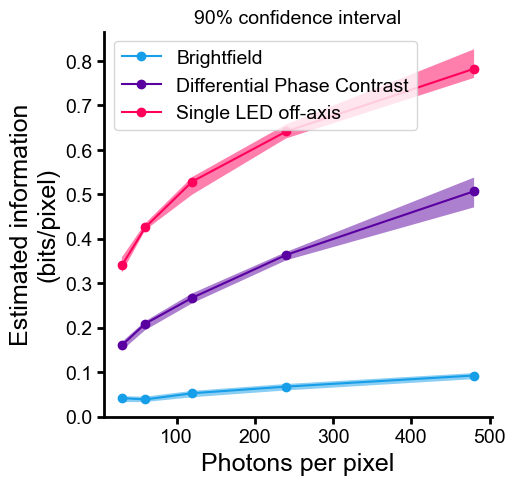

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(photons_per_pixel, mi_means_by_channel_photons['Brightfield'], '-o',
         label=get_display_channel_names('Brightfield'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['Brightfield'][:, 0], 
                mi_confidences_by_channel_photons['Brightfield'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['DPC_Right'], '-o',
        label=get_display_channel_names('DPC_Right'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['DPC_Right'][:, 0],
                 mi_confidences_by_channel_photons['DPC_Right'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['LED119'], '-o',
        label=get_display_channel_names('LED119'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['LED119'][:, 0], 
                mi_confidences_by_channel_photons['LED119'][:, 1], alpha=0.5)
ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)', ylim=[0, None])
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence_interval}% confidence interval')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'mi_vs_photon_count_gp' + '.pdf', transparent=True)

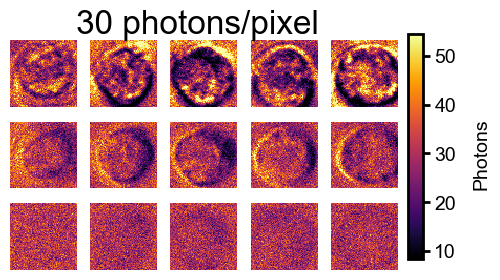

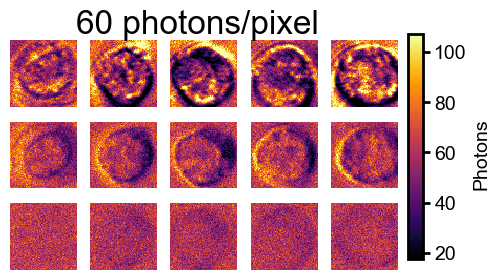

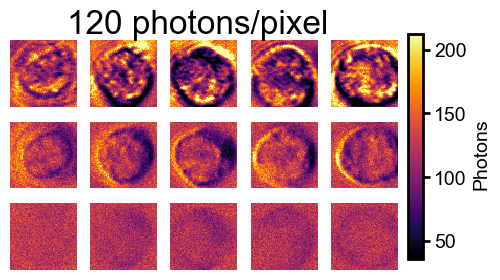

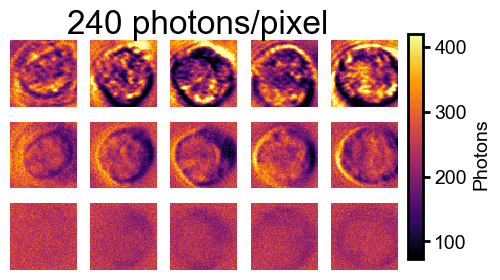

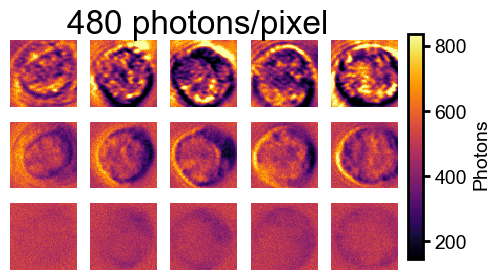

In [6]:
# show representative images for each channel at each photon level 
num_images = 5

for photons in photons_per_pixel:
    fig, axes = plt.subplots(3, num_images, figsize=(num_images, 3))
    vmin, vmax = None, None
    for channel_idx, channel_name in enumerate(channel_names[::-1]):
        images = load_bsccm_images(bsccm, channel_name, num_images=5, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False)
        noisy_images = add_shot_noise_to_experimenal_data(images, photons / np.mean(images))
        if vmin is None:
            vmin, vmax = np.percentile(noisy_images, 3), np.percentile(noisy_images, 97)
        for i in range(num_images):
            im = axes[channel_idx, i].imshow(noisy_images[i], cmap='inferno', interpolation='none', vmin=vmin, vmax=vmax)
            axes[channel_idx, i].axis('off')
    fig.suptitle(f'{photons} photons/pixel')

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.75])
    fig.colorbar(im, cax=cbar_ax)
    # add photons label
    fig.text(1.05, 0.5, 'Photons', va='center', rotation='vertical')
    fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + f'images_photons_{photons}.pdf', transparent=True)

    